<a href="https://colab.research.google.com/github/maheshyadav007/research/blob/main/NPK_MNIST_experiment_all_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [ ]:
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install matplotlib --upgrade

In [ ]:
import numpy as np
import pandas as pd

import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib


import random
import os
import copy
import torch 
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split 
import seaborn as sns
#from torchviz import make_dot
# from google.colab import files
from scipy.linalg import eigh
import gc
# %matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
%matplotlib inline
# matplotlib.use('agg')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import pairwise_distances

In [ ]:
from sklearn import datasets, svm, metrics

In [ ]:
# import numpy as np 
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

#Seed Setter

In [ ]:
def set_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  
  torch.backends.cudnn.deterministic = True
  # torch.use_deterministic_algorithms(True)
  torch.backends.cudnn.benchmark = False
  # Python RNG
  np.random.seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

#Making Dataset

*   CIFAR 10
*   MNIST
*   L1 
*   Boxed
*   Cube
*   Circle

In [ ]:

def circle_dataset_routine(n_data, a, b, seed, plot):
  angles = np.arange(0,2*np.pi,2*np.pi/n_data)

  x=np.zeros((len(angles),2))
  y=np.zeros(len(angles))

  #a := Number of half cycles in the top half of the circle
  #b := number of half cycles in the bottom half of the circle

  for idx, angle in enumerate(angles):
      x[idx,0]=np.cos(angle)
      x[idx,1]=np.sin(angle)
      if angle<np.pi:
          y[idx] = np.sin(a*angle)
      else:
          y[idx] = np.sin(a*np.pi+b*(angle-np.pi))   

  y = np.float32(y)
  
  if plot:
    plt.plot(angles, y)
    plt.xlabel("angle in radians")
    plt.ylabel("label function (y)")
    plt.figure()
    plt.axis('equal')
    plt.scatter(x[:,0],x[:,1],c=y)
    plt.colorbar()
    
  return x, np.squeeze(y)
def circle_dataset(dataset_args):
  n_data, a, b, plot = dataset_args['n_data'], dataset_args['a'], dataset_args['b'], dataset_args['plot'] 
  x_train, y_train = circle_dataset_routine(n_data = n_data,a = a,b = b, seed = None, plot = plot)
  x_val, y_val = circle_dataset_routine(n_data = n_data,a = a,b = b, seed = None, plot = False)
  x_test, y_test = circle_dataset_routine(n_data = n_data,a = a,b = b, seed = None, plot = False)

  x_mini, y_mini = x_test[:500], y_test[:500]
  
  return x_train, y_train, x_val, y_val, x_test, y_test,  x_mini, y_mini

In [ ]:
def circle_dataset_routine(n_data, a, b, seed, plot):
  angles = np.arange(0,2*np.pi,2*np.pi/n_data)

  x=np.zeros((len(angles),2))
  y=np.zeros(len(angles))

  #a := Number of half cycles in the top half of the circle
  #b := number of half cycles in the bottom half of the circle

  for idx, angle in enumerate(angles):
      x[idx,0]=np.cos(angle)
      x[idx,1]=np.sin(angle)
      if angle<np.pi:
          y[idx] = np.sin(a*angle)
      else:
          y[idx] = np.sin(a*np.pi+b*(angle-np.pi))   

  y = np.float32(y)
  
  if plot:
    plt.plot(angles, y)
    plt.xlabel("angle in radians")
    plt.ylabel("label function (y)")
    # plt.savefig("circle.pdf", format = 'pdf')
    plt.figure()
    plt.axis('equal')
    plt.scatter(x[:,0],x[:,1],c=y)
    plt.colorbar()
    # plt.savefig("circle_label_func.pdf", format = 'pdf')
    
  return x, np.squeeze(y)
def circle_dataset(dataset_args):
  n_data, a, b, plot = dataset_args['n_data'], dataset_args['a'], dataset_args['b'], dataset_args['plot'] 
  x_train, y_train = circle_dataset_routine(n_data = n_data,a = a,b = b, seed = None, plot = plot)
  x_val, y_val = circle_dataset_routine(n_data = n_data,a = a,b = b, seed = None, plot = False)
  x_test, y_test = circle_dataset_routine(n_data = n_data,a = a,b = b, seed = None, plot = False)

  x_mini, y_mini = x_test[:500], y_test[:500]
  
  return x_train, y_train, x_val, y_val, x_test, y_test,  x_mini, y_mini

In [ ]:
# _ = circle_dataset(dataset_args)

In [ ]:
def binary_cifar_dataset_routine(size, is_train,is_binary, flattened):
  data = torchvision.datasets.CIFAR10(root = '/CIFAR10', train = is_train, download = True,  transform=ToTensor())
  X, Y = [], []
  for idx, d in enumerate(data):
    X.append(d[0].numpy())
    Y.append(d[1])
  Y = np.expand_dims(Y, axis = 1)
  X = np.array(X)
  # X = np.squeeze(X, axis = 1)
  if is_binary :
    X = X[np.logical_or(Y==4, Y == 8).squeeze()]
    Y = Y[np.logical_or(Y==4, Y == 8)]
    Y[Y == 4], Y[Y == 8] = 0, 1
  if flattened : 
    X = X.reshape((X.shape[0], -1))
  return X, np.squeeze(Y)

def binary_cifar_dataset(dataset_args):
  flattened, is_binary = dataset_args['flattened'], dataset_args['is_binary']
  n_data = 0
  x_train, y_train = binary_cifar_dataset_routine(n_data, is_train = True,is_binary = is_binary, flattened = flattened)
  x_val, y_val = None, None
  x_test, y_test = binary_cifar_dataset_routine(n_data, is_train = False,is_binary = is_binary, flattened = flattened)
  print(x_train.shape, y_train.shape)
  x_mini, y_mini = x_test[:500], y_test[:500]
  
  return x_train, y_train, x_val, y_val, x_test, y_test,  x_mini, y_mini

In [ ]:
def binary_mnist_dataset_routine(size, is_train):
  mnist_train_data = torchvision.datasets.MNIST(root = '/MNIST', train = is_train, download = True,  transform=ToTensor())
  X, Y = [], []
  for idx, data in enumerate(mnist_train_data):
    X.append(torch.flatten(data[0], start_dim=1, end_dim=- 1).numpy())
    Y.append(data[1])
  Y = np.expand_dims(Y, axis = 1)
  X = np.array(X)
  # X = np.squeeze(X, axis = 1)
  X = X[np.logical_or(Y==0, Y == 1)]
  Y = Y[np.logical_or(Y==0, Y == 1)]
  # Y[Y==1] = 0
  # Y[Y == 7] = 1
  return X, np.squeeze(Y)

def binary_mnist_dataset(*args):
  n_data = None
  x_train, y_train = binary_mnist_dataset_routine(n_data, is_train = True)
  x_val, y_val = None, None
  x_test, y_test = binary_mnist_dataset_routine(n_data, is_train = False)
  print(x_train.shape, y_train.shape)
  x_mini, y_mini = x_test[:500], y_test[:500]
  
  return x_train, y_train, x_val, y_val, x_test, y_test,  x_mini, y_mini

In [ ]:
def boxed_complex_dataset_routine(size, seed):
  rng = np.random.default_rng(10)
  x1 = rng.random((size,1))*(2*2*np.pi) - 2*np.pi
  x2 = rng.random((size,1))*(2*np.pi) - np.pi
  x = np.concatenate((x1, x2), axis = 1)
  y1 = np.sign(np.sin(2*x[:,0]))
  y2 = np.sign(np.sin(x[:,1]))
  y = y1*y2
  y1[y1 == -1] = 0
  y2[y2 == -1] = 0
  y[y == -1] = 0
  plt.scatter(x[:,0], x[:,1], c = y)
  plt.axis('equal')
  return x, np.squeeze(y)
def boxed_complex_dataset():
  n_data = 2000
  x_train, y_train = boxed_complex_dataset_routine(n_data, 1)
  x_val, y_val = boxed_complex_dataset_routine(n_data, 2)
  x_test, y_test = boxed_complex_dataset_routine(n_data, 3)

  x_mini, y_mini = x_test[:500], y_test[:500]
  
  return x_train, y_train, x_val, y_val, x_test, y_test,  x_mini, y_mini

In [ ]:
def boxed_complex_dataset_routine(size, seed):
  rng = np.random.default_rng(10)
  x1 = rng.random((size,1))*(2*2*np.pi) - 2*np.pi
  x2 = rng.random((size,1))*(2*np.pi) - np.pi
  x = np.concatenate((x1, x2), axis = 1)
  y1 = np.sign(np.sin(2*x[:,0]))
  y2 = np.sign(np.sin(x[:,1]))
  y = y1*y2
  y1[y1 == -1] = 0
  y2[y2 == -1] = 0
  y[y == -1] = 0
  plt.scatter(x[:,0], x[:,1], c = y)
  plt.axis('equal')
  return x, np.squeeze(y)
def boxed_complex_dataset():
  n_data = 2000
  x_train, y_train = boxed_complex_dataset_routine(n_data, 1)
  x_val, y_val = boxed_complex_dataset_routine(n_data, 2)
  x_test, y_test = boxed_complex_dataset_routine(n_data, 3)

  x_mini, y_mini = x_test[:500], y_test[:500]
  
  return x_train, y_train, x_val, y_val, x_test, y_test,  x_mini, y_mini
def boxed_dataset_routine(size, seed):
  rng = np.random.default_rng(seed)
  x1 = rng.random((size,1))*(2*2*np.pi) - 2*np.pi
  x2 = rng.random((size,1))*(2*np.pi) - np.pi
  x = np.concatenate((x1, x2), axis = 1)
  y = np.sign(np.sin(2*x[:,0]))
  # y2 = np.sign(np.sin(x[:,1]))
  # y = y1*y2
  # y1[y1 == -1] = 0
  # y2[y2 == -1] = 0
  y[y == -1] = 0
  plt.scatter(x[:,0], x[:,1], c = y)
  plt.axis('equal')
  return x, np.squeeze(y)
def boxed_dataset(*args):
  n_data = 1000
  x_train, y_train = boxed_dataset_routine(n_data, 1)
  x_val, y_val = boxed_dataset_routine(n_data, 2)
  x_test, y_test = boxed_dataset_routine(n_data, 3)

  x_mini, y_mini = x_test[:500], y_test[:500]
  
  return x_train, y_train, x_val, y_val, x_test, y_test,  x_mini, y_mini

In [ ]:
def union_dataset_routine(size, seed):
  rng = np.random.default_rng(seed)
  x1 = rng.uniform(low = -1, high = 1, size = (size,1))
  x2 = rng.uniform(low = -1, high = 1, size = (size,1))
  x = np.concatenate((x1, x2), axis = 1)
  
  w1, w2 = np.array([[-1 ],[1]]), np.array([[1 ],[-1]])
  w1, w2 = w1/np.linalg.norm(w1), w2/np.linalg.norm(w2)
  y1 = np.sign(np.matmul(x, w1) - np.sqrt(2)/4.5)
  y2 = np.sign(np.matmul(x, w2) +  2*np.sqrt(2)/3)
  y3 = np.sign(np.matmul(x, w1) + 2* np.sqrt(2)/3)
  y4 = np.sign(np.matmul(x, w2) -  np.sqrt(2)/4.5)
  # y1[y1 == -1],y2[y2 == -1]  = 0, 0
  y = y1 + y2 + y3 + y4
  x[:,1] = x[:,1] + 3
  X, Y = x, y
  
  x1 = rng.uniform(low = -1, high = 1, size = (size,1))
  x2 = rng.uniform(low = -1, high = 1, size = (size,1))
  x = np.concatenate((x1, x2), axis = 1)
  w1, w2 = np.array([[1 ],[1]]), np.array([[-1 ],[-1]])
  w1, w2 = w1/np.linalg.norm(w1), w2/np.linalg.norm(w2)
  y1 = np.sign(np.matmul(x, w1) - np.sqrt(2)/4.5)
  y2 = np.sign(np.matmul(x, w2) +  2*np.sqrt(2)/3)
  y3 = np.sign(np.matmul(x, w1) + 2* np.sqrt(2)/3)
  y4 = np.sign(np.matmul(x, w2) -  np.sqrt(2)/4.5)
  y = y1 + y2 + y3 + y4
  
  X, Y = np.concatenate((X,x), axis = 0), np.concatenate((Y,y), axis = 0)
  Y[Y==2] = 1
  plt.scatter(X[:,0], X[:,1], c = Y)
  plt.axis('equal')
  return X, np.squeeze(Y)
def union_dataset():
  n_data = 2000
  x_train, y_train = union_dataset_routine(n_data, 1)
  x_val, y_val = union_dataset_routine(n_data, 2)
  x_test, y_test = union_dataset_routine(n_data, 3)

  x_mini, y_mini = x_test[:500], y_test[:500]
  
  return x_train, y_train, x_val, y_val, x_test, y_test,  x_mini, y_mini

In [ ]:
def L1_dataset_routine(size, seed):
  rng = np.random.default_rng(10)
  x1 = rng.random((1000,1))*(2) - 1
  x2 = rng.random((1000,1))*(2) - 1
  # scaler = np.linalg.norm(np.concatenate((x1, x2), axis = 1), ord = 1, axis = 1, keepdims = True) * 1/.5
  x = np.concatenate((x1, x2), axis = 1)
  y = np.linalg.norm(np.concatenate((x1, x2), axis = 1), ord = 1, axis = 1, keepdims = True) >= 1
  y = y*1
  plt.scatter(x[:,0], x[:,1], c = y)
  plt.axis('equal')
  return x, np.squeeze(y)
def L1_dataset():
  n_data = 1000
  x_train, y_train = L1_dataset_routine(1000, 1)
  x_val, y_val = L1_dataset_routine(1000, 2)
  x_test, y_test = L1_dataset_routine(1000, 3)

  x_mini, y_mini = x_test[:500], y_test[:500]
  
  return x_train, y_train, x_val, y_val, x_test, y_test,  x_mini, y_mini


In [ ]:
def parabola_dataset_routine(size, seed):
  rng = np.random.default_rng(seed)
  x1 = rng.random((size,1))*(2) - 1
  x2 = rng.random((size,1))*(2) - .75
  y =  x2 >= x1**2/(1)
  y = y*1
  return np.concatenate((x1, x2), axis = 1), np.squeeze(y)
def parabola_dataset():
  n_data = 1000
  x_train, y_train = parabola_dataset_routine(1000, 1)
  x_val, y_val = parabola_dataset_routine(1000, 2)
  x_test, y_test = parabola_dataset_routine(1000, 3)

  x_mini, y_mini = x_test[:500], y_test[:500]
  
  return x_train, y_train, x_val, y_val, x_test, y_test,  x_mini, y_mini


In [ ]:
def get_dist(test_data_curr):
  data = test_data_curr
  dist = []
  start = 0
  end = 400
  for n in range(6):
    
    if n == 0 or n == 1:
      dist.append(np.minimum(np.minimum(np.abs(data[start:end,2] - .5), np.abs(data[start:end,2] + .5)), np.minimum(np.abs(data[start:end,1] - .5), np.abs(data[start:end,1] + .5))))
    if n == 2 or n == 3:
      dist.append(np.minimum(np.minimum(np.abs(data[start:end,0] - .5), np.abs(data[start:end,0] + .5)), np.minimum(np.abs(data[start:end,2] - .5), np.abs(data[start:end,2] + .5))))
    if n == 4 or n == 5:
      dist.append(np.minimum(np.minimum(np.abs(data[start:end,0] - .5), np.abs(data[start:end,0] + .5)), np.minimum(np.abs(data[start:end,1] - .5), np.abs(data[start:end,1] + .5))))
    start = end
    end = end + 400
  dist = np.concatenate(dist)
  return dist

In [ ]:
num_modes=6
d=num_modes//2
def get_cube_data():
  num_modes=6 # Each mode is a d-1 dimensional hyperplane perpendicular to one of the exes, and intercept at +b or -b
  d=num_modes//2 # Choose d to be a multiple of num_modes
  d=3
  num_modes=6
  a=[2]*6
  mode_frac = np.array([1./num_modes]*num_modes)
  b=1.

  num_train_data = 2400 
  num_vali_data=2400
  num_test_data=2400
  num_data = num_train_data + num_vali_data + num_test_data



  num_data_per_mode = np.int32(num_data*mode_frac)
  num_data_per_mode=np.concatenate((num_data_per_mode,[np.sum(num_data_per_mode)]))


  landmarks=[-1]*num_modes
  labels=[-1]*num_modes
  for i in range(num_modes):
      landmarks[i] = np.random.randn(a[i],d)
      
      landmarks[i][:, i//2] = 2*b*((i%2)-0.5)*np.ones(a[i])
      print("Colum ", str(i//2),"of mode", str(i), "with", str(2*b*((i%2)-0.5)*np.ones(a[i])))
      landmarks[i]/=2.
      labels[i] = (np.arange(len(landmarks[i])))%2

  data=[-1]*num_modes
  data_labels=[-1]*num_modes

  train_data=[-1]*num_modes
  train_data_labels=[-1]*num_modes

  test_data=[-1]*num_modes
  test_data_labels=[-1]*num_modes

  vali_data=[-1]*num_modes
  vali_data_labels=[-1]*num_modes


  modes_data=[]
  for i in range(num_modes):
      data[i] = np.random.randn(num_data_per_mode[i],d)
      data[i][:, i//2] = 2*b*((i%2)-0.5)*np.ones(num_data_per_mode[i])
      data_labels[i] = np.zeros(num_data_per_mode[i])
      for j in range(len(data_labels[i])):
          dists = pairwise_distances(data[i][j:j+1,:],landmarks[i])                                   
          j_star = np.argmin(dists[0])
          data_labels[i][j]=labels[i][j_star]
      
      data[i]/=2.
      train_data[i] = np.array(data[i][:int(mode_frac[i]*num_train_data)])
      train_data_labels[i] = np.array(data_labels[i][:int(mode_frac[i]*num_train_data)])

      vali_data[i] = np.array(data[i][int(mode_frac[i]*num_train_data): \
                                      int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])
      vali_data_labels[i] = np.array(data_labels[i][int(mode_frac[i]*num_train_data): \
                                      int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])

      test_data[i] = np.array(data[i][-int(mode_frac[i]*num_test_data):])
      test_data_labels[i] = np.array(data_labels[i][-int(mode_frac[i]*num_test_data):])
      
  train_data_curr = np.concatenate(train_data)
  train_labels_curr = np.concatenate(train_data_labels)
  vali_data_curr = np.concatenate(vali_data)
  vali_labels_curr = np.concatenate(vali_data_labels)
  test_data_curr = np.concatenate(test_data)
  test_labels_curr = np.concatenate(test_data_labels)
  dist = get_dist(test_data_curr)
  sorted_idx = np.argsort(dist)
  sorted_idx = np.concatenate((sorted_idx[:250], sorted_idx[-250:]))

  mini_test_data = np.squeeze(test_data_curr[sorted_idx])
  mini_test_labels = np.squeeze(test_labels_curr[sorted_idx])








  
  # num_modes=6
  # d=num_modes//2 # Choose d to be a multiple of num_modes
  # a=[2]*(num_modes-1) + [40]
  # mode_frac = np.array([0.25/(num_modes-1)]*(num_modes-1)+ [0.75])

  # label_noise_frac=[0.0]*(num_modes-1)+[0.0]
  # instance_noise_stdev = [0.0]*num_modes

  # # These two numbers make sense only if d=2*num_modes
  # corrs = [0.0]*num_modes
  # nn_transform = [np.diag([1.,1.]*num_modes)]*num_modes  

  # num_train_data = 640 
  # num_vali_data=2000
  # num_test_data=2000
  # num_data = num_train_data + num_vali_data + num_test_data



  # num_data_per_mode = np.int32(num_data*mode_frac)
  # num_data_per_mode=np.concatenate((num_data_per_mode,[np.sum(num_data_per_mode)]))


  # landmarks=[-1]*num_modes
  # labels=[-1]*num_modes
  # for i in range(num_modes):
  #     landmarks[i] = np.zeros((a[i],d))
  #     thetas = np.arange(0,2*np.pi-0.01,2*np.pi/a[i])
  #     temp = np.concatenate((np.cos(thetas)[:,None], np.sin(thetas)[:,None]),axis=1)
      

  #     landmarks[i][:, i*d//num_modes:(i+1)*d//num_modes] = temp
  #     if i<num_modes-1:
  #         labels[i] = np.ones((len(landmarks[i])))*(i)%2        
  #     else:
  #         labels[i] = (np.arange(len(landmarks[i])) + i)%2

  # labels_all_modes = np.concatenate(labels, axis=0)
  # landmarks_all_modes = np.concatenate(landmarks, axis=0)

  # data=[-1]*num_modes
  # data_labels=[-1]*num_modes

  # train_data=[-1]*num_modes
  # train_data_labels=[-1]*num_modes

  # test_data=[-1]*num_modes
  # test_data_labels=[-1]*num_modes

  # vali_data=[-1]*num_modes
  # vali_data_labels=[-1]*num_modes


  # modes_data=[]
  # for i in range(num_modes):
  #     data[i] = np.zeros((num_data_per_mode[i],d))    
  #     temp = np.random.randn(num_data_per_mode[i], d//num_modes)
  #     temp = temp/np.sqrt(np.sum(temp**2, axis=1)[:,None])

  #     data[i][:,i*d//num_modes:(i+1)*d//num_modes] = temp
  #     data[i] += np.random.randn(num_data_per_mode[i],d)*instance_noise_stdev[i]
  #     data_labels[i] = np.zeros(num_data_per_mode[i])
  #     for j in range(len(data_labels[i])):
  #         dists = pairwise_distances(np.dot(data[i][j:j+1,:], nn_transform[i]) 
  #                                   ,np.dot(landmarks_all_modes, nn_transform[i]))
  #         j_star = np.argmin(dists[0])
  #         data_labels[i][j]=labels_all_modes[j_star]
  #         modes_data.append(i)
  #     data_labels[i] = (data_labels[i] + np.int32(np.random.rand(len(data_labels[i]))<label_noise_frac[i]) ) % 2

  #     data[i][:,i*d//num_modes:(i+1)*d//num_modes] = np.dot(data[i][:,i*d//num_modes:(i+1)*d//num_modes], 
  #                                                           np.array([[1., corrs[i]],[corrs[i], 1.]]))
      
  #     train_data[i] = np.array(data[i][:int(mode_frac[i]*num_train_data)])
  #     train_data_labels[i] = np.array(data_labels[i][:int(mode_frac[i]*num_train_data)])

  #     vali_data[i] = np.array(data[i][int(mode_frac[i]*num_train_data): \
  #                                     int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])
  #     vali_data_labels[i] = np.array(data_labels[i][int(mode_frac[i]*num_train_data): \
  #                                     int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])

  #     test_data[i] = np.array(data[i][-int(mode_frac[i]*num_test_data):])
  #     test_data_labels[i] = np.array(data_labels[i][-int(mode_frac[i]*num_test_data):])
      
  # train_data_curr = np.concatenate(train_data)
  # train_labels_curr = np.concatenate(train_data_labels)
  # vali_data_curr = np.concatenate(vali_data)
  # vali_labels_curr = np.concatenate(vali_data_labels)
  # test_data_curr = np.concatenate(test_data)
  # test_labels_curr = np.concatenate(test_data_labels)
  # dist = get_dist(test_data_curr)
  # sorted_idx = np.argsort(dist)
  # sorted_idx = np.concatenate((sorted_idx[:250], sorted_idx[-250:]))
  # mini_test_data = np.squeeze(test_data_curr[sorted_idx])
  # mini_test_labels = np.squeeze(test_labels_curr[sorted_idx])
  return train_data_curr, train_labels_curr, vali_data_curr, vali_labels_curr, test_data_curr, test_labels_curr, mini_test_data, mini_test_labels

In [ ]:
# train_data_curr, train_labels_curr, vali_data_curr, vali_labels_curr, test_data_curr, test_labels_curr, mini_test_data, mini_test_labels = get_cube_data()

In [ ]:
# num_modes=6 # Each mode is a d-1 dimensional hyperplane perpendicular to one of the exes, and intercept at +b or -b
# d=num_modes//2 # Choose d to be a multiple of num_modes
# d=3
# num_modes=6
# a=[2]*6
# mode_frac = np.array([1./num_modes]*num_modes)
# b=1.

# num_train_data = 2400 
# num_vali_data=2400
# num_test_data=2400
# num_data = num_train_data + num_vali_data + num_test_data



# num_data_per_mode = np.int32(num_data*mode_frac)
# num_data_per_mode=np.concatenate((num_data_per_mode,[np.sum(num_data_per_mode)]))


# landmarks=[-1]*num_modes
# labels=[-1]*num_modes
# for i in range(num_modes):
#     landmarks[i] = np.random.randn(a[i],d)
    
#     landmarks[i][:, i//2] = 2*b*((i%2)-0.5)*np.ones(a[i])
#     print("Colum ", str(i//2),"of mode", str(i), "with", str(2*b*((i%2)-0.5)*np.ones(a[i])))
#     landmarks[i]/=2.
#     labels[i] = (np.arange(len(landmarks[i])))%2

# data=[-1]*num_modes
# data_labels=[-1]*num_modes

# train_data=[-1]*num_modes
# train_data_labels=[-1]*num_modes

# test_data=[-1]*num_modes
# test_data_labels=[-1]*num_modes

# vali_data=[-1]*num_modes
# vali_data_labels=[-1]*num_modes


# modes_data=[]
# for i in range(num_modes):
#     data[i] = np.random.randn(num_data_per_mode[i],d)
#     data[i][:, i//2] = 2*b*((i%2)-0.5)*np.ones(num_data_per_mode[i])
#     data_labels[i] = np.zeros(num_data_per_mode[i])
#     for j in range(len(data_labels[i])):
#         dists = pairwise_distances(data[i][j:j+1,:],landmarks[i])                                   
#         j_star = np.argmin(dists[0])
#         data_labels[i][j]=labels[i][j_star]
    
#     data[i]/=2.
#     train_data[i] = np.array(data[i][:int(mode_frac[i]*num_train_data)])
#     train_data_labels[i] = np.array(data_labels[i][:int(mode_frac[i]*num_train_data)])

#     vali_data[i] = np.array(data[i][int(mode_frac[i]*num_train_data): \
#                                     int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])
#     vali_data_labels[i] = np.array(data_labels[i][int(mode_frac[i]*num_train_data): \
#                                     int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])

#     test_data[i] = np.array(data[i][-int(mode_frac[i]*num_test_data):])
#     test_data_labels[i] = np.array(data_labels[i][-int(mode_frac[i]*num_test_data):])
    
# train_data_curr = np.concatenate(train_data)
# train_labels_curr = np.concatenate(train_data_labels)
# vali_data_curr = np.concatenate(vali_data)
# vali_labels_curr = np.concatenate(vali_data_labels)
# test_data_curr = np.concatenate(test_data)
# test_labels_curr = np.concatenate(test_data_labels)
# dist = get_dist(test_data_curr)
# sorted_idx = np.argsort(dist)
# sorted_idx = np.concatenate((sorted_idx[:250], sorted_idx[-250:]))

# mini_test_data = np.squeeze(test_data_curr[sorted_idx])
# mini_test_labels = np.squeeze(test_labels_curr[sorted_idx])

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# st = 0
# end = st+250
# x, y, z = zip(*mini_test_data[st:end,:])

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(xs = x, ys = y,zs = z, c = mini_test_labels[st:end])
# # plt.scatter(x = y, y = z, c = train_labels_curr[st:end])
# # plt.plot(landmarks[1][:, 1], landmarks[1][:, 2])
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# x, y, z = zip(*train_data_curr[400:800,:])

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(xs = x, ys = y,zs = z, c = test_labels_curr[400:800])
# plt.show()

In [ ]:
# num_modes=21
# d=2*num_modes

# def get_multi_modes_data():
#   num_modes=21
#   d=2*num_modes # Choose d to be a multiple of num_modes
#   a=[2]*(num_modes-1) + [40]
#   mode_frac = np.array([0.5/(num_modes-1)]*(num_modes-1)+ [0.5])

#   label_noise_frac=[0.05]*num_modes
#   instance_noise_stdev = [0.0]*num_modes

#   # These two numbers make sense only if d=2*num_modes
#   corrs = [0.0]*num_modes
#   nn_transform = [np.diag([1.,1.]*num_modes)]*num_modes  

#   num_train_data = 640 
#   num_vali_data=2000
#   num_test_data=2000
#   num_data = num_train_data + num_vali_data + num_test_data



#   num_data_per_mode = np.int32(num_data*mode_frac)
#   num_data_per_mode=np.concatenate((num_data_per_mode,[np.sum(num_data_per_mode)]))


#   landmarks=[-1]*num_modes
#   labels=[-1]*num_modes
#   for i in range(num_modes):
#       landmarks[i] = np.zeros((a[i],d))
#       thetas = np.arange(0,2*np.pi-0.01,2*np.pi/a[i])
#       temp = np.concatenate((np.cos(thetas)[:,None], np.sin(thetas)[:,None]),axis=1)
      

#       landmarks[i][:, i*d//num_modes:(i+1)*d//num_modes] = temp
#       labels[i] = (np.arange(len(landmarks[i])) + i)%2
#   labels_all_modes = np.concatenate(labels, axis=0)
#   landmarks_all_modes = np.concatenate(landmarks, axis=0)

#   data=[-1]*num_modes
#   data_labels=[-1]*num_modes

#   train_data=[-1]*num_modes
#   train_data_labels=[-1]*num_modes

#   test_data=[-1]*num_modes
#   test_data_labels=[-1]*num_modes

#   vali_data=[-1]*num_modes
#   vali_data_labels=[-1]*num_modes


#   modes_data=[]
#   for i in range(num_modes):
#       data[i] = np.zeros((num_data_per_mode[i],d))    
#       temp = np.random.randn(num_data_per_mode[i], d//num_modes)
#       temp = temp/np.sqrt(np.sum(temp**2, axis=1)[:,None])

#       data[i][:,i*d//num_modes:(i+1)*d//num_modes] = temp
#       data[i] += np.random.randn(num_data_per_mode[i],d)*instance_noise_stdev[i]
#       data_labels[i] = np.zeros(num_data_per_mode[i])
#       for j in range(len(data_labels[i])):
#           dists = pairwise_distances(np.dot(data[i][j:j+1,:], nn_transform[i]) 
#                                     ,np.dot(landmarks_all_modes, nn_transform[i]))
#           j_star = np.argmin(dists[0])
#           data_labels[i][j]=labels_all_modes[j_star]
#           modes_data.append(i)
#       data_labels[i] = (data_labels[i] + np.int32(np.random.rand(len(data_labels[i]))<label_noise_frac[i]) ) % 2

#       data[i][:,i*d//num_modes:(i+1)*d//num_modes] = np.dot(data[i][:,i*d//num_modes:(i+1)*d//num_modes], 
#                                                             np.array([[1., corrs[i]],[corrs[i], 1.]]))
      
#       train_data[i] = np.array(data[i][:int(mode_frac[i]*num_train_data)])
#       train_data_labels[i] = np.array(data_labels[i][:int(mode_frac[i]*num_train_data)])

#       vali_data[i] = np.array(data[i][int(mode_frac[i]*num_train_data): \
#                                       int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])
#       vali_data_labels[i] = np.array(data_labels[i][int(mode_frac[i]*num_train_data): \
#                                       int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])

#       test_data[i] = np.array(data[i][-int(mode_frac[i]*num_test_data):])
#       test_data_labels[i] = np.array(data_labels[i][-int(mode_frac[i]*num_test_data):])
      
#   train_data_curr = np.concatenate(train_data)
#   train_labels_curr = np.concatenate(train_data_labels)
#   vali_data_curr = np.concatenate(vali_data)
#   vali_labels_curr = np.concatenate(vali_data_labels)
#   test_data_curr = np.concatenate(test_data)
#   test_labels_curr = np.concatenate(test_data_labels)
#   return train_data_curr, train_labels_curr, vali_data_curr, vali_labels_curr, test_data_curr, test_labels_curr

In [ ]:
#cube data
def get_mini_multi_modes_data(test_data_curr,num_modes, n_examples_per_mode):
  n_data_per_mode = test_data_curr.shape[0]//num_modes
  stride_length = n_data_per_mode
  X = []#np.zeros((n_examples_per_mode*num_modes, d))
  for i in range(num_modes):
    X.append(test_data_curr[i*stride_length: (i+1)*stride_length][np.random.choice(stride_length, n_examples_per_mode, replace=False)])
  return np.concatenate(X)

#multimode data
# def get_mini_multi_modes_data(test_data_curr,num_modes, n_examples_per_mode):
#   n_data_per_mode = (int(test_data_curr.shape[0]/2))//num_modes
#   stride_length = n_data_per_mode
#   X = []#np.zeros((n_examples_per_mode*num_modes, d))
#   for i in range(num_modes-1):
#     X.append(test_data_curr[i*stride_length: (i+1)*stride_length][np.random.choice(stride_length, n_examples_per_mode, replace=False)])
#   X.append(test_data_curr[1000: 2000][np.random.choice(1000, n_examples_per_mode, replace=False)])
#   return np.concatenate(X)

In [ ]:
# def get_mini_multi_modes_data(test_data_curr,num_modes, n_examples_per_mode):
#   n_data_per_mode = (test_data_curr.shape[0]//2)//(num_modes-1)
#   stride_length = n_data_per_mode
#   X = []#np.zeros((n_examples_per_mode*num_modes, d))
#   for i in range(num_modes-1):
#     X.append(test_data_curr[i*stride_length: (i+1)*stride_length][np.random.choice(stride_length, n_examples_per_mode, replace=False)])
#   X.append(test_data_curr[1000: 2000][np.random.choice(1000, n_examples_per_mode, replace=False)])
#   return np.concatenate(X)

In [ ]:
# def get_mini_multi_modes_data(instance):
#   instance = instance
#   thetas = np.arange(0, 2*np.pi, 2*np.pi/instance)
#   X = np.zeros((instance*num_modes, d))
#   for i in range(num_modes):
#     X[i*instance: (i+1)*instance, i*2] = np.cos(thetas)
#     X[i*instance: (i+1)*instance, i*2+1] = np.sin(thetas)
#   return X

In [ ]:
class Mini(Dataset):
      def __init__(self, X):
          self.size = len(X)
          self.x = X
         
      def __len__(self):
          return (self.size)

      def __getitem__(self, idx):
          #print(self.x[idx].shape,self.y[idx].shape )
          return self.x[idx].float()
def get_mini_multi_mode_dataloaders(X_mini, batch_size = 100):
  X_mini = torch.tensor(X_mini)
  mini = Mini(X_mini)

  mini_dl = torch.utils.data.DataLoader(mini,
                                            batch_size=batch_size,
                                            shuffle=False
                                          )
  return mini_dl

In [ ]:
class DSphere(Dataset):
      def __init__(self, X, Y):
          self.size = len(Y)
          self.x = X
          self.y = Y

      def __len__(self):
          return (self.size)

      def __getitem__(self, idx):
          #print(self.x[idx].shape,self.y[idx].shape )
          return self.x[idx].float(), self.y[idx]
def get_mini_dsphere(X,Y,n_data, a,b):
  
  mini_X = []
  mini_Y = []

  rng = np.random.default_rng(0)
  idxs = rng.choice(np.arange(0, int(n_data/2)-a),50, replace = False)
  mini_X.extend([X[idx]  for idx in idxs])
  mini_Y.extend([Y[idx]  for idx in idxs])

  idxs = rng.choice(np.arange(int(n_data/2)-a,int(n_data)-a-b),50, replace = False)
  mini_X.extend([X[idx]  for idx in idxs])
  mini_Y.extend([Y[idx]  for idx in idxs])
  
  return mini_X, mini_Y

def get_dsphere_dls(n_data, a, b,d, batch_size, is_perturbed):
  
  rng = np.random.default_rng(seed = 0)

  n_data = n_data
  d = d

  X1 = rng.random(size = (int(n_data/2),int(d/2)))*(2) - 1 
  X1 = X1 / np.sqrt(np.sum(np.square(X1), axis = 1, keepdims = True))
  X1 = np.concatenate((X1, np.zeros(X1.shape)), axis = 1)

  X2 = rng.random(size = (int(n_data/2),int(d/2)))*(2) - 1 
  X2 = X2 / np.sqrt(np.sum(np.square(X2), axis = 1, keepdims = True))
  X2 = np.concatenate(( np.zeros(X2.shape), X2), axis = 1)

  X = np.concatenate((X1, X2), axis = 0)
  Y = np.zeros((int(n_data),), dtype = int)
  
  # Y_true = copy.deepcopy(Y)


  #transform Y
  sample_idx_1 = rng.choice(a = np.arange(int(n_data/2)), size = (a,), replace = False )
  for idx in sample_idx_1:
    Y[idx] = rng.choice(a = [1, 0], size = (1,))

  sample_idx_2 = rng.choice(a = np.arange(int(n_data/2), n_data), size = (b,), replace = False )
  for idx in sample_idx_2:
    Y[idx] = rng.choice(a = [1, 0], size = (1,))


  landmarks = np.concatenate((sample_idx_1, sample_idx_2), axis = 0)  
  mask=np.full(len(Y),False,dtype=bool)
  mask[landmarks]=True
  X_landmarks, Y_landmarks = np.array(X)[mask], np.array(Y)[mask]

  X_data = np.array(X)[~mask]

  neigh = KNeighborsClassifier(n_neighbors=1)
  neigh.fit(X_landmarks, Y_landmarks)
  Y_data = neigh.predict(X_data)


  # X_small = np.concatenate((X[sample_idx_1], X[sample_idx_2]), axis = 0)
  # Y_small = np.concatenate((Y[sample_idx_1], Y[sample_idx_2]), axis = 0)

  # neigh = KNeighborsClassifier(n_neighbors=1)
  # neigh.fit(X_small, Y_small)
  # Y_true = neigh.predict(X)

  mini_X, mini_Y = get_mini_dsphere(X_data, Y_data,n_data,  a, b)
  mode1_idxs, mode2_idxs = np.arange(0,int(n_data/2)-a), np.arange(int(n_data/2)-a, n_data-a-b)
  # print(landmarks)
  # mode1_idxs, mode2_idxs  = list(set(mode1_idxs) - set(landmarks)), list(set(mode2_idxs) - set(landmarks))
  X_mode1_data, Y_mode1_data = X_data[mode1_idxs], Y_data[mode1_idxs]
  X_mode2_data, Y_mode2_data = X_data[mode2_idxs], Y_data[mode2_idxs]


  X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.1, random_state=42)
  X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(X_mode1_data, Y_mode1_data, test_size=0.1, random_state=42)
  X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(X_mode2_data, Y_mode2_data, test_size=0.1, random_state=42)

  return (X_train, X_test, y_train, y_test), (X_train_m1, X_test_m1, y_train_m1, y_test_m1), (X_train_m2, X_test_m2, y_train_m2, y_test_m2), (mini_X, mini_Y)


In [ ]:
# def perturb_target(y):
#   # if y <= 4:
#   #   # p=[0.125, 0.125, 0.125, 0.125, 0.125]
#   #   p = [0.0, 0.0, 0.0, 0.0, 0.0]
#   #   p[y] = 1
#   #   return np.random.choice(5, 1,p = p)[0]
#   # else:
#   #   return y
#   if y == 6 or y == 8:
#     return 0
#   if y >= 5:
#     return 1

#   if y <= 4:
#     p=[.75, .25]
#     return np.random.choice([0, 1], 1,p = p)[0]
# def unperturb_target(y):
#   return y

# def get_mini_mnist(mnist_train_data, Y_perturbed):
#   X, Y = [], []
#   for idx, data in enumerate(mnist_train_data):
#     X.append(data[0])
#     Y.append(data[1])

#   mini_X = []
#   mini_Y = []

#   rng = np.random.default_rng(0)
#   for i in range(10):
#     idxs = rng.choice(np.where(np.array(Y) == i)[0],50, replace = False)
#     mini_X.extend([X[idx]  for idx in idxs])
#     mini_Y.extend([Y_perturbed[idx]  for idx in idxs])
  
#   return mini_X, mini_Y

# def get_transformed_data(mnist_train_data):
  
#   X, Y = [], []
#   for idx, data in enumerate(mnist_train_data):
#     X.append(data[0])
#     Y.append(perturb_target(data[1]))
#   return X, Y

# def get_transformed(X, Y):
#   rng = np.random.default_rng(0)
#   for i in range(10):
#     idxs = rng.choice(np.where(np.array(Y) == i)[0],50, replace = False)
  

In [ ]:
def get_mini_mnist(X, Y, mode1_idxs, mode2_idxs):

  mini_X = []
  mini_Y = []

  rng = np.random.default_rng(0)

  

  idxs = rng.choice(mode1_idxs ,50, replace = False)
  x, y = X[idxs], Y[idxs]
  mini_X.extend(x)
  mini_Y.extend(y)

  idxs = rng.choice(mode2_idxs ,50, replace = False)
  x, y = X[idxs], Y[idxs]
  mini_X.extend(x)
  mini_Y.extend(y)
  
  return mini_X, mini_Y

In [ ]:
def get_mnist_modified_data(a, b):
  mnist_train_data = torchvision.datasets.MNIST(root = '/MNIST', train = True, download = True,  transform=ToTensor())

  # X, Y = get_transformed_data(mnist_train_data)
  a, b = a, b
  modes = 2

  X, Y = [], []
  Y_perturbed = Y
  for idx, data in enumerate(mnist_train_data):
    X.append(data[0])
    Y.append(data[1])
  rng = np.random.default_rng(0)

  landmarks = []
  for i in range(5):
    idxs = rng.choice(np.where(np.array(Y) == i)[0], a, replace = False)
    landmarks.extend(idxs)

  for i in range(5,10):
    idxs = rng.choice(np.where(np.array(Y) == i)[0], b, replace = False)
    landmarks.extend(idxs)

  for i in landmarks:
    Y[i] = rng.choice([0,1], 1, p = [.5, .5], replace = False)[0]

  mask=np.full(len(Y),False,dtype=bool)
  mask[landmarks]=True
  X = [np.array(x).flatten() for x in X]
  X_landmarks, Y_landmarks = np.array(X)[mask], np.array(Y)[mask]

  Y_temp = np.array(Y)[~mask]
  mode1_idxs = []
  for i in range(5):
    idxs = np.where(Y_temp == i)[0]
    mode1_idxs.extend(idxs)

  mode2_idxs = []
  for i in range(5,10):
    idxs = np.where(Y_temp == i)[0]
    mode2_idxs.extend(idxs)



  X_data = np.array(X)[~mask]
  neigh = KNeighborsClassifier(n_neighbors=1)
  neigh.fit(X_landmarks, Y_landmarks)


  Y_data = neigh.predict(X_data)
  scaler = StandardScaler()
  X_data = scaler.fit_transform(X_data)


  mini_X, mini_Y = get_mini_mnist(X_data, Y_data, mode1_idxs, mode2_idxs)
  
  X_mode1_data, Y_mode1_data = X_data[mode1_idxs], Y_data[mode1_idxs]
  X_mode2_data, Y_mode2_data = X_data[mode2_idxs], Y_data[mode2_idxs]


  X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.1, random_state=42)
  X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(X_mode1_data, Y_mode1_data, test_size=0.1, random_state=42)
  X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(X_mode2_data, Y_mode2_data, test_size=0.1, random_state=42)

  return (X_train, X_test, y_train, y_test), (X_train_m1, X_test_m1, y_train_m1, y_test_m1), (X_train_m2, X_test_m2, y_train_m2, y_test_m2), (mini_X, mini_Y)

def get_dataloaders(X_train, X_test, y_train, y_test, batch_size):
  if is_classification:
    X_train, X_test, y_train, y_test = torch.tensor(np.array(X_train), dtype = torch.float32), torch.tensor(np.array(X_test), dtype = torch.float32),torch.tensor(np.array(y_train), dtype = torch.long),torch.tensor(np.array(y_test), dtype = torch.long)
    X_train_PWC, X_test_PWC, y_train_PWC, y_test_PWC = torch.tensor(np.ones(X_train.shape), dtype = torch.float32), torch.tensor(np.ones(X_test.shape), dtype = torch.float32),torch.tensor(np.array(y_train), dtype = torch.long),torch.tensor(np.array(y_test), dtype = torch.long)
  else:
    X_train, X_test, y_train, y_test = torch.tensor(np.array(X_train), dtype = torch.float32), torch.tensor(np.array(X_test), dtype = torch.float32),torch.tensor(np.array(y_train), dtype = torch.float32),torch.tensor(np.array(y_test), dtype = torch.float32)
    X_train_PWC, X_test_PWC, y_train_PWC, y_test_PWC = torch.tensor(np.ones(X_train.shape), dtype = torch.float32), torch.tensor(np.ones(X_test.shape), dtype = torch.float32),torch.tensor(np.array(y_train), dtype = torch.float32),torch.tensor(np.array(y_test), dtype = torch.float32)
  
  train = DATA(X_train,y_train)
  test = DATA(X_test,y_test)
  train_PWC = DATA(X_train_PWC,y_train)
  test_PWC = DATA(X_test_PWC,y_test)
  train_dl = torch.utils.data.DataLoader(train,
                                            batch_size=batch_size,
                                            shuffle=True
                                          )
  
  test_dl = torch.utils.data.DataLoader(test,
                                            batch_size=len(y_test),
                                            shuffle=False
                                          )
  train_dl_PWC = torch.utils.data.DataLoader(train_PWC,
                                            batch_size=batch_size,
                                            shuffle=False
                                          )
  
  test_dl_PWC = torch.utils.data.DataLoader(test_PWC,
                                            batch_size=len(y_test),
                                            shuffle=False
                                          )


  return train_dl, test_dl, train_dl_PWC, test_dl_PWC

def get_mini_dls(X_mini, y_mini, batch_size = 100):
  X_mini, y_mini = torch.tensor(X_mini), torch.tensor(y_mini)
  mnist_mini = MNIST(X_mini,y_mini)

  mnist_mini_dl = torch.utils.data.DataLoader(mnist_mini,
                                            batch_size=batch_size,
                                            shuffle=False
                                          )
  return mnist_mini_dl, y_mini

In [ ]:
class DATA(Dataset):
      def __init__(self, X, Y):
          self.size = len(Y)
          self.x = X
          self.y = Y

      def __len__(self):
          return (self.size)

      def __getitem__(self, idx):
          #print(self.x[idx].shape,self.y[idx].shape )
          return self.x[idx].float(), self.y[idx]


In [ ]:
# labels_map = {
#     0: "0",
#     1: "1",
#     2: "2",
#     3: "3",
#     4: "4",
#     5: "5",
#     6: "6",
#     7: "7",
#     8: "8",
#     9: "9",
# }
# figure = plt.figure(figsize=(8, 8))
# cols, rows = 3, 3
# sample_idx = 0
# for i in range(1, cols * rows + 1):
#     # sample_idx = torch.randint(len(mnist_train_data), size=(1,)).item()
#     img, label = mnist_train_data[sample_idx]
#     sample_idx += 1
#     figure.add_subplot(rows, cols, i)
#     plt.title(labels_map[label])
#     plt.axis("off")
#     plt.imshow(img.squeeze(), cmap="gray")
# plt.show()


In [ ]:
class CustomDataset(Dataset):
      def __init__(self, X, Y):
          self.size = len(Y)
          self.x = torch.tensor(X)
          self.y = torch.tensor(Y)

      def __len__(self):
          return (self.size)

      def __getitem__(self, idx):
          #print(self.x[idx].shape,self.y[idx].shape )
          return self.x[idx].float(), self.y[idx].float()

def make_circle_dataset(n_data_points, a, b, plot = False):
  n_data_points = n_data_points
  angles = np.arange(0,2*np.pi,2*np.pi/n_data_points)

  x=np.zeros((len(angles),2))
  y=np.zeros(len(angles))

  a=a # Number of half cycles in the top half of the circle
  b=b # number of half cycles in the bottom half of the circle

  for idx, angle in enumerate(angles):
      x[idx,0]=np.cos(angle)
      x[idx,1]=np.sin(angle)
      if angle<np.pi:
          y[idx] = np.sin(a*angle)
      else:
          y[idx] = np.sin(a*np.pi+b*(angle-np.pi))   

  # plt.plot(np.concatenate((angles,angles+np.pi*2)),np.concatenate((y,y)))
  
  if plot:
    plt.plot(angles, y)
    plt.figure()
    plt.axis('equal')
    plt.scatter(x[:,0],x[:,1],c=y)
  return x,y

def get_sorted_circle_dataset(X,Y):

  angles = [angle + 2*np.pi if angle < 0 else angle for angle in np.arctan2(X[:,1],X[:,0]) ]

  sorted_arg = np.argsort(angles)
  X_sorted = X[sorted_arg]
  Y_sorted = Y[sorted_arg]
  Y_sorted = Y_sorted.reshape((len(Y_sorted),1))
  return X_sorted, Y_sorted

def get_tempdataloaders(X,Y):
  batch_size = 32
  Y = Y.reshape((len(Y),1))
  # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)
  train_dataloader = DataLoader(CustomDataset(X,Y), batch_size = batch_size, shuffle = True)
  # test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size = batch_size, shuffle = True)
  dataloader_all = DataLoader(CustomDataset(X,Y), batch_size = len(Y), shuffle = False)
  return train_dataloader, dataloader_all

def plot_dataset(X_sorted, Y_sorted, points_idxs, save_fig):
  n_data_points = len(X_sorted)
  angles = np.arange(0,2*np.pi,2*np.pi/n_data_points)
  f, axes = plt.subplots(1,2, figsize = (2*5,5))
  axes[0].plot(angles, Y_sorted)
  axes[0].set_xlabel("angle in radians")
  axes[0].axis('equal')
  axes[1].scatter(X_sorted[:,0],X_sorted[:,1],c=Y_sorted)
  
  for i, point in enumerate(points_idxs):
    axes[1].scatter(X_sorted[point,0],X_sorted[point,1], c = 'r')
    axes[1].annotate(f'x{i+1}', (X_sorted[point,0],X_sorted[point,1]), xytext = (X_sorted[point,0]-.15,X_sorted[point,1]) )
  if save_fig:
    plt.savefig('input_dataset')

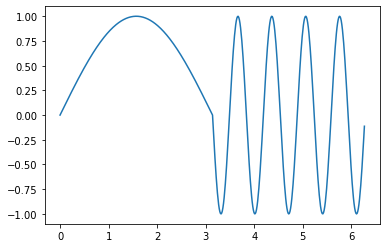

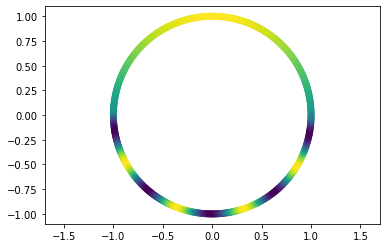

In [ ]:
_,_ = make_circle_dataset(500, 1, 9, plot = True)

#Plot heatmap

In [ ]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s$'%latex
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

In [ ]:
import matplotlib.ticker as tck

In [ ]:
def plot_heatmap(K, YKYs, state_info, all_input = True, save_fig = True, show_fig = False, mode = 'NA'):
  # plt.figure(figsize = (15,500))
  # f, axes = plt.subplots(1, len(K),figsize = (15*8,15))
  f, axes = plt.subplots(1, len(K),figsize = (10*len(K),10))
  if len(K) == 1:
    axes = [axes]
  model_title = 'unassigned'
  if mode != 'NA':
    mode_val = f'mode={int(mode):04d}'
  for i in range(len(K)):
    eigen_vals = eigh(K[i], eigvals_only = True)
    K[i] = K[i]/np.sum(eigen_vals)
    print(np.sum(eigen_vals))
    if all_input:
      if K[0].shape[0] <= 100:
        if i == len(K)-1:
          ax = sns.heatmap(K[i], linewidth = 0, ax = axes[i], vmin = 0, vmax = 20)
        else:
          ax = sns.heatmap(K[i], linewidth = 0, ax = axes[i])
      else:
        if i == len(K)-1:
          
          ax = sns.heatmap(K[i][0:500:5,0:500:5], linewidth = 0, ax = axes[i], vmin = 0, vmax = .004, cbar_kws={"shrink": .82})
          # ax = sns.heatmap(K[i][0:500:5,0:500:5], linewidth = 0, ax = axes[i])
        else:
          ax = sns.heatmap(K[i][0:500:5,0:500:5], linewidth = 0, ax = axes[i])
    else:
      ax =sns.heatmap(K[i][[x1_idx, x2_idx, x3_idx, x4_idx]][:,[x1_idx, x2_idx, x3_idx, x4_idx]], linewidth=.2, ax = axes[i] )
    
    
    pi = np.pi

    plt.xticks([0, 50, 100], ['0', 'π', '2π'])
    plt.yticks([ 50, 100], [ 'π', '2π'])
    ax.xaxis.tick_top()
    ax.set_aspect('equal')
    m_p_t = state_info["model_protocol_type"]
    n_h_l = f'n_h_l={state_info["n_hidden_layers"]}'
    n_n = f'n_n={state_info["n_neurons"]}'
    run = f'Run={state_info["run"]}'
    epoch = f'Epoch={state_info["epoch"]}'
    step = f'step={state_info["step"]}'
    s_i = state_info['learning_status']
    tr_loss = f'train_loss={state_info["train_loss"]}'
    tr_acc = f'train_acc={state_info["train_acc"]}'
    te_loss = f'test_loss={state_info["test_loss"]}'
    te_acc = f'test_acc={state_info["test_acc"]}'

    if mode == 'NA':
      model_title = f'{m_p_t}({n_h_l},{n_n},{run},{epoch},{step},{s_i},{tr_loss},{tr_acc},{te_loss},{te_acc})'
    else:
      
      model_title = f'{m_p_t}({mode_val},{n_h_l},{n_n},{run},{epoch},{step},{s_i},{tr_loss},{tr_acc},{te_loss},{te_acc})'



    if i < len(K)-1:
      # title = 'K'+str(i+1)+ ', ' +"Y'KY_n = "+ YKYs[i] 
      title = 'K'+str(i+1)
      # ax.set_xlabel(title, fontsize = 75)
      pass
    else:
      title = 'K'
      # title = 'K'+', ' +"Y'KY_n = "+  YKYs[i] 
      # ax.set_xlabel(title, fontsize = 75)

    del ax 
  # plt.suptitle(model_title,x = 0.5, y = 1.05,ha = 'center', fontsize = 90, fontweight = 20)
  if save_fig:
    plt.savefig(model_title + ".pdf" ,format = "pdf",bbox_inches='tight', dpi = 100)
  if show_fig:
    plt.show()  
  plt.clf()
  plt.close(f)
  


In [ ]:
# plot_kernels(kernel_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = True)

#Helper functions


*   generating x-axis for plots
*   formatting state_infos
*   container routine
*   unwrap routine



In [ ]:
def get_x_axis_global(state_info_5_runs, x_axis_global):  
  x_axis_global = []
  for r in range(len(state_info_5_runs)):
    for e in range(len(state_info_5_runs[r])):
      for s in range(len(state_info_5_runs[r][e])):
        x_axis_global.append(round(((int(state_info_5_runs[r][e][s]['epoch'])-1) *(n_batches) + int(state_info_5_runs[r][e][s]['step']))/n_batches, 2))
  x_axis_global[0] = 0
  return x_axis_global

In [ ]:

def format_state_info(state_info):
  state_info["run"] = str(state_info["run"])
  state_info["epoch"] = f'{int(state_info["epoch"]):05d}'
  state_info["step"] = f'{int(state_info["step"]):03d}'
  state_info["train_loss"] = float("{:.3f}".format(state_info["train_loss"]))
  state_info["train_acc"] = float("{:.2f}".format(state_info["train_acc"]))
  state_info["test_loss"] = float("{:.3f}".format(state_info["test_loss"]))
  state_info["test_acc"] = float("{:.2f}".format(state_info["test_acc"]))
  state_info["learning_status"] = state_info["learning_status"]
  return state_info


def routine(hidden_layer_outs_container, state_info_container, predictions_container,hyp_container,  hidden_layer_outputs,state_info, predictions, hyp):
  pass
  # hidden_layer_outs_container.append(hidden_layer_outputs)
  # state_info_container.append(copy.deepcopy(state_info))
  # predictions_container.append(predictions)
  # hyp_container.append(hyp)



In [ ]:
def unwrap_routine(arr_all):
  result = [[] for _ in range(n_hidden_layers)]
  for r in range(len(arr_all)):
    for e in range(len(arr_all[r])):
      for l in range(len(arr_all[r][e])):
        result[l].append(arr_all[r][e][l])
  return result

#Unknown

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 8, 5, padding = 'same')
#         self.pool = nn.AvgPool2d(1, 1)
#         self.conv2 = nn.Conv2d(8, 8, 5, padding = 'same')
#         self.conv3 = nn.Conv2d(8, 8, 5, padding = 'same')
#         self.fc1 = nn.Linear(8 * 32 * 32, 64)
#         # self.fc2 = nn.Linear(128, 32)
#         self.fc3 = nn.Linear(64, 2)

#         # self.conv1 = nn.Conv2d(3, 6, 5)
#         # self.pool = nn.MaxPool2d(2, 2)
#         # self.conv2 = nn.Conv2d(6, 16, 5)
#         # self.fc1 = nn.Linear(16 * 5 * 5, 32)
#         # self.fc2 = nn.Linear(120, 84)
#         # self.fc3 = nn.Linear(32, 10)

#     def forward(self, x):
#         # x = self.pool(F.relu(self.conv1(x)))
#         # x = self.pool(F.relu(self.conv2(x)))
#         # x = torch.flatten(x, 1) # flatten all dimensions except batch
#         # x = F.relu(self.fc1(x))
#         # x = F.relu(self.fc2(x))
#         # x = self.fc3(x)

#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = self.fc1(x)
#         # x = self.fc2(x)
#         x = self.fc3(x)
#         return x


# net = Net()
# net.to(device)
# import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001)

# for epoch in range(30):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(train_dataloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs, labels = data[0].to(device), data[1].to(device)
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)

#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 100 == 99:    # print every 2000 mini-batches
#           print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
#           running_loss = 0.0

# print('Finished Training')

#MLP class and train functions

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self,inp_dim, out_dim, n_hidden_layers, n_neurons, protocol_type, bias):
        super(NeuralNet, self).__init__()
        
        self.protocol_type = protocol_type
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.bias = bias
        self.flatten = nn.Flatten()
        self.layers = nn.ModuleList([nn.Linear(inp_dim,  self.n_neurons, bias = self.bias).to(device)])
        
        for i in range(self.n_hidden_layers-1):
          self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons, bias = self.bias ).to(device))

        self.layers.append(nn.Linear( self.n_neurons, out_dim, bias = self.bias).to(device))
  def forward(self, x, batch = None):
        # x = self.flatten(x)
        
        # print(self.layers[-2].weight)

        hidden_layer_outputs = []
        for i in range(len(self.layers)-1):
          x = self.layers[i](x)
          hidden_layer_outputs.append(x)

          out = torch.relu(x)
          
          x = out
        x = self.layers[-1](x)
        # x = torch.squeeze(nn.Sigmoid()(x))
        return x, hidden_layer_outputs
        

In [ ]:


def train(dataloader, model, loss_fn, optimizer,  test_dataloader, mini_dl, state_info = None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    correct = 0
    train_loss = 0
    state_info_over_batches = []
    hidden_layer_outs_over_batches = []
    predictions_over_batches = []
    hyp_over_batches, hyp = [], None
    for batch, (x,y) in enumerate(dataloader):
        X, y = x.to(device), y.to(device)
        pred, _ = model(X.float())
        
        loss = loss_fn(pred.flatten(), y.flatten())
        

        train_loss += loss.item()
        
        correct += (pred.softmax(1).argmax(1) == y).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # loss = loss.item()
        # if batch%100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"Train Loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")

        if int(state_info['epoch']) <= step_stop_point and (batch+1) % step_stepsize == 0:
          
         
          predictions, hidden_layer_outputs, test_loss, test_acc = evaluate(test_dataloader,mini_dl,model, loss_fn)
          _, _, train_loss, train_acc = evaluate(dataloader, None, model, loss_fn, is_training = True)
          state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
          state_info.update({'step' : batch+1})
      
          state_info = format_state_info(state_info)
          routine(hidden_layer_outs_container = hidden_layer_outs_over_batches, state_info_container = state_info_over_batches, predictions_container = predictions_over_batches,hyp_container = hyp_over_batches,
            hidden_layer_outputs = hidden_layer_outputs, state_info = state_info, predictions = predictions, hyp = hyp
            )
          # plot_heatmap(kernels, state_info)
    train_loss /= num_batches
    correct /= size
    print(f"End of Epoch {state_info['epoch']} \nTrain : \n Accuracy = {(100*correct):>0.1f}, Loss =  {train_loss:>7f}")
    return predictions_over_batches, hidden_layer_outs_over_batches, state_info_over_batches

def evaluate(test_dataloader,mini_dl, model, loss_fn, is_training = False):
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred , out = model(X.float())
            
            loss += loss_fn(pred.flatten(), y.flatten()).item()
            
            correct += (pred.softmax(1).argmax(1) == y).type(torch.float).sum().item()
            # correct += ((pred >= .5) == y).type(torch.float).sum().item()
    loss /= num_batches
    correct /= size
    if not is_training:
      # print(f"Test : \n Accuracy: {(100*correct):>0.1f}%, Loss: {test_loss:>8f} \n")
      # with torch.no_grad():
      #     for X, y in mini_dl:
      #         X, y = X.to(device), y.to(device)
      #         pred , out = model(X.float())
      with torch.no_grad():
          for X in mini_dl:
              X = X.to(device)
              _ , out = model(X.float())
      out = [x.clone().detach().to('cpu').numpy() for x in out]
    temp_var = "Training" if is_training else "Test"
    print(f"Loss over all {temp_var} data : {loss:>5f} \n")
    return pred, out, loss, correct*100

In [ ]:
# def fibo(n):
#   print(n)
#   if n == 1 or n==0 :
#     return 1
  
#   return fibo(n-1) + fibo(n-2)

# print(fibo(5))

In [ ]:



# for n_h_l in [5]:
 
  # for n_n in [32]:
def run_mlp_model(train_dataloader, test_dataloader,mini_dl, inp_dim = None, out_dim = None, n_h_l = 5,n_n = 32, n_runs = 5, n_epochs = 100, bias = True, is_mnist_data = None):
    model_protocol_type = "MLP"
    n_hidden_layers = n_h_l
    n_neurons = n_n

    state_info = {"model_protocol_type" : model_protocol_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}
    # kernel_5_runs = []
    
    # intermediate_outs_5_runs = []
    hidden_layer_outs_5_runs = []
    state_info_5_runs = []
    predictions_5_runs = []
    # rand_kernels_over_5 = []
    for run in range(n_runs):

      
     

      #model init
      mlp_model = NeuralNet(inp_dim, out_dim, n_hidden_layers, n_neurons, model_protocol_type, bias).to(device)
      loss_fn = nn.MSELoss() 
      optimizer = torch.optim.Adam(mlp_model.parameters(),lr = lr)  

      #Local variables init
      # model_learning_status = "UnLearned"
      # kernels_run = []
      hidden_layer_outs_run = []
      state_info_run = []
      # intermediate_outs_run = []
      predictions_run = []
      hyp_run, hyp = [], None
      epochs = n_epochs


      #Evaluate before training starts
      predictions, hidden_layer_outputs, test_loss, test_acc = evaluate(test_dataloader,mini_dl,mlp_model, loss_fn)
      _, _, train_loss, train_acc = evaluate(train_dataloader, None, mlp_model, loss_fn, is_training = True)
      state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
      # print(torch.argmax(nn.Softmax(dim = 1)(predictions), dim = 1))
      # debug()
      state_info.update({'run' : run+1, 'epoch' : 0,'step' : 0, 'learning_status' : 'UnLearned'})
      state_info = format_state_info(state_info)
      routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container = hyp_run,
              hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], hyp = [hyp]
              )
      # print(state_info_run)
      # hidden_layer_outs_run.append([hidden_layer_outputs])
      # state_info_run.append([state_info.copy()])
      # predictions_run.append([predictions])
      # print(state_info)
      # debug()
      #Store init result
      # kernels_run.append([kernels])
      # state_info_run.append([state_info.copy()])
      # intermediate_outs_run.append(np.array((hidden_layer_outputs[1][[x1_idx, x2_idx, x3_idx, x4_idx]]).detach().to('cpu')))
     

      for epoch in range(epochs):
          print(f"Epoch {epoch+1}\n-------------------------------")
          state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : None, 'learning_status' : 'Learned'})
          predictions_batches, hidden_layer_outs_batches, state_info_batches = train(train_dataloader,mlp_model, loss_fn, optimizer,
                                                           test_dataloader = test_dataloader,mini_dl = mini_dl, state_info = state_info)
          
          hyp_over_batches = None
          if int(state_info['epoch']) <= step_stop_point: 
            
            # hidden_layer_outs_run.append(hidden_layer_outs_batches)
            # state_info_run.append(state_info_batches)
            # predictions_run.append(predictions_batches)
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container = hyp_run,
                    hidden_layer_outputs = hidden_layer_outs_batches, state_info = state_info_batches, predictions = predictions_batches, hyp = hyp_over_batches
                    )

          # elif int(state_info['epoch']) <= epoch_stop_point or (int(state_info['epoch']) % epoch_stepsize) == 0:
          elif int(state_info['epoch']) <= 10 :
            predictions, hidden_layer_outputs, test_loss, test_acc = evaluate(test_dataloader,mini_dl,mlp_model, loss_fn)
            _, _, train_loss, train_acc = evaluate(train_dataloader, None, mlp_model, loss_fn, is_training = True)
            state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
            state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : n_batches, 'learning_status' : 'Learned'})
            state_info = format_state_info(state_info)
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container=hyp_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], hyp = [hyp]
                    )
          elif int(state_info['epoch']) <= 200 and (int(state_info['epoch']) % 10) == 0:
            predictions, hidden_layer_outputs, test_loss, test_acc = evaluate(test_dataloader,mini_dl,mlp_model, loss_fn)
            _, _, train_loss, train_acc = evaluate(train_dataloader, None, mlp_model, loss_fn, is_training = True)
            state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
            state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : n_batches, 'learning_status' : 'Learned'})
            state_info = format_state_info(state_info)
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container=hyp_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], hyp = [hyp]
                    )
          elif int(state_info['epoch']) <= 1000 and (int(state_info['epoch']) % 100) == 0 :
            predictions, hidden_layer_outputs, test_loss, test_acc = evaluate(test_dataloader,mini_dl,mlp_model, loss_fn)
            _, _, train_loss, train_acc = evaluate(train_dataloader, None, mlp_model, loss_fn, is_training = True)
            state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
            state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : n_batches, 'learning_status' : 'Learned'})
            state_info = format_state_info(state_info)
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container=hyp_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], hyp = [hyp]
                    )
          elif int(state_info['epoch']) <= 10000 and (int(state_info['epoch']) % 1000) == 0 :
            predictions, hidden_layer_outputs, test_loss, test_acc = evaluate(test_dataloader,mini_dl,mlp_model, loss_fn)
            _, _, train_loss, train_acc = evaluate(train_dataloader, None, mlp_model, loss_fn, is_training = True)
            state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
            state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : n_batches, 'learning_status' : 'Learned'})
            state_info = format_state_info(state_info)
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container=hyp_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], hyp = [hyp]
                    )
            # hidden_layer_outs_run.append([hidden_layer_outputs])
            # state_info_run.append([state_info.copy()])
            # predictions_run.append([predictions])
          
          if train_loss <= train_loss_stopping_criteria or epoch == 10000:
            predictions, hidden_layer_outputs, test_loss, test_acc = evaluate(test_dataloader,mini_dl,mlp_model, loss_fn)
            _, _, train_loss, train_acc = evaluate(train_dataloader, None, mlp_model, loss_fn, is_training = True)
            state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
            state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : n_batches, 'learning_status' : 'Learned'})
            state_info = format_state_info(state_info)
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container=hyp_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], hyp = [hyp]
                    )
            break
          print(f"End of Epoch {state_info['epoch']} \nTest : \n Accuracy = {(test_acc):>0.1f}, Loss =  {test_loss:>5f}")
          _, _, train_loss, train_acc = evaluate(train_dataloader, None, mlp_model, loss_fn, is_training = True)
          # print(state_info_run)
            
          

    # intermediate_outs_5_runs.append(intermediate_outs_run)
    # kernel_5_runs.append(kernels_run)
      state_info_5_runs.append(state_info_run)
      hidden_layer_outs_5_runs.append(hidden_layer_outs_run)
      predictions_5_runs.append(predictions_run)

    return hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs

#NPF NPV class

In [ ]:
class NPFNeuralNetwork(nn.Module):
    def __init__(self, inp_dim, out_dim, n_hidden_layers, n_neurons, protocol_type, bias):

        super(NPFNeuralNetwork, self).__init__()
        self.protocol_type = protocol_type
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.bias = bias
        
        self.layers = nn.ModuleList([])
   
        #For DLGN-SF, DGN-DLGN-SF
        # if self.protocol_type == "DLGN-SF":
        #   self.layers.append(nn.Linear(inp_dim,  self.n_neurons, bias = self.bias).to(device))
        #   for i in range(self.n_hidden_layers-1):
        #     self.layers.append(nn.Linear( inp_dim,  self.n_neurons, bias = self.bias).to(device))
            
        if self.protocol_type == "DGN-DLGN-SF":
          self.layers.append(nn.Sequential(nn.Linear(inp_dim,  self.n_neurons, bias = self.bias).to(device),
                                            nn.ReLU(),
                                            nn.Linear(self.n_neurons,  self.n_neurons, bias = self.bias).to(device)
                                            )
                            )
          
          for i in range(self.n_hidden_layers-1):
            self.layers.append(nn.Sequential(
                                  nn.Linear( inp_dim,  self.n_neurons, bias = self.bias).to(device),
                                  nn.ReLU(),
                                  nn.Linear(self.n_neurons,  self.n_neurons, bias = self.bias).to(device)
                              )
                        )
        #For DGN, DLGN
        else:
          if is_DNN :
            self.layers.append(nn.Linear(inp_dim,  self.n_neurons, bias = self.bias).to(device))
            for i in range(self.n_hidden_layers-1):
              self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons, bias = self.bias).to(device))
          else:
            self.pool = nn.AvgPool2d(32, 32)
            
            filter_size = n_filters
            kernel_size = 5
            if self.protocol_type == "DLGN-SF":
              self.layers.append(nn.Conv2d(3, filter_size, kernel_size, padding = 'same').to(device))
              for i in range(n_cnn_layers-1):
                self.layers.append(nn.Conv2d(3, filter_size, kernel_size, padding = 'same').to(device))
              # self.layers.append(nn.Linear(40, self.n_neurons).to(device))
              # for i in range(self.n_hidden_layers-n_cnn_layers-1):
              #     self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons, bias = self.bias).to(device))
            
            elif self.protocol_type == "DLGN":

              
              self.layers.append(nn.Conv2d(3, filter_size, kernel_size, padding = 'same').to(device))
              for i in range(n_cnn_layers-1):
                self.layers.append(nn.Conv2d(filter_size, filter_size, kernel_size, padding = 'same').to(device))
              self.layers.append(nn.Linear(n_filters, self.n_neurons).to(device))
              for i in range(self.n_hidden_layers-n_cnn_layers-1):
                  self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons, bias = self.bias).to(device))
            
      
        
        
        
    def forward(self, x):
        hidden_layer_outputs = []
        if is_DNN:
          if self.protocol_type == "DGN":
            for i in range(len(self.layers)):
              x = self.layers[i](x)
              hidden_layer_outputs.append(x)
              out = torch.relu(x)
              x = out
            #x = self.layers[len(layers)-1](x)

          elif  self.protocol_type == "DLGN":
            for i in range(len(self.layers)):
              # print(x.size())
              # print(self.layers[i].weight.size())
              x = self.layers[i](x)
              out = x
              hidden_layer_outputs.append(out)
              x = out
            #x = self.layers[len(layers)-1](x)

          elif  self.protocol_type == "DLGN-SF":
            for i in range(len(self.layers)):
              out = self.layers[i](x)
              hidden_layer_outputs.append(out)
          elif  self.protocol_type == "DGN-DLGN-SF":
            for i in range(len(self.layers)):
              out = self.layers[i](x) 
              hidden_layer_outputs.append(out)
        else:
            if  self.protocol_type == "DLGN":
              for i in range(n_cnn_layers):
                x = self.layers[i](x)
                out = x
                hidden_layer_outputs.append(out)
                x = out
              x = self.pool(x)
              x = torch.flatten(x, 1)
              
              for i in range(self.n_hidden_layers-n_cnn_layers):
                
                x = self.layers[i+n_cnn_layers](x)
                out = x
                hidden_layer_outputs.append(out)
                x = out

            elif  self.protocol_type == "DLGN-SF":
              for i in range(n_cnn_layers):
                out = self.layers[i](x)
                hidden_layer_outputs.append(out)
              # x = self.layers[0](x)
              
              # hidden_layer_outputs.append(x)


              # x = torch.flatten(x, 1)

              # x = self.layers[1](x)
              # hidden_layer_outputs.append(x)

              # x = self.layers[2](x)
              # hidden_layer_outputs.append(x)
              # # x = self.pool(self.layers[2](x))
              # # hidden_layer_outputs.append(x)
              # # x = torch.flatten(x, 1) # flatten all dimensions except batch
              
              # x = self.layers[3](x)
             
              # hidden_layer_outputs.append(x)
            

        return hidden_layer_outputs



class NPVNeuralNetwork(nn.Module):
    def __init__(self, inp_dim, out_dim, n_hidden_layers, n_neurons, bias):
        super(NPVNeuralNetwork, self).__init__()
  
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.bias = bias
        if is_DNN:
          self.layers = nn.ModuleList([nn.Linear(inp_dim,  self.n_neurons, bias = self.bias).to(device)])

          for i in range(self.n_hidden_layers-1):
            self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons, bias = self.bias).to(device))
        else:

          self.pool = nn.AvgPool2d(32, 32)
          filter_size = n_filters
          kernel_size = 5
          self.layers = nn.ModuleList([nn.Conv2d(3, filter_size, kernel_size, padding = 'same').to(device)])

          for i in range(n_cnn_layers-1):
            self.layers.append(nn.Conv2d(filter_size, filter_size, kernel_size, padding = 'same').to(device))
          self.layers.append(nn.Linear(n_filters, self.n_neurons).to(device))
          for i in range(self.n_hidden_layers-n_cnn_layers-1):
              self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons, bias = self.bias).to(device))

          self.layers.append(nn.Linear(self.n_neurons, out_dim).to(device))
        
        if is_DNN:
          self.layers.append(nn.Linear( self.n_neurons, out_dim, bias = self.bias).to(device))

        self.gate = Gate(beta = 4)
      
    def forward(self, x,act_type, gating_mask):
        hidden_layer_outputs = []
        if is_DNN:
          for i in range(len(self.layers)-1):
            x = self.layers[i](x)
            
            out = self.gate(act_type, x, i, gating_mask)
            
            hidden_layer_outputs.append(out)
            x = out
          x = self.layers[len(self.layers)-1](x)
          #print("debug 2", x.shape, x)
        else:
          for i in range(n_cnn_layers):
            x = self.layers[i](x)
            x = self.gate(act_type, x, i, gating_mask)
            hidden_layer_outputs.append(x)

          x = self.pool(x)
          x = torch.flatten(x, 1)
          
          for i in range(self.n_hidden_layers-n_cnn_layers):
            
              x = self.layers[i+n_cnn_layers](x)
              
              x = self.gate(act_type, x, i+n_cnn_layers, gating_mask)
              hidden_layer_outputs.append(x)
            
          x = self.layers[-1](x)






          # x = self.layers[0](x)
          # # x = self.pool(x)
          # x = self.gate(act_type, x, 0, gating_mask)
          # hidden_layer_outputs.append(x)
          # x = torch.flatten(x, 1)
          # x = self.layers[1](x)
          # # x = self.pool(x)
          # x = self.gate(act_type, x, 1, gating_mask)
          # hidden_layer_outputs.append(x)
          # x = self.layers[2](x)
          
          # x = self.gate(act_type, x, 2, gating_mask)
          
          # hidden_layer_outputs.append(x)
          # # x = self.pool(x)
          # x = self.layers[3](x)
          # # x = self.pool(x)
          # x = self.gate(act_type, x, 3, gating_mask)
          # hidden_layer_outputs.append(x)
          # # x = torch.flatten(x, 1) # flatten all dimensions except batch
          # # x = self.layers[3](x)
          # # x = self.gate(act_type, x,3, gating_mask)
          # # hidden_layer_outputs.append(x)
          
          
         
          # x = self.layers[4](x)
        return x,  hidden_layer_outputs


def apply_gate(beta, idx, gating_mask):
  out = beta*(gating_mask[idx])
  
  return out
  
class Gate(nn.Module):
    def __init__(self, beta):
        super(Gate,self).__init__()
        self.beta = beta

    def forward(self,act_type, x, idx, gating_mask):
      #Soft Relu
      if act_type == 'soft':
        return torch.mul(x,torch.sigmoid(apply_gate(self.beta, idx,gating_mask)))
      elif act_type == 'hard':
      #Hard Relu
        temp = torch.sign(gating_mask[idx])
        temp[temp <= 0] = 0
        return torch.mul(x,temp)




#NPF, NPV Training functions

In [ ]:
def get_metrics_hlo(train_dl_npf, train_dl_npv, test_dl_npf, test_dl_npv,mini_dl, npf_model, npv_model, loss_fn, act_type , is_training):
  #hidden_layer_outputs is computed for mini_dataloader(for each input)
  _, _, train_loss, train_acc =evaluate_decoupled(train_dl_npf,train_dl_npv,mini_dl, npf_model, npv_model, loss_fn, act_type, is_training = True)
  predictions, hidden_layer_outputs, test_loss, test_acc = evaluate_decoupled(test_dl_npf, test_dl_npv,mini_dl, npf_model, npv_model, loss_fn, act_type)
  return train_acc, train_loss, test_acc, test_loss, predictions, hidden_layer_outputs

In [ ]:

def train_decoupled(X1_dataloader,X2_dataloader, npf_model, npv_model, loss_fn, optimizer,act_type, test_dl_npf, test_dl_npv,mini_dl, state_info = None):
    size = len(X1_dataloader.dataset)
    num_batches = len(X1_dataloader)
    correct = 0
    train_loss = 0
    state_info_over_batches = []
    hidden_layer_outs_over_batches = []
    predictions_over_batches = []
    hyp_over_batches = []

    
    for batch, ((X1, y1), (X2,y2)) in enumerate(zip(X1_dataloader, X2_dataloader)):
        X1, y1 = X1.to(device), y1.to(device)
        X2, y2 = X2.to(device), y2.to(device)
        
        npf_model_hidden_layer_outs = npf_model(X1)
        pred, npv_model_hidden_layer_outs = npv_model(X2,act_type, npf_model_hidden_layer_outs)
        #print("Debug1 ", pred.shape)
        # print(pred.dtype,type(y1.float), y1.float.dtype)
        if not is_classification:
          y1 = torch.unsqueeze(y1, 1)
        loss = loss_fn(pred, y1)
        train_loss += loss.item()
        correct += (pred.softmax(1).argmax(1) == y1).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch%10 == 0:
        #     #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        #     loss, current = loss.item(), batch * len(X1)
        #     print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")
        
        if int(state_info['epoch']) <= step_stop_point and (batch+1) % step_stepsize == 0:
          predictions, hidden_layer_outputs, test_loss, test_acc = evaluate_decoupled(test_dl_npf, test_dl_npv,mini_dl, npf_model, npv_model, loss_fn, act_type)
          _, _, train_loss, train_acc =evaluate_decoupled(X1_dataloader,X2_dataloader,mini_dl, npf_model, npv_model, loss_fn, act_type, is_training = True)
          state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
          state_info.update({'step' : batch+1})
        
          state_info = format_state_info(state_info)
          hyp = plot_posneg_hyperplanes(npf_model, for_layers = n_hidden_layers ,epsilon = None, model_protocol_type = state_info['model_protocol_type'],run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)
          routine(hidden_layer_outs_container = hidden_layer_outs_over_batches, state_info_container = state_info_over_batches, predictions_container = predictions_over_batches,hyp_container = hyp_over_batches,
            hidden_layer_outputs = hidden_layer_outputs, state_info = state_info, predictions = predictions, hyp = hyp
            )
          # if int(state_info['run']) < 2:
            # plot_hyperplanes(npf_model, for_layers = 5 ,model_protocol_type = state_info['model_protocol_type'] ,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'])
    train_loss /= num_batches
    correct /= size
    print(f"End of Epoch {state_info['epoch']}Train : \n Accuracy = {(100*correct):>0.1f}, Loss =  {train_loss:>7f}")
    return predictions_over_batches, hidden_layer_outs_over_batches, state_info_over_batches, hyp_over_batches

def evaluate_decoupled(X1_dataloader, X2_dataloader,mini_dl, npf_model, npv_model, loss_fn,act_type, is_training = False):
    size = len(X1_dataloader.dataset)
    num_batches = len(X1_dataloader)
    npf_model.eval()
    npv_model.eval()
    loss, correct = 0, 0
    X_ones = torch.ones(500,2).to(device)
    with torch.no_grad():
        for batch, ((X1, y1), (X2,y2)) in enumerate(zip(X1_dataloader, X2_dataloader)):
            X1, y1 = X1.to(device), y1.to(device)
            X2, y2 = X2.to(device), y2.to(device)
            npf_model_hidden_layer_outs = npf_model(X1)
            pred, npv_model_hidden_layer_outs = npv_model(X2,act_type, npf_model_hidden_layer_outs)
            if not is_classification:
              y1 = torch.unsqueeze(y1, 1)
            loss += loss_fn(pred, y1).item()
            
            correct += (pred.softmax(1).argmax(1) == y1).type(torch.float).sum().item()
    loss /= num_batches
    correct /= size
    if not is_training:
    # print(f"Test : \n Accuracy: {(100*correct):>0.1f}%, Loss: {test_loss:>8f} \n")
    # with torch.no_grad():
    #     for X, y in mini_dl:
    #         X, y = X.to(device), y.to(device)
    #         pred , out = model(X.float())
      with torch.no_grad():
          for X in mini_dl:
              X = X.to(device)
              npf_model_hidden_layer_outs = npf_model(X)
              _, npv_model_hidden_layer_outs = npv_model(X,act_type, npf_model_hidden_layer_outs)
        
    npf_model_hidden_layer_outs = [x.clone().detach().to('cpu').numpy() for x in npf_model_hidden_layer_outs]
    temp_var = "Training" if is_training else "Test"
    print(f"Loss over all {temp_var} data : {loss:>5f} \n")
    return pred, npf_model_hidden_layer_outs, loss, correct*100


In [ ]:
# npf_model = NPFNeuralNetwork(inp_dim = 2, out_dim = 1, n_hidden_layers = 3, n_neurons = 2, protocol_type = 'DLGN', bias = True).to(device)
# npv_model = NPVNeuralNetwork(inp_dim = 2, out_dim = 1,n_hidden_layers = 3, n_neurons = 2, bias = True).to(device)
# print(npf_model.layers[0].weight,npf_model.layers[0].bias,  npv_model.layers[0].weight, npv_model.layers[0].bias)
# print(npf_model.layers[1].weight,npf_model.layers[1].bias,  npv_model.layers[1].weight,npv_model.layers[1].bias )
# print( npv_model.layers[2].weight, npv_model.layers[2].bias)
# set_seed(seed = 2022)
# npf_model.layers[0].weight = nn.Parameter(torch.randint(low = -2, high = 3, size = (2,2)).float().to(device))
# npf_model.layers[1].weight = nn.Parameter(torch.randint(low = -2, high = 3, size = (2,2)).float().to(device))
# npf_model.layers[0].bias = nn.Parameter(torch.randint(low = -2, high = 3, size = (2,)).float().to(device))
# npf_model.layers[1].bias = nn.Parameter(torch.randint(low = -2, high = 3, size = (2,)).float().to(device))

# set_seed(seed = 2021)
# npv_model.layers[0].weight = nn.Parameter(torch.randint(low = -2, high = 3, size = (2,2)).float().to(device))
# npv_model.layers[1].weight = nn.Parameter(torch.randint(low = -2, high = 3, size = (2,2)).float().to(device))
# npv_model.layers[2].weight = nn.Parameter(torch.randint(low = -2, high = 3, size = (1,2)).float().to(device))
# npv_model.layers[0].bias = nn.Parameter(torch.randint(low = -2, high = 3, size = (2,)).float().to(device))
# npv_model.layers[1].bias = nn.Parameter(torch.randint(low = -2, high = 3, size = (2,)).float().to(device))
# npv_model.layers[2].bias = nn.Parameter(torch.randint(low = -2, high = 3, size = (1,)).float().to(device))

# print(npf_model.layers[0].weight, npv_model.layers[0].weight)
# print(npf_model.layers[1].weight, npv_model.layers[1].weight)
# print( npv_model.layers[2].weight)

# print(npf_model.layers[0].bias, npv_model.layers[0].bias)
# print(npf_model.layers[1].bias, npv_model.layers[1].bias)
# print( npv_model.layers[2].bias)
'''
Parameter containing:
tensor([[-1., -2.],
        [ 1., -1.]], device='cuda:0', requires_grad=True) Parameter containing:
tensor([[2., 2.],
        [1., 0.]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 2.,  0.],
        [ 2., -2.]], device='cuda:0', requires_grad=True) Parameter containing:
tensor([[-2., -1.],
        [ 0., -2.]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-2., -2.]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 2., -1.], device='cuda:0', requires_grad=True) Parameter containing:
tensor([-1.,  2.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1., 0.], device='cuda:0', requires_grad=True) Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([2.], device='cuda:0', requires_grad=True)


'''

"\nParameter containing:\ntensor([[-1., -2.],\n        [ 1., -1.]], device='cuda:0', requires_grad=True) Parameter containing:\ntensor([[2., 2.],\n        [1., 0.]], device='cuda:0', requires_grad=True)\nParameter containing:\ntensor([[ 2.,  0.],\n        [ 2., -2.]], device='cuda:0', requires_grad=True) Parameter containing:\ntensor([[-2., -1.],\n        [ 0., -2.]], device='cuda:0', requires_grad=True)\nParameter containing:\ntensor([[-2., -2.]], device='cuda:0', requires_grad=True)\nParameter containing:\ntensor([ 2., -1.], device='cuda:0', requires_grad=True) Parameter containing:\ntensor([-1.,  2.], device='cuda:0', requires_grad=True)\nParameter containing:\ntensor([1., 0.], device='cuda:0', requires_grad=True) Parameter containing:\ntensor([0., 0.], device='cuda:0', requires_grad=True)\nParameter containing:\ntensor([2.], device='cuda:0', requires_grad=True)\n\n\n"

In [ ]:


def run_npf_npv_model(train_dl_npf ,train_dl_npv , test_dl_npf, test_dl_npv,mini_dl, protocol = 'DGN',learning_type = 'BOTH',act_type = 'soft',inp_dim = None, out_dim = None, n_h_l = 5,n_n = 32, n_runs = 5, n_epochs = 250,lr = 5e-5, bias = True, epsilon = 1):

    model_protocol_type = protocol
    n_hidden_layers = n_h_l
    n_neurons = n_n

    state_info = {"model_protocol_type" : model_protocol_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}
    hidden_layer_outs_5_runs = []
    state_info_5_runs = []
    predictions_5_runs = []
    hyp_5_runs = []
    act_type = act_type
    for run in range(n_runs):
      set_seed(run + 10)
      #Model Init
      npf_model = NPFNeuralNetwork(inp_dim, out_dim, n_hidden_layers, n_neurons, model_protocol_type, bias).to(device)
      npv_model = NPVNeuralNetwork(inp_dim, out_dim,n_hidden_layers, n_neurons, bias).to(device)
      # torch.save(npv_model.state_dict(), "npv_init_weights")
      #tmep code for ICLR toy example
      # set_seed(seed = 2022)
      # npf_model.layers[0].weight = nn.Parameter(torch.randint(low = -2, high = 3, size = (2,2)).float().to(device))
      # npf_model.layers[1].weight = nn.Parameter(torch.randint(low = -2, high = 3, size = (2,2)).float().to(device))
      # npf_model.layers[0].bias = nn.Parameter(torch.randint(low = -2, high = 3, size = (2,)).float().to(device))
      # npf_model.layers[1].bias = nn.Parameter(torch.randint(low = -2, high = 3, size = (2,)).float().to(device))
      # set_seed(seed = 2021)
      # npv_model.layers[0].weight = nn.Parameter(torch.randint(low = -2, high = 3, size = (2,2)).float().to(device))
      # npv_model.layers[1].weight = nn.Parameter(torch.randint(low = -2, high = 3, size = (2,2)).float().to(device))
      # npv_model.layers[2].weight = nn.Parameter(torch.randint(low = -2, high = 3, size = (1,2)).float().to(device))
      # npv_model.layers[0].bias = nn.Parameter(torch.randint(low = 0, high = 1, size = (2,)).float().to(device))
      # npv_model.layers[1].bias = nn.Parameter(torch.randint(low = 0, high = 1, size = (2,)).float().to(device))
      # npv_model.layers[2].bias = nn.Parameter(torch.randint(low = 0, high = 1, size = (1,)).float().to(device))





      loss_fn = nn.CrossEntropyLoss() if is_classification else nn.MSELoss() 
      print(learning_type)
      
      if learning_type == 'BOTH' or learning_type == 'BOTH_ONPV':
      
        optimizer = torch.optim.Adam([
                        {'params': npf_model.parameters()},
                        {'params': npv_model.parameters()}],
                        lr = lr) 
      elif learning_type == 'ONPF':
        optimizer = torch.optim.Adam([
                        {'params': npf_model.parameters()}],
                        lr = lr)
      elif learning_type == 'ONPV':
        optimizer = torch.optim.Adam([
                        {'params': npv_model.parameters()}],
                        lr = lr)
      # optimizer = torch.optim.Adam([
      #                 {'params': npf_model.parameters()},
      #                               ],
      #                 lr = 3e-6)
      #Make the non linear layer of NPF model untrainable
      #NOTE: Unchecked for different hidden layers(Currently working for n_h_l = 5)
      if model_protocol_type == 'DGN-DLGN-SF':
        for idx, param in enumerate(npf_model.parameters()):
          if idx % 4 == 0 or idx-1 % 4 == 0:
            param.requires_grad = False
      if learning_type == 'BOTH_ONPV':
        act_type = 'soft'
      #Local Variable Init
      hidden_layer_outs_run = []
      state_info_run = []
      predictions_run = []
      hyp_run = []
      epochs = n_epochs

      #Evaluate before training starts
      # all_per_sample_gradients = compute_pred_gradient(dl_one = train_dl_npf,model = [npf_model, npv_model],act_type = act_type, optimizer = optimizer)
      predictions, hidden_layer_outputs, test_loss, test_acc =  evaluate_decoupled(test_dl_npf, test_dl_npv,mini_dl ,npf_model, npv_model, loss_fn, act_type)
      _, _, train_loss, train_acc = evaluate_decoupled(train_dl_npf, train_dl_npv,mini_dl, npf_model, npv_model, loss_fn, act_type, is_training = True)
      state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
      state_info.update({'run' : run+1, 'epoch' : 0,'step' : 0,'learning_status' : 'UnLearned'})
      state_info = format_state_info(state_info)
      hyp = plot_posneg_hyperplanes(npf_model, for_layers = n_hidden_layers ,epsilon = epsilon, model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)

      routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container = hyp_run,
              hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], hyp = [hyp]
              )
      
      if plot_hyperplanes_figures == True and run < 1:
          plot_hyperplanes(npf_model, for_layers = n_hidden_layers ,model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)
          
          # plot_hyperplanes(npf_model, for_layers = n_hidden_layers ,model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 21)
      for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : None,'learning_status' : 'Learned'})
        predictions_batches, hidden_layer_outs_batches, state_info_batches, hyp_over_batches = train_decoupled(train_dl_npf,
                                                                                             train_dl_npv,
                                                                                             npf_model,
                                                                                             npv_model,
                                                                                             loss_fn,
                                                                                             optimizer,
                                                                                             act_type,
                                                                                             test_dl_npf = test_dl_npf,
                                                                                             test_dl_npv = test_dl_npv,
                                                                                             mini_dl = mini_dl,
                                                                                             state_info = state_info)
        
        if int(state_info['epoch']) <= step_stop_point: 
            # hyp = plot_posneg_hyperplanes(npf_model, for_layers = n_hidden_layers ,epsilon = epsilon, model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container = hyp_run,
                    hidden_layer_outputs = hidden_layer_outs_batches, state_info = state_info_batches, predictions = predictions_batches, hyp = hyp_over_batches
                    )
        
        elif int(state_info['epoch']) <= 10 :
            
            predictions, hidden_layer_outputs, test_loss, test_acc =  evaluate_decoupled(test_dl_npf, test_dl_npv,mini_dl,npf_model, npv_model, loss_fn, act_type)
            _, _, train_loss, train_acc =evaluate_decoupled(train_dl_npf ,train_dl_npv,mini_dl, npf_model, npv_model, loss_fn, act_type, is_training = True)
            state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
            state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : n_batches, 'learning_status' : 'Learned'})
            state_info = format_state_info(state_info)
            hyp = plot_posneg_hyperplanes(npf_model, for_layers = n_hidden_layers ,epsilon = epsilon, model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container=hyp_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], hyp = [hyp]
                    )
            
        elif int(state_info['epoch']) <= 200 and (int(state_info['epoch']) % 10) == 0:
          predictions, hidden_layer_outputs, test_loss, test_acc =  evaluate_decoupled(test_dl_npf, test_dl_npv,mini_dl,npf_model, npv_model, loss_fn, act_type)
          _, _, train_loss, train_acc =evaluate_decoupled(train_dl_npf ,train_dl_npv,mini_dl, npf_model, npv_model, loss_fn, act_type, is_training = True)
          state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
          state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : n_batches, 'learning_status' : 'Learned'})
          state_info = format_state_info(state_info)
          hyp = plot_posneg_hyperplanes(npf_model, for_layers = n_hidden_layers ,epsilon = epsilon, model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)
          routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container=hyp_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], hyp = [hyp]
                    )
          # if plot_hyperplanes_figures == True and run < 10:
          #   plot_hyperplanes(npf_model, for_layers = n_hidden_layers ,model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)
           
          
        elif int(state_info['epoch']) <= 1000 and (int(state_info['epoch']) % 100) == 0 :
          predictions, hidden_layer_outputs, test_loss, test_acc =  evaluate_decoupled(test_dl_npf, test_dl_npv,mini_dl,npf_model, npv_model, loss_fn, act_type)
          _, _, train_loss, train_acc =evaluate_decoupled(train_dl_npf ,train_dl_npv,mini_dl, npf_model, npv_model, loss_fn, act_type, is_training = True)
          state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
          state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : n_batches, 'learning_status' : 'Learned'})
          state_info = format_state_info(state_info)
          hyp = plot_posneg_hyperplanes(npf_model, for_layers = n_hidden_layers ,epsilon = epsilon, model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)
          routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container=hyp_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], hyp = [hyp]
                    )
          if plot_hyperplanes_figures == True and run < 1:
            plot_hyperplanes(npf_model, for_layers = n_hidden_layers ,model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)
            # plot_hyperplanes(npf_model, for_layers = n_hidden_layers ,model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 21)
      
          
        elif int(state_info['epoch']) <= 20000 and (int(state_info['epoch']) % 1000) == 0 :
          
          predictions, hidden_layer_outputs, test_loss, test_acc =  evaluate_decoupled(test_dl_npf, test_dl_npv,mini_dl,npf_model, npv_model, loss_fn, act_type)
          _, _, train_loss, train_acc =evaluate_decoupled(train_dl_npf ,train_dl_npv,mini_dl, npf_model, npv_model, loss_fn, act_type, is_training = True)
          state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
          state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : n_batches, 'learning_status' : 'Learned'})
          state_info = format_state_info(state_info)
          hyp = plot_posneg_hyperplanes(npf_model, for_layers = n_hidden_layers ,epsilon = epsilon, model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)
          routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container=hyp_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], hyp = [hyp]
                    )
          if plot_hyperplanes_figures == True and run < 1:
            plot_hyperplanes(npf_model, for_layers = n_hidden_layers ,model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)
            # plot_hyperplanes(npf_model, for_layers = n_hidden_layers ,model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 21)

        elif int(state_info['epoch']) <= 5000 and int(state_info['epoch']) >4000 and (int(state_info['epoch']) % 100) == 0 :
          
          predictions, hidden_layer_outputs, test_loss, test_acc =  evaluate_decoupled(test_dl_npf, test_dl_npv,mini_dl,npf_model, npv_model, loss_fn, act_type)
          _, _, train_loss, train_acc =evaluate_decoupled(train_dl_npf ,train_dl_npv,mini_dl, npf_model, npv_model, loss_fn, act_type, is_training = True)
          state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
          state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : n_batches, 'learning_status' : 'Learned'})
          state_info = format_state_info(state_info)
          hyp = plot_posneg_hyperplanes(npf_model, for_layers = n_hidden_layers ,epsilon = epsilon, model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)
          routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container=hyp_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], hyp = [hyp]
                    )
          if plot_hyperplanes_figures == True and run < 1:
            plot_hyperplanes(npf_model, for_layers = n_hidden_layers ,model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)
            # plot_hyperplanes(npf_model, for_layers = n_hidden_layers ,model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 21)
          
        if learning_type == 'BOTH_ONPV' and int(state_info['epoch']) == step_stop_point:
            for idx, param in enumerate(npf_model.parameters()):
                param.requires_grad = False
            act_type = 'soft'
        print(f"End of Epoch {state_info['epoch']}Test : \n Accuracy = {(test_acc):>0.1f}, Loss =  {test_loss:>5f}")
        _, _, train_loss, train_acc =evaluate_decoupled(train_dl_npf ,train_dl_npv,mini_dl, npf_model, npv_model, loss_fn, act_type, is_training = True)
        # if epoch == 20000:
        
        #   break
        if train_loss <= train_loss_stopping_criteria:
          predictions, hidden_layer_outputs, test_loss, test_acc =  evaluate_decoupled(test_dl_npf, test_dl_npv,mini_dl,npf_model, npv_model, loss_fn, act_type)
          _, _, train_loss, train_acc =evaluate_decoupled(train_dl_npf ,train_dl_npv,mini_dl, npf_model, npv_model, loss_fn, act_type, is_training = True)
          state_info.update({'train_loss' : train_loss, 'train_acc' : train_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
          state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : n_batches, 'learning_status' : 'Learned'})
          state_info = format_state_info(state_info)
          hyp = plot_posneg_hyperplanes(npf_model, for_layers = n_hidden_layers ,epsilon = epsilon, model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)
          routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,hyp_container=hyp_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], hyp = [hyp]
                    )
          if plot_hyperplanes_figures == True and run < 1:
            plot_hyperplanes(npf_model, for_layers = n_hidden_layers ,model_protocol_type = model_protocol_type,run = state_info['run'],  epoch = state_info['epoch'], step = state_info['step'], for_mode = 1)
            
          break

      state_info_5_runs.append(state_info_run)
      hidden_layer_outs_5_runs.append(hidden_layer_outs_run)
      predictions_5_runs.append(predictions_run)
      hyp_5_runs.append(hyp_run)
    return hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs, hyp_5_runs
    

#Kernel Plotting Functions


In [ ]:
def get_start_point(epoch_stop_point, epoch_stepsize):
  for i in range(epoch_stop_point+1, 500):
    if i % epoch_stepsize == 0:
      return i
    

In [ ]:
# from pyparsing.util import col
#-------------------------------------------------------Plotting Functions--------------------------------------------------------

#For step wise analysis
def plot_kernel_values_stepwise(kernel_name, kernel_5_runs,state_info_5_runs, x_idxs_pair):
  kernel_map = {'K1':0, 'K2':1, 'K3':2,'K4':3, 'K5':4, 'K': 5}
  # labels = ['x1x1', 'x2x2', 'x3x3', 'x4x4', 'x1x2', 'x3x4']
  kernel_idx = kernel_map[kernel_name]

  f, axes = plt.subplots(1,len(kernel_5_runs),figsize = (7*len(kernel_5_runs), 7))
  if len(kernel_5_runs) == 1:
    axes = [axes]

  plt.suptitle(f'{kernel_name}_step',ha = 'center', fontsize = 15)

  for run in range(len(kernel_5_runs)):
    for idx, (row, col) in enumerate(x_idxs_pair):
      values = []
      
      for epoch in range(len(kernel_5_runs[run])):
        for step in range(len(kernel_5_runs[run][epoch])):
          values.append(kernel_5_runs[run][epoch][step][kernel_idx][row,col])
          
        if epoch == step_stop_point:
          break
      if idx >= len(x_idxs_pair)/2:
        #high freq
        linestyle = 'solid'
        color = 'red'
      else:
        #low freq
        linestyle = 'dashed'
        color = 'blue'
      x = [0] + list(np.arange(step_stepsize, len(values)*step_stepsize, step_stepsize))
      axes[run].plot(x,values, linestyle = linestyle, color = color)
      axes[run].set_xlabel(f'Run {run+1}', fontsize = 12)
      if kernel_name == 'K':
        axes[run].set_ylabel(f'Log Scale', fontsize = 12)
    line1 = Line2D([0,1],[0,1],linestyle='solid', color='r')
    line2 = Line2D([0,1],[0,1],linestyle='dashed', color='b')
    axes[run].legend([line1, line2],['high freq', 'low freq'], loc = 'best')
    
  plt.savefig(f'{kernel_name}_step' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
  plt.show()
#For epoch wise analysis
def plot_kernel_values_epochwise(kernel_name, kernel_5_runs, state_info_5_runs, x_idxs_pair):
  kernel_map = {'K1':0, 'K2':1, 'K3':2,'K4':3, 'K5':4, 'K': 5}
  kernel_idx = kernel_map[kernel_name]
  # labels = ['x1x1', 'x2x2', 'x3x3', 'x4x4', 'x1x2', 'x3x4']
  

  f, axes = plt.subplots(1,len(kernel_5_runs),figsize = (7*len(kernel_5_runs), 7))
  if len(kernel_5_runs) == 1:
    axes = [axes]

  plt.suptitle(f'{kernel_name}_epoch',ha = 'center', fontsize = 15)
  
  for run in range(len(kernel_5_runs)):
    for idx, (row, col) in enumerate(x_idxs_pair):
      values = []
      state = []
      # print(len(kernel_5_runs[run]))
      for epoch in range(len(kernel_5_runs[run])):
          # print(idx, row, col)
          # print(kernel_5_runs[run][epoch])
          values.append(kernel_5_runs[run][epoch][-1][kernel_idx][row,col])
          state.append(int(state_info_5_runs[run][epoch][-1]['epoch']))
      if idx >= len(x_idxs_pair)/2:
        #high freq region
        linestyle = 'solid'
        color = 'red'
      else:
        #low freq region
        linestyle = 'dashed'
        color = 'blue'
      # x = [0] + list(np.arange(epoch_stepsize, len(values)*epoch_stepsize, epoch_stepsize))
      axes[run].plot(state,values, linestyle = linestyle, color = color)
      axes[run].set_xlabel(f'Run {run+1}', fontsize = 12)
      if kernel_name == 'K':
        axes[run].set_ylabel(f'Log Scale', fontsize = 12)
    line1 = Line2D([0,1],[0,1],linestyle='solid', color='r')
    line2 = Line2D([0,1],[0,1],linestyle='dashed', color='b')
    axes[run].legend([line1, line2],['high freq', 'low freq'], loc = 'best')
    
  plt.savefig(f'{kernel_name}_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
  plt.show()

  # Plot Activation graph stepwise
def plot_stepwise_activations(hidden_layer_no, hidden_layer_outs_5_runs):
  temp = []
  y_label = ''
  NUM_COLORS = n_neurons
  LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
  NUM_STYLES = len(LINE_STYLES)
  cm = plt.get_cmap('gist_rainbow')

  hidden_layer_no = hidden_layer_no
  for run in range(len(hidden_layer_outs_5_runs)):
    f, axes = plt.subplots(1, 4,figsize = (7*5,7))
    values = []
    for epoch in range(len(hidden_layer_outs_5_runs[run])):
      for step in range(len(hidden_layer_outs_5_runs[run][epoch])):
        sub_h_l_outs = hidden_layer_outs_5_runs[run][epoch][step][hidden_layer_no-1][[x1_idx, x2_idx, x3_idx, x4_idx]]#[:,[x1_idx, x2_idx, x3_idx, x4_idx]]
        values.append(sub_h_l_outs)
      if epoch == step_stop_point:
        break

    values = np.array(values)
    # x = [0] + list(np.arange(step_stepsize, len(values[0])*step_stepsize, step_stepsize))
    plt.suptitle(f'Run {run+1} for Hidden Layer No. {hidden_layer_no}',ha = 'center', fontsize = 15)
    for i in range(4):
      lines = axes[i].plot(values[:][:,i])
      axes[i].set_title(f'x_{i+1}')
      axes[i].set_xlabel(f'Step', fontsize = 12)
      axes[i].set_ylabel(y_label, fontsize = 12)
      # axes[i].set_xticks(np.arange(0,len(values), 1.0))

      for j in range(NUM_COLORS):

        lines[j].set_color(cm(j//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))
        lines[j].set_linestyle(LINE_STYLES[j%NUM_STYLES])

      # axes[i].set_color(cm(i//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))
      # axes[i].set_linestyle(LINE_STYLES[i%NUM_STYLES])
    plt.savefig(f'Run_{run+1}_step.png',format = "png",bbox_inches='tight', dpi = 100)
    plt.show()

# Plot Activation graph epochwise
def plot_epochwise_activations(hidden_layer_no, hidden_layer_outs_5_runs):
  temp = []
  y_label = ''

  NUM_COLORS = n_neurons
  LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
  NUM_STYLES = len(LINE_STYLES)
  cm = plt.get_cmap('gist_rainbow')

  hidden_layer_no = hidden_layer_no
  for run in range(len(hidden_layer_outs_5_runs)):
    f, axes = plt.subplots(1, 4,figsize = (7*5,7))
    values = []
    for epoch in range(len(hidden_layer_outs_5_runs[run])):
        sub_h_l_outs = hidden_layer_outs_5_runs[run][epoch][-1][hidden_layer_no-1][[x1_idx, x2_idx, x3_idx, x4_idx]]
        values.append(sub_h_l_outs)
      
    values = np.array(values)
    plt.suptitle(f'Run {run+1} for Hidden Layer No. {hidden_layer_no}',ha = 'center', fontsize = 15)
    # x = [0] +list(np.arange(1, epoch_stop_point+1 , 1)) +list(np.arange(start_point, n_epochs+1, epoch_stepsize))
    for i in range(4):
      lines = axes[i].plot(values[:][:,i])
      axes[i].set_title(f'x_{i+1}')
      
      axes[i].set_xlabel(f'Epoch', fontsize = 12)
      axes[i].set_ylabel(y_label, fontsize = 12)
      axes[i].set_xticks(np.arange(0,len(values), 10.0))

      for j in range(NUM_COLORS):
        lines[j].set_color(cm(j//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))
        lines[j].set_linestyle(LINE_STYLES[j%NUM_STYLES])
    plt.savefig(f'Run_{run+1}_epoch.png',format = "png",bbox_inches='tight', dpi = 100)
    plt.show()


# #For step wise loss analysis
# def plot_stepwise_loss(state_info_5_runs):
#   f, axes = plt.subplots(1, 5,figsize = (7*5,7))
#   for run in range(len(state_info_5_runs)):
#     values = []
    
#     for epoch in range(len(state_info_5_runs[run])):
#       for step in range(len(state_info_5_runs[run][epoch])):
#         train_loss = state_info_5_runs[run][epoch][step]['train_loss']
#         test_loss = state_info_5_runs[run][epoch][step]['test_loss']

#         values.append([train_loss, test_loss])
        
#       if epoch == step_stop_point:
#         break
#     values = np.array(values)
#     x = [0] + list(np.arange(step_stepsize, len(values)*step_stepsize, step_stepsize))
#     plt.suptitle('Loss v/s step',ha = 'center', fontsize = 15)
#     # for i in range(len(values)):
#     axes[run].plot(x,values[:,0], label = 'train loss')
#     axes[run].plot(x,values[:,1], label = 'test loss')
#     axes[run].legend(loc="best")
#     axes[run].set_title(f'Run {run+1}')
#     axes[run].set_xlabel(f'Step', fontsize = 12)
#     axes[run].set_ylabel(f'Loss', fontsize = 12)
#       # axes[run].set_xticks(np.arange(0,len(values), 2.0))
      

#   plt.savefig('loss_step' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
#   plt.show()

# # For epoch wise loss analysis
# def plot_epochwise_loss(state_info_5_runs):
#   f, axes = plt.subplots(1, 5,figsize = (7*5,7))
#   for run in range(len(state_info_5_runs)):
#     values = []
#     state = []
#     for epoch in range(len(state_info_5_runs[run])):
#       train_loss = state_info_5_runs[run][epoch][-1]['train_loss']
#       test_loss = state_info_5_runs[run][epoch][-1]['test_loss']
#       values.append([train_loss, test_loss])
#       state.append(int(state_info_5_runs[run][epoch][-1]['epoch']))
      
#     values = np.array(values)
#     # x = [0] +list(np.arange(1, epoch_stop_point+1 , 1)) +list(np.arange(start_point, n_epochs+1, epoch_stepsize))
#     plt.suptitle('Loss v/s epoch',ha = 'center', fontsize = 15)
#     # for i in range(len(values)):
#     axes[run].plot(state,values[:,0], label = 'train loss')
#     axes[run].plot(state,values[:,1], label = 'test loss')
#     axes[run].legend(loc="best")
#     axes[run].set_title(f'Run {run+1}')
#     axes[run].set_xlabel(f'Epoch', fontsize = 12)
#     axes[run].set_ylabel(f'Loss', fontsize = 12)
#       # axes[run].set_xticks(np.arange(0,len(values), 10.0))

#   plt.savefig('loss_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
#   plt.show()



In [ ]:
def plot_routine(state_info_5_runs, is_stepwise,x_label, train_quant, test_quant,supertitle, figname):
  f, axes = plt.subplots(1, n_runs,figsize = (7*n_runs,7))
  if n_runs == 1:
    axes = [axes]
  for run in range(len(state_info_5_runs)):
    values = []
    state = []
    for epoch in range(len(state_info_5_runs[run])):
      if is_stepwise:
        for step in range(len(state_info_5_runs[run][epoch])):
          train_q = state_info_5_runs[run][epoch][step][train_quant]
          test_q = state_info_5_runs[run][epoch][step][test_quant]
          values.append([train_q, test_q])
          state.append(int(state_info_5_runs[run][epoch][-1]['epoch']))
        
        if epoch == step_stop_point:
          break
      else:
        
        train_q = state_info_5_runs[run][epoch][-1][train_quant]
        test_q = state_info_5_runs[run][epoch][-1][test_quant]
        values.append([train_q, test_q])
        state.append(int(state_info_5_runs[run][epoch][-1]['epoch']))
    
    values = np.array(values)
    if is_stepwise:
      x = [0] + list(np.arange(step_stepsize, len(values)*step_stepsize, step_stepsize))
    else:
      x = state
    plt.suptitle(supertitle,ha = 'center', fontsize = 15)
    # for i in range(len(values)):
    axes[run].plot(x,values[:,0], 'b-', label = train_quant)
    if test_quant == 'test_acc' or test_quant == 'test_loss':
      axes[run].plot(x,values[:,1],'r-', label = test_quant)
    axes[run].annotate(str(values[-1,0]),xy=(x[-1]-.5,values[-1,0]))
    axes[run].annotate(str(values[-1,1]),xy=(x[-1]-.5,values[-1,1]))
    axes[run].legend(loc="best")
    axes[run].set_title(f'Run {run+1}')
    axes[run].set_xlabel(f'{x_label}', fontsize = 12)
    # axes[run].set_ylabel(f'Loss', fontsize = 12)
      # axes[run].set_xticks(np.arange(0,len(values), 10.0))

  plt.savefig(figname + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
  plt.show()


def plot_stepwise_loss(state_info_5_runs):
  plot_routine(state_info_5_runs, is_stepwise = True,x_label = 'Step', train_quant = 'train_loss', test_quant = 'test_loss',supertitle = 'Loss v/s Step', figname='loss_step')
def plot_epochwise_loss(state_info_5_runs):
  plot_routine(state_info_5_runs, is_stepwise = False,x_label = 'Epoch', train_quant = 'train_loss', test_quant = 'test_loss',supertitle = 'Loss v/s Epoch', figname='loss_epoch')
def plot_stepwise_acc(state_info_5_runs):
  plot_routine(state_info_5_runs, is_stepwise = True,x_label = 'Step', train_quant = 'train_acc', test_quant = 'test_acc',supertitle = 'Acc v/s Step', figname='acc_step')
def plot_epochwise_acc(state_info_5_runs):
  plot_routine(state_info_5_runs, is_stepwise = False,x_label = 'Epoch', train_quant = 'train_acc', test_quant = 'test_acc',supertitle = 'Acc v/s Epoch', figname='acc_epoch')

In [ ]:
# eigen_vals_kernels = []

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_4_inp_idxs(X_sorted, point1_degrees = 40, point2_degrees = 300, diff_in_degrees = 10):

  temp = np.array([(angle + 2*np.pi)*180/np.pi if angle < 0 else angle*180/np.pi for angle in np.arctan2(X_sorted[:,1],X_sorted[:,0]) ], dtype = int)
  value1 = point1_degrees
  x1_idx = find_nearest(temp, value1)
  x2_idx = find_nearest(temp, value1+diff_in_degrees)

  value2 = point2_degrees
  x3_idx = find_nearest(temp, value2)
  x4_idx = find_nearest(temp, value2+diff_in_degrees)
  return x1_idx, x2_idx, x3_idx, x4_idx

def get_kernels(protocol, hidden_layer_outputs):
  hidden_layer_outputs = copy.deepcopy(hidden_layer_outputs)
  n_hidden_layer = len(hidden_layer_outputs)
  for i in range(n_hidden_layer):
    # print(np.array(hidden_layer_outputs[i]).shape)
    if protocol == "MLP":
      temp = np.sign(hidden_layer_outputs[i])
    else:
      temp = torch.sigmoid(torch.tensor(hidden_layer_outputs[i]))
      temp = np.array(temp)
    temp[temp <= 0] = 0
    # print(temp)
    hidden_layer_outputs[i] = temp#.detach().to("cpu"))

  hidden_layer_kernels = []
  for i in range(n_hidden_layer):
    
    
    hidden_layer_kernels.append(np.matmul(hidden_layer_outputs[i],hidden_layer_outputs[i].T))

  lambda_matrix = hidden_layer_kernels[0]
  for i in range(1,n_hidden_layer):
    lambda_matrix = np.multiply(lambda_matrix, hidden_layer_kernels[i])
  # lambda_matrix = np.log10(lambda_matrix+1)
  kernels = hidden_layer_kernels + [lambda_matrix]
  
  #Normalizing overlap matrix by its trace
  # eigen_vals = eigh(lambda_matrix, eigvals_only = True)
  # lambda_matrix = lambda_matrix/np.sum(eigen_vals)
  
  return [lambda_matrix]#kernels
def get_YKYs(kernels):
  
  # YKYs = []
  # for i in range(len(kernels)):
  #   YKY = np.matmul(np.matmul(Y_sorted.T, kernels[i]), Y_sorted)
  #   eigen_vals = eigh(kernels[i], eigvals_only = True)
  #   YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
  YKYs = ['NA']*len(kernels)
  return YKYs

def build_kernels(protocol, hidden_layer_outs_5_runs):
  h_l_o = hidden_layer_outs_5_runs
  kernel_5_runs = []
  # start_end = [0, -1]
  for run in range(len(h_l_o)):
      kernel_epochs = []
      for epoch in range(len(h_l_o[run])):
      # for epoch in start_end:
        kernel_step = []
        for step in range(len(h_l_o[run][epoch])):
        # for step in [-1]:
          kernels = get_kernels(protocol, h_l_o[run][epoch][step])
          
          kernel_step.append(kernels)
        kernel_epochs.append(kernel_step)
      kernel_5_runs.append(kernel_epochs)
  return kernel_5_runs
# def build_kernels(protocol, hidden_layer_outs_5_runs, state_info_5_runs):
#   h_l_o = hidden_layer_outs_5_runs
#   kernel_5_runs = []
#   instance = 100
  
#   s_i = state_info_5_runs
#   for run in range(1):
#       kernel_epochs = []
#       for epoch in range(len(h_l_o[run])):
#         kernel_step = []
#         if int(state_info_5_runs[run][epoch][-1]['epoch'])>= 200:
#           for step in range(len(h_l_o[run][epoch])):
            
#             kernels = get_kernels(protocol, h_l_o[run][epoch][step])
#             for mode in range(num_modes):   
            
#               curr_mode_kernels = np.array(kernels)[:][:,mode*instance : (mode+1)*instance][ :,:,mode*instance : (mode+1)*instance]
              
#               YKYs = get_YKYs(curr_mode_kernels)
#               plot_heatmap(curr_mode_kernels,YKYs, s_i[run][epoch][step], all_input = True, save_fig = True, show_fig = False, mode = mode+1)
#               del curr_mode_kernels
#               gc.collect()
#             del kernels
#             gc.collect()
#     #     kernel_step.append(kernels)
#       #   kernel_epochs.append(kernel_step)
#       # kernel_5_runs.append(kernel_epochs)
#   return kernel_5_runs






In [ ]:
# build_kernels(protocol, hidden_layer_outs_5_runs, state_info_5_runs)




In [ ]:
def plot_kernels(kernel_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = False):
  s_i = state_info_5_runs
  start_end = [0, 3, -1]
  for run in range(1):
  # for run in [0, 2]:
    # run = 2
    # for epoch in range(len(kernel_5_runs[run])):
    for epoch in start_end:
      # for step in range(len(kernel_5_runs[run][epoch])):
      for step in [-1]:
        # kernels = get_kernels(h_l_o[run][epoch][step])
        kernels = kernel_5_runs[run][epoch][step]
        YKYs = get_YKYs(kernels)
        plot_heatmap(kernels,YKYs, s_i[run][epoch][step], all_input = for_all_inputs, save_fig = save_fig, show_fig = show_fig)
      if (not for_all_inputs) and epoch == 2:
        print(run, epoch)
        break

In [ ]:
# s_i = state_info_5_runs
# start_end = [0, 3,4, 5, 6, 7 ,8, -1]
# for run in range(1):
# # for run in [0, 2]:
#   # run = 2
#   # for epoch in range(len(kernel_5_runs[run])):
#   for epoch in start_end:
#     # for step in range(len(kernel_5_runs[run][epoch])):
#     for step in [-1]:
#       print(s_i[run][epoch][step])

In [ ]:

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext', 
            },
          });
        </script>
        '''))

def plot_y_prediction(Y_sorted, predictions_run):
  init_notebook_mode(connected=True)

  #from plotly sliders
  data = [dict(
          visible = False,
          line=dict(color='#00CED1', width=2),
          name = '𝜈 = '+str("step"),
          x = np.arange(0,500,1),
          y = d.to('cpu').flatten(),
          #  y =Y_sorted.flatten()
        ) for d in predictions_run]
  data[10]['visible'] = True

  data2 = [dict(
          visible = False,
          line=dict(color='#00CED1', width=2),
          name = '𝜈 = '+str("step"),
          x = np.arange(0,500,1),
          y = Y_sorted.flatten(),
        ) for d in predictions_run]
  data[10]['visible'] = True

  #configure added to visualize in colab
  configure_plotly_browser_state()

  steps = []
  for i in range(len(data)):
      step = dict(
          method = 'restyle',  
          args = ['visible', [False] * len(data)],
      )
      step['args'][1][i] = True # Toggle i'th trace to "visible"
      steps.append(step)

  sliders = [dict(
      active = 10,
      currentvalue = {"prefix": "Frequency: "},
      pad = {"t": 50},
      steps = steps
  )]

  layout = dict(sliders=sliders)

  fig = dict(data=data, layout=layout)

  fig2 = dict(data=data2, layout=layout)
  configure_plotly_browser_state()

  iplot(fig, filename='Sine Wave Slider')
  iplot(fig2, filename='Sine Wave Slider')


#Plot Prediction

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# plot_labels = ['ReLU', 'DLGN-BOTH-PWC','DLGN-ONPV-PWC', 'DLGN-BOTH-ONPV-PWC']
# plot_label = 2
# plot_predictions(None, state_collections[plot_label][1], state_collections[plot_label][0],for_all_inputs = True, save_fig = True, show_fig = True)

In [ ]:
# plot_predictions(None, state_collections[0][1], state_collections[0][0],for_all_inputs = True, save_fig = False, show_fig = True)
# plot_predictions(None, state_collections[1][1], state_collections[1][0],for_all_inputs = True, save_fig = False, show_fig = True)
# plot_predictions(None, state_collections[2][1], state_collections[2][0],for_all_inputs = True, save_fig = False, show_fig = True)
# plot_predictions(None, state_collections[3][1], state_collections[3][0],for_all_inputs = True, save_fig = False, show_fig = True)

In [ ]:
def plot_predictions_old(mode, predictions_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = False):
  s_i = state_info_5_runs
  test_data = test_data_curr
  test_labels = test_labels_curr
  num_data = len(test_data)
  # mode = mode
  # size_low_mode = num_data/2/20
  # if mode == 21:
  #   strt = int(num_data/2)
  #   end = num_data
  #   reqd_mode  = test_data[strt:end,-2:]
  # else:
  #   strt = int((mode-1)*size_low_mode)
  #   end = int(mode*size_low_mode)
  #   reqd_mode  = test_data[strt:end,(mode-1)*2:mode*2]
  start_end = [0, 3, -1]
  for run in range(1):
    # for epoch in range(len(predictions_5_runs[run])):
    for epoch in start_end:
      # for step in range(len(predictions_5_runs[run][epoch])):
      for step in [-1]:
        fig, ax = plt.subplots(1,2, figsize = (10, 5))
        # kernels = get_kernels(h_l_o[run][epoch][step])
        preds = predictions_5_runs[run][epoch][step]
        # preds =  preds.softmax(1).argmax(1).detach().to('cpu').numpy()
        preds =  preds.detach().to('cpu').numpy()
        angle = np.arange(0, 360, 360/500)
        ax[1].plot(angle, preds)
        ax[0].plot(angle, test_labels)
        
       
        # ax[0].scatter(reqd_mode[:,0],reqd_mode[:,1],c =  test_labels[strt:end])
        # ax[1].scatter(reqd_mode[:,0],reqd_mode[:,1],c = preds[strt:end])
        # curr_acc = accuracy_score(test_labels[strt:end], preds[strt:end])
        curr_acc = 'NA'
        state_info = state_info_5_runs[run][epoch][step]
        title = state_info['model_protocol_type']+','+'Run=' + str(state_info["run"])+',' +'Epoch = '+str(state_info['epoch'])+','+'step='+ str(state_info['step']) +',' + "tr_loss=" + str(state_info['train_loss']) +',' +'tr_acc='+str(state_info['train_acc'])+','+'te_acc='+str(state_info['test_acc'])+','+'curr_mode_acc='+str(curr_acc)
        plt.suptitle(title)

        if show_fig:
          plt.show()
        if save_fig:
          fig.savefig(f'Preds({title}).png',format = 'png', bbox_inches='tight', dpi = 100)
        
        plt.close(fig)

def plot_predictions(mode, predictions_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = False):
  s_i = state_info_5_runs
  test_data = test_data_curr
  test_labels = test_labels_curr
  num_data = len(test_data)
  
  start_end = [0, 3, -1]
  plot_labels = ['Initial Epoch', 'Mid($3^{rd}$) epoch', 'Final($8000^{th}$) epoch']
  plot_labels_name = ['ReLU', 'DLGN-BOTH-PWC','DLGN-ONPV-PWC', 'DLGN-BOTH-ONPV-PWC']
  fig, ax = plt.subplots(1,1, figsize = (10, 5))
  
  angle = np.arange(0, 360, 360/500)
  ax.plot(angle, test_labels, 'black', label = 'True label function', linewidth = 1.5)
  for run in range(1):
    # for epoch in range(len(predictions_5_runs[run])):
    for idx, epoch in enumerate(start_end):
      # for step in range(len(predictions_5_runs[run][epoch])):
      for step in [-1]:
        
        # kernels = get_kernels(h_l_o[run][epoch][step])
        preds = predictions_5_runs[run][epoch][step]
        # preds =  preds.softmax(1).argmax(1).detach().to('cpu').numpy()
        preds =  preds.detach().to('cpu').numpy()
       
        ax.plot(angle, preds,linestyle='dashed', label = plot_labels[idx], linewidth = 2.5 )
       
        
       
        # ax[0].scatter(reqd_mode[:,0],reqd_mode[:,1],c =  test_labels[strt:end])
        # ax[1].scatter(reqd_mode[:,0],reqd_mode[:,1],c = preds[strt:end])
        # curr_acc = accuracy_score(test_labels[strt:end], preds[strt:end])
  
  plt.xlabel('angle in radians')
  plt.xticks([0, 180, 360], ['0', '$\pi$', '$2\pi$'])
  title = f'{plot_labels_name[plot_label]} Predictions'
  # plt.suptitle(title)
  plt.legend()
  if show_fig:
    plt.show()
  if save_fig:
    fig.savefig(f'Preds({title}).pdf',format = 'pdf', bbox_inches='tight', dpi = 200)
  
  plt.close(fig)

In [ ]:
# plot_loss_iclr( save_fig = True, show_fig = True)

In [ ]:
# state_collections = [0] + state_collections

In [ ]:
# len(state_collections)

In [ ]:
def plot_loss_iclr( save_fig = True, show_fig = False):
  s_i = state_info_5_runs
  test_data = test_data_curr
  test_labels = test_labels_curr
  num_data = len(test_data)
  
  
  plot_labels = ['ReLU', 'DLGN','DLGN-Fixed-Gating', 'DLGN-Hybrid']
  fig, ax = plt.subplots(1,1, figsize = (10, 5))
  
  
  for i in range(4):
    loss = []
    x = []
    for run in range(1):
      for epoch in range(len(state_collections[i][0][run])):
        for step in [-1]:
        # for step in range(len(predictions_5_runs[run][epoch])):
        
          
          # kernels = get_kernels(h_l_o[run][epoch][step])
          x.append(int(state_collections[i][0][run][epoch][step]['epoch']))
          loss.append(state_collections[i][0][run][epoch][step]['train_loss'])
          # preds =  preds.softmax(1).argmax(1).detach().to('cpu').numpy()
          
        
    ax.plot(x, loss, label = plot_labels[i] )
        
          
        
          # ax[0].scatter(reqd_mode[:,0],reqd_mode[:,1],c =  test_labels[strt:end])
          # ax[1].scatter(reqd_mode[:,0],reqd_mode[:,1],c = preds[strt:end])
          # curr_acc = accuracy_score(test_labels[strt:end], preds[strt:end])
    
  plt.xlabel('epochs')
  plt.ylabel('MSE loss')
  title = 'Loss curves'
  plt.suptitle(title)
  plt.legend()
  if show_fig:
    plt.show()
  if save_fig:
    fig.savefig(f'Loss({title}).pdf',format = 'pdf', bbox_inches='tight', dpi = 200)
  
  plt.close(fig)

#*CNN* routine funtions for generting hyperplanes and local usefulness


In [ ]:
def multiply_higher_dimensional_matrices(a, b):
  a_shape, b_shape = a.size(), b.size()
  ab = []
  
  for r in range(a_shape[0]):
    temp = []
    for c in range(b_shape[1]):
      temp.append(torch.sum(torch.matmul(a[r,:], b[:,c]), axis = 0))
    temp = torch.stack(temp)
    ab.append(temp)
  return torch.stack(ab)


In [ ]:
def convert_cnn_weights(layer_weights, layer_biases, protocol_type = 'DLGN'):
  l_w, l_b = get_cnn_flattend_weights(torch.tensor(layer_weights[0]).to(device)), get_cnn_flattend_bias(torch.tensor(layer_biases[0]).to(device))
  l_ws = [l_w]
  l_bs = [l_b]
  
  for i in range(1, n_hidden_layers):
    
    curr_l_w =  torch.tensor(layer_weights[i]).to(device)
    curr_l_b = torch.tensor(layer_biases[i]).to(device)
    
    if protocol_type == 'DLGN':

        if len(curr_l_w.shape) > 2: 
          flattend_curr_l_w = get_cnn_flattend_weights(curr_l_w)
          l_w = torch.matmul(input = flattend_curr_l_w ,other = l_w) #multiply_higher_dimensional_matrices(curr_layer_weight, layer_weight)
          l_b =  torch.matmul(input= flattend_curr_l_w, other =  l_b) + get_cnn_flattend_bias(curr_l_b)
        else:
          l_w = torch.matmul(input= curr_l_w, other =  l_w)
          l_b = torch.matmul(input= curr_l_w, other =  l_b) + curr_l_b

    elif protocol_type == 'DLGN-SF':
      layer_weight = curr_layer_weight
      layer_bias = curr_layer_bias

    
    l_ws.append(l_w)
    l_bs.append(l_b)
  return l_ws, l_bs

In [ ]:
def get_cnn_flattend_weights(layer_weight):
  
  kernel_size = 5
  filter_size = 8
  ks = kernel_size
  padding = int((ks - 1)/2)
  start,end = 0, 32#-padding, 32-int(ks/2)   
  hyperplanes = [ [] for i in range(filter_size)]
  count = 0
  
  for i in range(start, end, 1):
    for j in range(start, end, 1):
      map_idx = []
      for fs_i in range(ks):
        for fs_j in range(ks):
          map_idx.append( 36 * (i+fs_i) + j+fs_j )#(i+fs_i,j+fs_j))
      for filter in range(filter_size):
        # print(f"filter n { filter}")
        for channel_n in range(layer_weight.shape[1]):
          # print(f"channel n { channel_n}")
          channel =  torch.zeros(size = (36*36,)).to(device)
          channel[map_idx] = layer_weight[filter][channel_n].flatten()
          channel = channel.reshape((36, 36))
          
          channel = channel[2:-2, 2:-2]
          channel = channel.flatten()
          
          if channel_n == 0:
            temp = channel
            
          else:
            temp = torch.cat((temp, channel))
        hyperplanes[filter].append(temp)
        
      
  for idx in range(len(hyperplanes)):
    hyperplanes[idx] = torch.stack(hyperplanes[idx]).to(device)
  
  hyperplanes = torch.stack(hyperplanes).to(device)

  # hyperplanes = torch.cat([torch.tensor(x for x in hyperplanes], dim=0)
  hyperplanes = hyperplanes.reshape((-1, hyperplanes.shape[-1]))
  return hyperplanes

def get_cnn_flattend_bias(bias):
  return bias.repeat(32*32,1).T.flatten().float()

In [ ]:
# a, b = unknown(weights_biases_all_runs, .05, test_data_curr, test_labels_curr)

In [ ]:
# plot_hyp_posneg(posneg_pairs_all_runs = a, epsilon = .05)
# plot_hyp_posneg_ratio(posneg_pairs_all_runs = a, epsilon = .05)
# plot_hyp_local_usefulness(local_usefulness_all_runs = b, epsilon = .05)

In [ ]:
# layer_weights = weights_biases_all_runs[0][0][0][0]
# layer_biases = weights_biases_all_runs[0][0][0][1]
# for i in range(n_hidden_layers):
#   temp = get_cnn_flattend_weights(layer_weights[i])
#   print(temp.dtype)
#   print(get_cnn_flattend_bias(layer_biases[i]).dtype)
  

In [ ]:
# def unknown_routine(layer_weights, layer_biases, data, i, temp_data):
#   if is_DNN:
#         weight_mags = np.linalg.norm(layer_weights[i], axis = 1)
#         weight_mags = np.expand_dims(weight_mags, axis =1)
#         num = np.absolute(np.matmul(layer_weights[i], data.T) + np.expand_dims(layer_biases[i], axis = 1))
#         d = num / weight_mags #n_nodes x n_examples
#         d = d.T # n_examples x n_nodes 
#         # d = np.absolute(np.multiply(np.expand_dims(inp_plt_x, axis = 1), np.expand_dims(layer_slopes[i], axis = 0)) + np.expand_dims(inp_plt_y*(-1), axis = 1) + np.expand_dims(layer_intercepts[i], axis = 0)) / np.expand_dims(np.sqrt(layer_slopes[i]**2 + 1), axis = 0)
#   else:
#     l_weights = get_cnn_flattend_weights(layer_weights[i])
#     weight_mags = np.linalg.norm(l_weights, axis = -1)
#     weight_mags = np.expand_dims(weight_mags, axis =-1)
#     num = np.absolute(np.matmul(l_weights, temp_data.T) + np.expand_dims(layer_biases[i], axis = (1,2)))
#     d = num / weight_mags #n_nodes x n_examples
#     d = np.reshape(d, (-1, temp_data.shape[0]))
#     d = d.T #n_examples x n_nodes
#     # d = d[:,np.random.randint(0, d.shape[1], size = (500,))]
#   return d
      

In [ ]:
# mask = torch.ones((2000)).long()
# dat = torch.rand((2000, 3072))
# dat[mask,:].size()

In [ ]:
# print(bool_mask[:,j].shape)
#           print(temp_data[bool_mask[:,j], :].T.shape)

In [ ]:
# posneg_pairs_all_runs, local_usefulness_all_runs = unknown(weights_biases_all_runs, .015, test_data_curr, test_labels_curr)

In [ ]:
# a, b = unknown(weights_biases_all_runs, .25, test_data_curr, test_labels_curr)

In [ ]:
def  get_hyperplanes_params(model,protocol_type,  for_layers, for_mode):
  layer_weights = []
  layer_slopes = []
  layer_intercepts = []
  layer_biases = []
  # if for_mode == 1:
  #   layer_weight = model.layers[0].weight.detach().to("cpu")[:,0:2]
  # elif for_mode == 21:
  #   layer_weight = model.layers[0].weight.detach().to("cpu")[:,-2:]
  layer_weight = model.layers[0].weight.detach().clone()
  layer_bias = model.layers[0].bias.detach().clone()
  if is_DNN:
    pass
    # layer_slope = -(layer_weight[:,0]/layer_weight[:,1])
    # layer_intercept = -(layer_bias / layer_weight[:,1])
    # layer_slopes.append(layer_slope)
    # layer_intercepts.append(layer_intercept)

  layer_weights.append(layer_weight)
  layer_biases.append(layer_bias)
  for i in range(1, for_layers):
    curr_layer_weight =  model.layers[i].weight.detach().clone()
    curr_layer_bias = model.layers[i].bias.detach().clone()
    if protocol_type == 'DLGN':
      if is_DNN:
        layer_weight = torch.matmul(input= curr_layer_weight, other =  layer_weight)
        layer_bias = torch.matmul(input= curr_layer_weight, other =  layer_bias) + curr_layer_bias
      else:
        layer_weight = curr_layer_weight #multiply_higher_dimensional_matrices(curr_layer_weight, layer_weight)
        layer_bias =  curr_layer_bias
    elif protocol_type == 'DLGN-SF':
      layer_weight = curr_layer_weight
      layer_bias = curr_layer_bias

    if is_DNN:
      pass
      # layer_slope = -(layer_weight[:,0]/layer_weight[:,1])
      # layer_intercept = -(layer_bias / layer_weight[:,1])
    
      # layer_slopes.append(layer_slope)
      # layer_intercepts.append(layer_intercept)

    layer_weights.append(layer_weight)
    layer_biases.append(layer_bias)
  return layer_weights, layer_biases, layer_slopes, layer_intercepts


def plot_posneg_hyperplanes(model, for_layers, epsilon, model_protocol_type = 'DLGN',run = 1,  epoch = 0, step = 0, for_mode = 1):
  # layer_weights, layer_biases, _, _ = get_hyperplanes_params(model,model_protocol_type, for_layers, for_mode)
  return [None, None]#[layer_weights, layer_biases]


def unknown(weights_biases_all_runs, epsilon, data, labels):
  step = -1
  w_idx, b_idx = 0, 1
  
  posneg_pairs_all_runs = []
  local_usefulness_all_runs = []

  for run in range(len(weights_biases_all_runs)):
    posneg_pairs_all_epochs = []
    local_usefulness_all_epochs = []

    for epoch in range(len(weights_biases_all_runs[run])):
      posneg_pairs_all_step = []
      local_usefulness_all_step = []
      for step in range(len(weights_biases_all_runs[run][epoch])):
        layer_weights = weights_biases_all_runs[run][epoch][step][w_idx]
        layer_biases = weights_biases_all_runs[run][epoch][step][b_idx]
        
        if not is_DNN:
          layer_weights,layer_biases  = convert_cnn_weights(layer_weights, layer_biases, protocol_type = 'DLGN')

        posneg_pairs_all_epochs.append(get_posneg_pairs(layer_weights, layer_biases, epsilon, data, labels))
        local_usefulness_all_epochs.append(get_local_usefulness(layer_weights, layer_biases, epsilon, data, labels))

      
    posneg_pairs_all_runs.append(posneg_pairs_all_epochs)
    local_usefulness_all_runs.append(local_usefulness_all_epochs)
  return posneg_pairs_all_runs, local_usefulness_all_runs

def get_posneg_pairs(layer_weights, layer_biases, epsilon, data, labels):
  posneg_pairs_all_layers = []
  temp_data = data.reshape((data.shape[0], -1))
  # for i in range(data.shape[0]):
  #   temp_data.append(np.ravel(data[i]))
  temp_data = torch.tensor(temp_data, device = device)
  
  labels = torch.tensor(labels, device = device)
  for i in range(n_hidden_layers):     
      # print(layer_weights[i].shape)
      # debug()
      
      if is_DNN:
        # print(layer_weights[i].size())
        weight_mags = torch.linalg.norm(layer_weights[i], axis = 1, keepdim = True)
        # print(weight_mags.size())
        num = torch.absolute(torch.matmul(layer_weights[i], temp_data.T) + torch.unsqueeze(layer_biases[i], axis = 1))
        # print(num.size())
        d = num / weight_mags #n_nodes x n_examples
        d = d.T
        # print(d.size())
      else:
        # l_weights = get_cnn_flattend_weights(layer_weights[i])
        
        # l_weights = torch.tensor(l_weights, device = device).float()
        
        weight_mags = torch.linalg.norm(layer_weights[i], axis = -1)
        
        
        weight_mags = torch.unsqueeze(weight_mags, axis =-1)
        
        num = torch.absolute(torch.matmul(layer_weights[i], temp_data.T) + torch.unsqueeze(layer_biases[i], axis = 1))
        d = num / weight_mags #n_nodes x n_examples
        # d = torch.reshape(d, (-1, temp_data.size()[0]))
        d = d.T #n_examples x n_nodes
        
        # d = d[:,np.random.randint(0, d.shape[1], size = (500,))]
      
      
      bool_mask = d <= epsilon
      posneg_pairs = []
      if is_DNN:
        for j in range(d.size()[1]):
          data_points_within_epsilon = labels[:,None][bool_mask[:,j]]
          n_pos_within_epsilon = torch.sum(data_points_within_epsilon)
          n_neg_within_epsilon = torch.tensor(len(data_points_within_epsilon), device = device) - n_pos_within_epsilon
          posneg_pairs.append((n_pos_within_epsilon.item(), n_neg_within_epsilon.item()))
        posneg_pairs_all_layers.append(posneg_pairs)
      else:
        for j in range(d.size()[-1]):
          
          data_points_within_epsilon = labels[:,None][bool_mask[:,j]]
         
          n_pos_within_epsilon = torch.sum(data_points_within_epsilon)
          n_neg_within_epsilon = torch.tensor(len(data_points_within_epsilon), device = device) - n_pos_within_epsilon
          posneg_pairs.append((n_pos_within_epsilon.item(), n_neg_within_epsilon.item()))

        posneg_pairs_all_layers.append(posneg_pairs)
      
  return posneg_pairs_all_layers
def get_local_usefulness(layer_weights, layer_biases, epsilon, data, labels):
  local_usefulness_all = []
  signed_labels = torch.tensor(labels, device = device)
  signed_labels[signed_labels == 0] = -1 
  temp_data = data.reshape((data.shape[0], -1))
  temp_data = torch.tensor(temp_data, device = device)
 
  
  for i in range(n_hidden_layers):
      if is_DNN:
        weight_mags = torch.linalg.norm(layer_weights[i], axis = -1, keepdim = True)
        num = torch.absolute(torch.matmul(layer_weights[i], temp_data.T) + torch.unsqueeze(layer_biases[i], axis =1))
        d = num / weight_mags #n_nodes x n_examples
        # d = torch.reshape(d, (-1, temp_data.shape[0]))
        d = d.T #n_examples x n_nodes
        # d = np.absolute(np.multiply(np.expand_dims(inp_plt_x, axis = 1), np.expand_dims(layer_slopes[i], axis = 0)) + np.expand_dims(inp_plt_y*(-1), axis = 1) + np.expand_dims(layer_intercepts[i], axis = 0)) / np.expand_dims(np.sqrt(layer_slopes[i]**2 + 1), axis = 0)
      else:
        # l_weights = get_cnn_flattend_weights(layer_weights[i])
        # l_weights = torch.tensor(l_weights, device = device).float()
        weight_mags = torch.linalg.norm(layer_weights[i], axis = -1)
        weight_mags = torch.unsqueeze(weight_mags, axis =-1)
        num = torch.absolute(torch.matmul(layer_weights[i], temp_data.T) + torch.unsqueeze(layer_biases[i], axis =1))
        d = num / weight_mags #n_nodes x n_examples
        # d = torch.reshape(d, (-1, temp_data.shape[0]))
        d = d.T #n_examples x n_nodes
        # d = d[:,np.random.randint(0, d.shape[1], size = (500,))]
        
        
       
      local_usefulness_per_node = []
      bool_mask = d <= epsilon
   
      l_u = torch.tensor(0, dtype = torch.float, device = device)
      for j in range(d.size()[1]):
        if is_DNN:
        
          wx_b = torch.matmul(layer_weights[i][j], temp_data[bool_mask[:,j]].T) + torch.unsqueeze(layer_biases[i], axis =1)[j]
          signed_wx_b = torch.sign(wx_b)
          
          
          temp_labels = (signed_labels[:,None][bool_mask[:,j]]).T
         
          # print(signed_wx_b.shape, np.multiply(signed_wx_b, labels).shape)
          local_usefulness = torch.absolute(torch.sum(torch.multiply(signed_wx_b, temp_labels))/temp_labels.shape[1])
          local_usefulness_per_node.append(local_usefulness.item())
          
        else:
          # l_weights = torch.reshape(l_weights, (-1,temp_data.size()[1] ))
          
          # print(bool_mask[:,j].shape)
          # print(temp_data[bool_mask[:,j], :].T.shape)
          

          # print(layer_weights[i][j].shape, temp_data[bool_mask[:,j]].T.shape, torch.unsqueeze(layer_biases[i], axis =1)[j])
          
          wx_b = torch.matmul(layer_weights[i][j], temp_data[bool_mask[:,j]].T) + torch.unsqueeze(layer_biases[i], axis =1)[j]
          signed_wx_b = torch.sign(wx_b)
          
          temp_labels = (signed_labels[:,None][bool_mask[:,j]]).T

          # print(signed_wx_b.shape, np.multiply(signed_wx_b, labels).shape)
          local_usefulness = torch.absolute(torch.sum(torch.multiply(signed_wx_b, temp_labels))/temp_labels.shape[1])
          # print(local_usefulness)
          # debug()
          
          local_usefulness_per_node.append(local_usefulness.item())
          # if (j != 0 and j%784 == 0):
            
          #   local_usefulness_per_node.append(l_u.item()/784)
          #   l_u = torch.tensor(0, dtype = torch.float, device = device)

          # l_u += local_usefulness
      
      # local_usefulness_per_node = np.reshape(local_usefulness_per_node, (8, -1))
      # local_usefulness_per_node = np.partition(local_usefulness_per_node, kth = -800, axis = -1)
      # local_usefulness_per_node = local_usefulness_per_node[ -800:]
      # local_usefulness_per_node = np.mean(local_usefulness_per_node, axis = 1)
      local_usefulness_all.append(local_usefulness_per_node)
  return np.array(local_usefulness_all)



#Commented previous hyperplane codes

In [ ]:
# def plot_posneg_hyperplanessssss(model, for_layers, epsilon, model_protocol_type = 'DLGN',run = 1,  epoch = 0, step = 0, for_mode = 1):
#   layer_weights, layer_biases, _, _ = get_hyperplanes_params(model,model_protocol_type, for_layers, for_mode)
#   # debug()
#   if for_mode == 1:
#     inp_plt_x, inp_plt_y  = test_data_curr[:,0], test_data_curr[:,1]
#   elif for_mode == 21:
#     inp_plt_x, inp_plt_y  = test_data_curr[:,-2], test_data_curr[:,-1]
#   n_posneg_pairs_all = []
#   for i in range(for_layers):
#     # for neuron in model.n_neurons:
     
#       weight_mags = np.linalg.norm(layer_weights[i], axis = 1)
#       weight_mags = np.expand_dims(weight_mags, axis =1)
#       num = np.absolute(np.matmul(layer_weights[i], test_data_curr.T) + np.expand_dims(layer_biases[i], axis = 1))
#       d = num / weight_mags #n_nodes x n_examples
#       d = d.T
#       # d = np.absolute(np.multiply(np.expand_dims(inp_plt_x, axis = 1), np.expand_dims(layer_slopes[i], axis = 0)) + np.expand_dims(inp_plt_y*(-1), axis = 1) + np.expand_dims(layer_intercepts[i], axis = 0)) / np.expand_dims(np.sqrt(layer_slopes[i]**2 + 1), axis = 0)
    
#       # d = np.absolute((layer_slopes[i][neuron]*inp_plt_x + inp_plt_y*(-1) + layer_intercepts[i][neuron]) / np.sqrt(layer_slopes[i][neuron]**2 + 1))
#       n_posneg_pairs = []
#       for j in range(d.shape[1]):
#         bool_mask = d <= epsilon
#         n_pos_within_epsilon = np.sum(test_labels_curr[:,np.newaxis][bool_mask[:,j]])
#         n_neg_within_epsilon = len(test_labels_curr[:,np.newaxis][bool_mask[:,j]]) - n_pos_within_epsilon
#         n_posneg_pairs.append((n_pos_within_epsilon, n_neg_within_epsilon))

#       n_posneg_pairs_all.append(d)
#   return n_posneg_pairs_all




# # plot_hyperplanes(npf_model, model_protocol_type + " " + model_learning_status)
# def plot_hyperplanes(model, for_layers,model_protocol_type = 'DLGN',run = 1,  epoch = 0, step = 0, for_mode = 1):
#   # plot_posneg_hyperplanes(model, for_layers,model_protocol_type = model_protocol_type,run = run,  epoch = epoch, step = step, for_mode = 1)
#   # for_layers = 1#len(model.layers)-1
#   layer_weights, layer_biases, layer_slopes, layer_intercepts = get_hyperplanes_params(model,model_protocol_type, for_layers, for_mode)

#   if for_mode == 1:
#     inp_plt_x, inp_plt_y  = test_data_curr[:,0], test_data_curr[:,1]
#   elif for_mode == 21:
#     inp_plt_x, inp_plt_y  = test_data_curr[:,-2], test_data_curr[:,-1]

#   fig = plt.figure(figsize=(10*model.n_hidden_layers, 10))
#   outer = gridspec.GridSpec(1, for_layers, wspace=0.5, hspace=0.1)

#   start, stop = -6.3, 6.3
#   x_axis = np.linspace(start = start, stop = stop, num = 2, endpoint=True)

#   # f_p, axes_p = plt.subplots(1,for_layers, figsize = (8/1.5 * for_layers, 16/1.5)  )
  
#   for i in range(for_layers):

#     inner = gridspec.GridSpecFromSubplotSpec(8, 4, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    
#     # debug()

#     # plt.figure(figsize = (10,10))
#     #fig, ax = plt.subplots(figsize = (10,10))


#     # f, axes = plt.subplots(8, 4, figsize = (8/1.5,16/1.5))
#     for r in range(8):
#       for c in range(4):
#         ax = plt.Subplot(fig, inner[r*4 + c])

#         ax.scatter(inp_plt_x, inp_plt_y , c = test_labels_curr,marker = '.' ,linewidths = 0.1)
#         ax.set_xlim((start,stop))
#         ax.set_ylim((start,stop))
#         y_axis = layer_slopes[i][r*4 + c]*x_axis + layer_intercepts[i][r*4 + c]

#         #calc #+ve pts and -ve pts around epsilon dist from the hyperplane
        


#         #plt.plot(x_axis, y_axis)
#         ax.plot( x_axis, y_axis, 'r')
#         weight_vec = layer_weights[i][r*4 + c]
       
#         weight_vec_mag = torch.sqrt(torch.sum(torch.square(weight_vec)))
#         origin = np.array([[0, 0, 0],[0, 0, 0]])
#         ax.quiver( np.array([weight_vec[0]]) / weight_vec_mag ,np.array([weight_vec[1]]) / weight_vec_mag, angles='xy', scale_units='xy', scale=1, color =  ['b'], width = .01, headwidth = 12, headlength = 8)
#         ax.set_aspect(True)
#         # print(layer_weights[i][r*4 + c])
#         # ax.fill_between(x_axis, y_axis, y_axis +  (weight_vec[1]/weight_vec_mag - layer_intercepts[i][r*4 + c]), alpha = .4)
#         inter =  (weight_vec[1] / weight_vec_mag) - layer_slopes[i][r*4 + c]* (weight_vec[0] / weight_vec_mag)
#         ax.fill_between(x_axis, y_axis,  layer_slopes[i][r*4 + c]*x_axis + inter, alpha = .4)

#         # ax.fill_between(x_axis, y_axis, np.array([0, weight_vec[0]]) / weight_vec_mag, alpha = .2)
#         fig.add_subplot(ax)
   
#   fig.suptitle(model_protocol_type +', '+ f'Run = {run}' + ", " + f"Epoch = {str(epoch)}"+', ' + f"Step = {str(step)}")
#   fig.savefig('Hyperplanes '+model_protocol_type +', ' +', '+f'Run = {run}' + ", " + f"Epoch = {str(epoch)}" +', ' + f"Step = {str(step)}.png",format = 'png', bbox_inches='tight', dpi = 100)
  
#   plt.cla()
#   plt.clf()
#   plt.close('all')

#   plot_hyperplanes_all(model, for_layers,model_protocol_type = model_protocol_type,run = run,  epoch = epoch, step = step, for_mode = 1)
  
# def plot_hyperplanes_all(model, for_layers,model_protocol_type = 'DLGN',run = 1,  epoch = 0, step = 0, for_mode = 1):
#   layer_weights, layer_biases, layer_slopes, layer_intercepts = get_hyperplanes_params(model,model_protocol_type, for_layers, for_mode)

#   if for_mode == 1:
#     inp_plt_x, inp_plt_y  = test_data_curr[:,0], test_data_curr[:,1]
#   elif for_mode == 21:
#     inp_plt_x, inp_plt_y  = test_data_curr[:,-2], test_data_curr[:,-1]

#   x_axis = np.linspace(start = -6.3, stop = 6.3, num = 2, endpoint=True)
#   # f_p, axes_p = plt.subplots(1,for_layers, figsize = (8/1.5 * for_layers, 16/1.5)  )
#   start, stop = -6.3, 6.3
#   fig, ax = plt.subplots(nrows=1, ncols=for_layers, figsize=(5*for_layers,5))
#   for i in range(for_layers):
#     ax[i].scatter(inp_plt_x, inp_plt_y , c = test_labels_curr,marker = '.' ,linewidths = 0.1)
#     for r in range(8):
#       for c in range(4):
        
#         ax[i].set_xlim((start,stop))
#         ax[i].set_ylim((start,stop))
        
#         # ax[i].set_xlim((-1.2,1.2))
#         # ax[i].set_ylim((-1.2,1.2))
#         y_axis = layer_slopes[i][r*4 + c]*x_axis + layer_intercepts[i][r*4 + c]
#         #plt.plot(x_axis, y_axis)
#         ax[i].plot( x_axis, y_axis, 'r')
#     # plt.show()
#     fig.suptitle(model_protocol_type +', '+ f'Run = {run}' + ", " + f"Epoch = {str(epoch)}"+', ' + f"Step = {str(step)}")
#     fig.savefig('Hyperplanes_all '+model_protocol_type +', '+f'Mode={for_mode}' +', '+f'Run = {run}' + ", " + f"Epoch = {str(epoch)}" +', ' + f"Step = {str(step)}.png",format = 'png', bbox_inches='tight', dpi = 100)
  


#Plotting functions for hyperplanes

In [ ]:
a = [2]
type(a) == list

True

In [ ]:
def plot_hyp_total_posneg(posneg_pairs_all_runs,n_neurons, epsilon, temp_mask = None):  
  n_parts = 1
  run = 0
  # n_points_vicinity = 10
  # pos_neg_ratio_criteria = 5
  n_layers = n_hidden_layers #np.array(posneg_pairs_all_runs[0]).shape[1]

  fig = plt.figure(figsize=(5*n_parts, n_layers*5))
  xi = np.arange(0,len(x_axis_global), 1)
  posneg_id = ['positive', 'negative']
  unwraped_posneg  = unwrap_routine(posneg_pairs_all_runs)
  subfigs = fig.subfigures(nrows=n_layers, ncols=1)
  
  if type(subfigs) != np.ndarray:
    subfigs = [subfigs]
  for layer_no, subfig in enumerate(subfigs):
        subfig.suptitle(f'Layer {layer_no+1}')

        axs = subfig.subplots(nrows=1, ncols = n_parts)
      # for inner_row, inner_ax in enumerate(axs):
        if n_parts == 1:
          axs = [axs]
        for i, ax in enumerate(axs):
          # (27, 8192, 2)
          sub_positives = np.array(unwraped_posneg[layer_no])[:, int(i*n_neurons[layer_no]/n_parts):int((i+1)*n_neurons[layer_no]/n_parts),0]
          sub_negatives = np.array(unwraped_posneg[layer_no])[:, int(i*n_neurons[layer_no]/n_parts):int((i+1)*n_neurons[layer_no]/n_parts),1]
          vicinity_mask = np.logical_and((sub_positives[0] + sub_negatives[0] )<= n_points_vicinity, (sub_positives[0] + sub_negatives[0]) <= 500)
          ratio =  sub_positives / sub_negatives
          ratio_mask =  np.logical_or(np.logical_or(ratio[0,:] >= pos_neg_ratio_criteria , ratio[0,:] <= (1/pos_neg_ratio_criteria)), np.isnan(ratio[0,:]))
          mask = np.logical_and(ratio_mask, vicinity_mask)
          intermediate = np.array(unwraped_posneg[layer_no])[:, int(i*n_neurons[layer_no]/n_parts):int((i+1)*n_neurons[layer_no]/n_parts),0]
          intermediate += np.array(unwraped_posneg[layer_no])[:, int(i*n_neurons[layer_no]/n_parts):int((i+1)*n_neurons[layer_no]/n_parts),1]
          
          if temp_mask != None:
            
            ax.plot(xi,  intermediate[:,temp_mask[layer_no]])
          else:
          # print(intermediate[:,:].shape)
            # color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
            # for c in range(8):
                # ax.plot(xi,  intermediate[:,c*int((8192/8)):(c+1)*int(8192/8)],  color = color[c], alpha = .5)

            ax.plot(xi,  intermediate[:,:])
          ax.set_xticks(xi,x_axis_global)
          plt.setp(ax.get_xticklabels(), rotation=44, horizontalalignment='right', fontsize='small')
          ax.set_title(f"# of {posneg_id[0]} pts,{int(i*n_neurons[layer_no]/n_parts)} to {int((i+1)*n_neurons[layer_no]/n_parts)}")
        
        plt.gca().set_prop_cycle(None)

  title = f'epsilon = {epsilon}, n_vicinity_pts = {n_points_vicinity}, Ratio criteria: pos/neg = {pos_neg_ratio_criteria}, neg/pos = {1/pos_neg_ratio_criteria} '
  fig.suptitle(title, y = 1.01)
  fig.savefig(f'hyp_total_posneg_epsilon = {epsilon}.png',format = 'png', bbox_inches='tight', dpi = 100)
def plot_hyp_posneg(posneg_pairs_all_runs,n_neurons,  epsilon, temp_mask = None):  
  n_parts = 4
  run = 0
  # n_points_vicinity = 10
  # pos_neg_ratio_criteria = 5
  n_layers = n_hidden_layers #np.array(posneg_pairs_all_runs[0]).shape[1]

  fig = plt.figure(figsize=(10*n_parts, n_layers*10))
  xi = np.arange(0,len(x_axis_global), 1)
  posneg_id = ['positive', 'negative']
  unwraped_posneg  = unwrap_routine(posneg_pairs_all_runs)
  subfigs = fig.subfigures(nrows=n_layers, ncols=1)
 
  if type(subfigs) != np.ndarray:
    subfigs = [subfigs]
  for layer_no, subfig in enumerate(subfigs):
      subfig.suptitle(f'Layer {layer_no+1}')

      axs = subfig.subplots(nrows=2, ncols=4)
      for inner_row, inner_ax in enumerate(axs):
        for i, ax in enumerate(inner_ax):
          # (27, 8192, 2)
          sub_positives = np.array(unwraped_posneg[layer_no])[:, int(i*n_neurons[layer_no]/n_parts):int((i+1)*n_neurons[layer_no]/n_parts),0]
          sub_negatives = np.array(unwraped_posneg[layer_no])[:, int(i*n_neurons[layer_no]/n_parts):int((i+1)*n_neurons[layer_no]/n_parts),1]
          vicinity_mask = sub_positives[0] + sub_negatives[0] >= n_points_vicinity
          ratio =  sub_positives / sub_negatives
          ratio_mask =  np.logical_or(np.logical_or(ratio[0,:] >= pos_neg_ratio_criteria , ratio[0,:] <= (1/pos_neg_ratio_criteria)), np.isnan(ratio[0,:]))
          
          mask = np.logical_and(ratio_mask, vicinity_mask)
          intermediate = np.array(unwraped_posneg[layer_no])[:, int(i*n_neurons[layer_no]/n_parts):int((i+1)*n_neurons[layer_no]/n_parts),inner_row]
          # ax.plot(xi,  intermediate[:,mask])
          # print(intermediate[:,:].shape)
          ax.plot(xi,  intermediate[:,:])
          ax.set_xticks(xi,x_axis_global)
          plt.setp(ax.get_xticklabels(), rotation=44, horizontalalignment='right', fontsize='small')
          ax.set_title(f"# of {posneg_id[inner_row]} pts,{int(i*n_neurons[layer_no]/n_parts)} to {int((i+1)*n_neurons[layer_no]/n_parts)}")
        
        plt.gca().set_prop_cycle(None)

  title = f'epsilon = {epsilon}, n_vicinity_pts = {n_points_vicinity}, Ratio criteria: pos/neg = {pos_neg_ratio_criteria}, neg/pos = {1/pos_neg_ratio_criteria} '
  fig.suptitle(title, y = 1.01)
  fig.savefig(f'hyp_posneg_epsilon = {epsilon}.png',format = 'png', bbox_inches='tight', dpi = 100)
 
  plot_hyp_total_posneg(posneg_pairs_all_runs,n_neurons_list, epsilon, temp_mask)
def plot_hyp_posneg_ratio(posneg_pairs_all_runs,n_neurons, epsilon):  
  n_parts = 1
  run = 0
  # n_points_vicinity = 10
  # pos_neg_ratio_criteria = 5
  n_layers = n_hidden_layers
  xi = np.arange(0,len(x_axis_global), 1)

  fig = plt.figure(figsize=(10*n_parts, n_layers*5))

  posneg_id = ['positive', 'negative']
  unwraped_posneg  = unwrap_routine(posneg_pairs_all_runs)
  i = 0
  # create 3x1 subfigs
  subfigs = fig.subfigures(nrows=n_layers, ncols=1)
  if type(subfigs) != np.ndarray:
    subfigs = [subfigs]
  for layer_no, subfig in enumerate(subfigs):
      subfig.suptitle(f'Layer {layer_no+1}')
      axs = subfig.subplots(nrows=1, ncols=1)
      sub_positives = np.array(unwraped_posneg[layer_no])[:, int(i*n_neurons[layer_no]/n_parts):int((i+1)*n_neurons[layer_no]/n_parts),0]
      sub_negatives = np.array(unwraped_posneg[layer_no])[:, int(i*n_neurons[layer_no]/n_parts):int((i+1)*n_neurons[layer_no]/n_parts),1]
      vicinity_mask = sub_positives[0] + sub_negatives[0] >= n_points_vicinity
      # print(vicinity_mask.shape)
      ratio =  sub_positives / sub_negatives
      ratio_mask =  np.logical_or(np.logical_or(ratio[0,:] >= pos_neg_ratio_criteria , ratio[0,:] <= (1/pos_neg_ratio_criteria)), np.isnan(ratio[0,:]))
      mask = np.logical_and(ratio_mask, vicinity_mask)
      # axs.plot(xi, np.vstack([ratio[0,mask],ratio[:,mask]]))   #shifting 0 bcoz of log scale
      # axs.plot(xi,ratio[:,mask])
      axs.plot(xi,ratio[:,:])
      axs.set_xticks(xi,x_axis_global)
      plt.setp(axs.get_xticklabels(), rotation=44, horizontalalignment='right', fontsize='small')
      # axs.set_xscale("log")
      # axs.set_yscale("symlog")
      axs.set_adjustable("datalim")
      axs.set_xlabel("epochs")
      axs.set_ylabel("#pos / #neg ")
      axs.set_title(f"{int(i*n_neurons[layer_no]/n_parts)} to {int((i+1)*n_neurons[layer_no]/n_parts)}")

  title = f'epsilon = {epsilon}, n_vicinity_pts = {n_points_vicinity}, Ratio criteria: pos/neg = {pos_neg_ratio_criteria}, neg/pos = {1/pos_neg_ratio_criteria} '
  fig.suptitle(title, y = 1.01)
  fig.savefig(f'hyp_posneg_ratio_epsilon = {epsilon}.png',format = 'png', bbox_inches='tight', dpi = 100)

def plot_hyp_local_usefulness(local_usefulness_all_runs,n_neurons, epsilon):  
  n_parts = 1
  run = 0
  # n_points_vicinity = 10
  # pos_neg_ratio_criteria = 5
  n_layers = n_hidden_layers
  xi = np.arange(0,len(x_axis_global), 1)
  fig = plt.figure(figsize=( n_layers*9,7))
  unwraped_posneg  = unwrap_routine(local_usefulness_all_runs)
  i = 0
  subfigs = fig.subfigures(nrows=1, ncols= n_layers)
  if type(subfigs) != np.ndarray:
    subfigs = [subfigs]
  temp_mask = []
  for layer_no, subfig in enumerate(subfigs):
      subfig.suptitle(f'Layer {layer_no+1}')
      axs = subfig.subplots(nrows=1, ncols=1)
      sub_positives = np.array(unwraped_posneg[layer_no])[:, int(i*n_neurons[layer_no]/n_parts):int((i+1)*n_neurons[layer_no]/n_parts)]
      
      
      # vicinity_mask = sub_positives[-1, :] >= .4
      # temp_mask.append(vicinity_mask)
      # sub_positives = sub_positives[:, vicinity_mask]
      # ratio =  sub_positives / sub_negatives
      # ratio_mask =  np.logical_or(np.logical_or(ratio[0,:] >= pos_neg_ratio_criteria , ratio[0,:] <= (1/pos_neg_ratio_criteria)), np.isnan(ratio[0,:]))
      # mask = np.logical_and(ratio_mask, vicinity_mask)
      # axs.semilogx([0] + x_axis_global, np.vstack([sub_positives[0,:], sub_positives]))   #shifting 0 bcoz of log scale

      # color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
      # for c in range(8):
      #   axs.plot(xi,  sub_positives[:,c*int((8192/8)):(c+1)*int(8192/8)],  color = color[c], alpha = .5)
      axs.plot(xi,  sub_positives)

      # axs.set_xscale("log")
      # axs.set_yscale("log")
      axs.set_xticks(xi,x_axis_global)

      axs.set_adjustable("datalim")
      plt.setp(axs.get_xticklabels(), rotation=44, horizontalalignment='right', fontsize='small')
      axs.set_xlabel("epochs")
      axs.set_ylabel("local usefulness")
      # axs.set_title(f"{int(i*n_neurons[layer_no]/n_parts)} to {int((i+1)*n_neurons[layer_no]/n_parts)}")

  title = f'epsilon = {epsilon} '
  # fig.suptitle(title, y = 1.01)
  fig.savefig(f'hyp_posneg_local_usefulness = {epsilon}.pdf',format = 'pdf', bbox_inches='tight', dpi = 100)

  return temp_mask


In [ ]:
def plot_hyperplanes(weights_biases_all_runs, state_info_5_runs, n_rows, n_cols):
  w_idx, b_idx = 0, 1
  pseudo_step = -1
  first_last = [0,3, -1]
  for pseudo_run in range(len(weights_biases_all_runs)):
    # for pseudo_epoch in range(len(weights_biases_all_runs[pseudo_run])):
    for pseudo_epoch in first_last:
      
      layer_weights = weights_biases_all_runs[pseudo_run][pseudo_epoch][pseudo_step][w_idx]
      layer_biases = weights_biases_all_runs[pseudo_run][pseudo_epoch][pseudo_step][b_idx]
      
      inp_plt_x, inp_plt_y  = test_data_curr[:,0], test_data_curr[:,1]
  
      fig = plt.figure(figsize = (n_hidden_layers*n_cols*1.5, n_rows*1.5))
      outer = gridspec.GridSpec(1, n_hidden_layers, wspace=0.2, hspace=0.1, figure = fig)

      # start, stop = -1.2, 1.2
      pad = .5
      start_x, stop_x = np.min(train_data_curr[:,0])-pad, np.max(train_data_curr[:,0])+pad
      start_y, stop_y = np.min(train_data_curr[:,1])-pad, np.max(train_data_curr[:,1])+pad
      x_axis = np.linspace(start = start_x, stop = stop_x, num = 2, endpoint=True)

      # f_p, axes_p = plt.subplots(1,for_layers, figsize = (8/1.5 * for_layers, 16/1.5)  )
      # n_rows, n_cols = 8, 2
      for layer_no in range(n_hidden_layers):
        inner = gridspec.GridSpecFromSubplotSpec(n_rows, n_cols, subplot_spec=outer[layer_no], wspace=0.1, hspace=0.3)
        
        ax = plt.Subplot(fig, outer[layer_no])
        ax.set_title("Layer {}".format(layer_no+1), fontsize = 18)
        ax.axis('off')
        fig.add_subplot(ax)
        for r in range(n_rows):
          for c in range(n_cols):
            # ax = plt.Subplot(fig, inner[r*n_cols + c])
            ax = fig.add_subplot(inner[r*n_cols + c])
           
            ax.scatter(inp_plt_x, inp_plt_y , c = test_labels_curr,marker = '.' ,linewidths = 0.1, alpha = .3)
            ax.set_xlim((start_x,stop_x))
            # ax.set_ylim((-1.2,4.2))
            ax.set_ylim((start_y,stop_y))
            layer_slope = -(layer_weights[layer_no][r*n_cols + c,0]/layer_weights[layer_no][r*n_cols + c,1])
            layer_intercept = -(layer_biases[layer_no][r*n_cols + c] / layer_weights[layer_no][r*n_cols + c,1])

            layer_slope = layer_slope.detach().to('cpu').numpy()
            layer_intercept = layer_intercept.detach().to('cpu').numpy()
            y_axis = layer_slope*x_axis + layer_intercept

            #calc #+ve pts and -ve pts around epsilon dist from the hyperplane
            ax.plot( x_axis, y_axis, 'r')
            weight_vec = layer_weights[layer_no][r*n_cols + c].detach().to('cpu').numpy()
            weight_vec_mag = np.sqrt(np.sum(np.square(weight_vec)))
            origin = np.array([[0, 0, 0],[0, 0, 0]])
            ax.quiver( np.array([weight_vec[0]]) / weight_vec_mag ,np.array([weight_vec[1]]) / weight_vec_mag, angles='xy', scale_units='xy', scale=1, color =  ['b'], width = .01, headwidth = 12, headlength = 8)
            # ax.quiver( 3*np.array([weight_vec[0]]) / weight_vec_mag ,3*np.array([weight_vec[1]]) / weight_vec_mag, angles='xy', scale_units='xy', scale=1, color =  ['b'], width = .01, headwidth = 12, headlength = 8)
            ax.set_aspect(True)
            # print(layer_weights[i][r*4 + c])
            # ax.fill_between(x_axis, y_axis, y_axis +  (weight_vec[1]/weight_vec_mag - layer_intercepts[i][r*4 + c]), alpha = .4)
            inter =  (10*weight_vec[1] / weight_vec_mag) - layer_slope* (10*weight_vec[0] / weight_vec_mag)
            ax.fill_between(x_axis, y_axis,  layer_slope*x_axis + inter, alpha = .4)
            # ax.grid()
            if c >= 1:
              ax.set_yticks([])
            # ax.fill_between(x_axis, y_axis, np.array([0, weight_vec[0]]) / weight_vec_mag, alpha = .2)
            # fig.add_subplot(ax)
      
      run = state_info_5_runs[pseudo_run][pseudo_epoch][pseudo_step]["run"]
      epoch = state_info_5_runs[pseudo_run][pseudo_epoch][pseudo_step]["epoch"]
      step = state_info_5_runs[pseudo_run][pseudo_epoch][pseudo_step]["step"]
      model_protocol_type = state_info_5_runs[0][0][0]["model_protocol_type"]
      # fig.suptitle(model_protocol_type +', '+ f'Run = {run}' + ", " + f"Epoch = {str(epoch)}"+', ' + f"Step = {str(step)}", fontsize = 8)
      fig.savefig('Hyperplanes '+model_protocol_type +', ' +', '+f'Run = {run}' + ", " + f"Epoch = {str(epoch)}" +', ' + f"Step = {str(step)}.pdf",format = 'pdf', bbox_inches='tight', dpi = 100)

      plt.cla()
      plt.clf()
      plt.close('all')


def plot_hyperplanes_all(weights_biases_all_runs, state_info_5_runs, n_rows, n_cols):
  w_idx, b_idx = 0, 1
  pseudo_step = -1
  first_last = [0,3, -1]
  for pseudo_run in range(len(weights_biases_all_runs)):
    # for pseudo_epoch in range(len(weights_biases_all_runs[pseudo_run])):
    for pseudo_epoch in first_last:
      layer_weights = weights_biases_all_runs[pseudo_run][pseudo_epoch][pseudo_step][w_idx]
      layer_biases = weights_biases_all_runs[pseudo_run][pseudo_epoch][pseudo_step][b_idx]
      
          
      inp_plt_x, inp_plt_y  = test_data_curr[:,0], test_data_curr[:,1]
      pad = 2
      start_x, stop_x = np.min(train_data_curr[:,0])-pad, np.max(train_data_curr[:,0])+pad
      start_y, stop_y = np.min(train_data_curr[:,1])-pad, np.max(train_data_curr[:,1])+pad
      x_axis = np.linspace(start = start_x, stop = stop_x, num = 2, endpoint=True)
      fig, ax = plt.subplots(nrows=1, ncols=n_hidden_layers, figsize=(5*n_hidden_layers,5))

      for layer_no in range(n_hidden_layers):
        ax[layer_no].scatter(inp_plt_x, inp_plt_y , c = test_labels_curr,marker = '.' ,linewidths = 0.1, alpha = .8)
        ax[layer_no].set_title(f"Layer {layer_no+1}")
        ax[layer_no].grid()
        for r in range(n_rows):
          for c in range(n_cols):
            ax[layer_no].set_xlim((start_x,stop_x))
            ax[layer_no].set_ylim((start_y,stop_y))
            # print(r*n_cols + c, r*n_cols + c)
            layer_slope = -(layer_weights[layer_no][r*n_cols + c,0]/layer_weights[layer_no][r*n_cols + c,1])
            layer_intercept = -(layer_biases[layer_no][r*n_cols + c] / layer_weights[layer_no][r*n_cols + c,1])
            layer_slope = layer_slope.detach().to('cpu').numpy()
            layer_intercept = layer_intercept.detach().to('cpu').numpy()
            y_axis = layer_slope*x_axis + layer_intercept
            ax[layer_no].plot( x_axis, y_axis, 'r')
            # ax[layer_no].grid()

           
            
      # print(r, e, s)
        run = state_info_5_runs[pseudo_run][pseudo_epoch][pseudo_step]["run"]
        epoch = state_info_5_runs[pseudo_run][pseudo_epoch][pseudo_step]["epoch"]
        step = state_info_5_runs[pseudo_run][pseudo_epoch][pseudo_step]["step"]
        model_protocol_type = state_info_5_runs[0][0][0]["model_protocol_type"]
        # fig.suptitle(model_protocol_type +', '+ f'Run = {run}' + ", " + f"Epoch = {str(epoch)}"+', ' + f"Step = {str(step)}")
        fig.savefig('Hyperplanes_all '+model_protocol_type +', ' +', '+f'Run = {run}' + ", " + f"Epoch = {str(epoch)}" +', ' + f"Step = {str(step)}.pdf",format = 'pdf', bbox_inches='tight', dpi = 100)
    
      plt.cla()
      plt.clf()
      plt.close('all')

In [ ]:
# plot_hyperplanes_all(weights_biases_all_runs, state_info_5_runs)
# plot_hyperplanes(weights_biases_all_runs, state_info_5_runs, n_rows = 8, n_cols = 2)

#Saving and downloading funtions

In [ ]:
def save_results(file_name):
  os.system(f"zip -R {file_name}.zip '*.png' '*.pdf'")
  os.system('mkdir All_Protocols')
  os.system(f'mv {file_name}.zip /content/All_Protocols/')
  os.system("rm *")

def download_results():
  path = '/content/All_Protocols/'
  for f in os.listdir(path):
    files.download(f'{path}{f}')

In [ ]:
# def get_input_idxs(Y_sorted):
#   rng = np.random.default_rng(0)
#   low_freq_idxs = sorted(rng.choice(np.arange(0, int(len(Y_sorted)/2)),10, replace = False))
#   high_freq_idxs = sorted(rng.choice(np.arange(int(len(Y_sorted)/2), len(Y_sorted)),10, replace = False))
#   x_idxs = low_freq_idxs + high_freq_idxs
#   x_idxs_pair = [(idx, idx) for idx in x_idxs]
#   return x_idxs_pair

# def get_input_idxs(size):
#   rng = np.random.default_rng(0)
#   low_freq_idxs = sorted(rng.choice(np.arange(0,int(size/num_modes)*20),10, replace = False))
#   high_freq_idxs = sorted(rng.choice(np.arange(20*int(size/num_modes), num_modes*int(size/num_modes)),10, replace = False))
#   x_idxs = low_freq_idxs + high_freq_idxs
#   x_idxs_pair = [(idx, idx) for idx in x_idxs]
#   return x_idxs_pair

def get_input_idxs(size):
  rng = np.random.default_rng(0)
  low_freq_idxs = sorted(rng.choice(np.arange(0,250),50, replace = False))
  high_freq_idxs = sorted(rng.choice(np.arange(250, 500),50, replace = False))
  x_idxs = low_freq_idxs + high_freq_idxs
  x_idxs_pair = [(idx, idx) for idx in x_idxs]
  return x_idxs_pair

#Dataset generation

In [ ]:
dataset_name = "binary_cifar_dataset"
#########NOTE:change start stop axis for hyperplane figs############
dataset_func, dataset_args = None, None
is_DNN = True
is_classification = True
if dataset_name == 'parabola_dataset':
  dataset_func = parabola_dataset
elif dataset_name == 'L1_dataset':
  dataset_func = L1_dataset
elif dataset_name == 'boxed_dataset':
  dataset_func = boxed_dataset
elif dataset_name == 'boxed_complex_dataset':
  dataset_func = boxed_complex_dataset
elif dataset_name == 'binary_mnist_dataset':
  dataset_func = binary_mnist_dataset
elif dataset_name == 'binary_cifar_dataset':
  dataset_func = binary_cifar_dataset
  is_DNN = False
  dataset_args = {'flattened' : False, 'is_binary' : False}
elif dataset_name == 'union_dataset':
  dataset_func = union_dataset
elif dataset_name == 'circle_dataset':
  dataset_func = circle_dataset
  is_classification = False
  dataset_args = {'n_data' : 500,'a' : 1, 'b' : 9, 'plot' : True }

In [ ]:
seed = 1020 #1010 for all
set_seed(seed = seed)


train_data_curr, train_labels_curr, vali_data_curr, vali_labels_curr, test_data_curr, test_labels_curr, mini_test_data, mini_test_labels = dataset_func(dataset_args)
n_data, inp_dim, n_classes = train_data_curr.shape[0], train_data_curr.shape[1], len(np.unique(train_labels_curr))

# mini = get_mini_multi_modes_data(test_data_curr,num_modes = 6, n_examples_per_mode = 10)

train_dataloader, test_dataloader, train_dl_PWC, test_dl_PWC = get_dataloaders(train_data_curr, test_data_curr, train_labels_curr, test_labels_curr, batch_size = 32)
mini_dl = get_mini_multi_mode_dataloaders(mini_test_data, batch_size = len(mini_test_data))
x_idxs_pair = get_input_idxs(len(mini_test_data))
n_batches = len(train_dataloader)
n_batches

Files already downloaded and verified
Files already downloaded and verified
(50000, 3, 32, 32) (50000,)


1563

#CNN model 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def compute_pred_gradient(dl_one,label, model,act_type, optimizer):
  all_per_sample_gradients = []

  for s in range(dl_one.size()[0]):
    
    x, y = dl_one[s], label[s]
    X, y = x.to(device), y.to(device)
    
    X = torch.unsqueeze(X, axis = 0)
    
    pred = model(X.float())
    class_grad = []
    
    # optimizer.zero_grad()
    for i in range(pred.size()[-1]):
      
      pred[:,i].backward(retain_graph=True)
      para = []
      for p in model.parameters():
        if p.grad != None:
          para.append(p.grad.flatten().detach().clone())

      # for p in para:
      #   print(p.size())
      
      class_grad.append(torch.hstack(para))
    
    per_sample_gradients = torch.vstack(class_grad)

      
  
    all_per_sample_gradients.append(per_sample_gradients)
    optimizer.zero_grad()
  all_per_sample_gradients = torch.stack(all_per_sample_gradients)
  
  return all_per_sample_gradients

In [ ]:
class Linear_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.out_dim = 10
        for i in range(self.out_dim):
          self.layers.append(nn.Linear(511362, 1))
          # self.layers.append(nn.Linear(28354, 1))

    def forward(self, x):
      out = []
      # print(x.size())
      
      for i in range(self.out_dim):
        
        out.append( self.layers[i](x[:,i,:]))

      return torch.hstack(out)
linear_classifier = Linear_Classifier()
linear_classifier.to(device)

linear_criterion = nn.CrossEntropyLoss()
linear_optimizer = optim.Adam(linear_classifier.parameters(), lr=0.003)

In [ ]:












# correct = 0
# total = 0
# train_acc, test_acc = [], []
# for epoch in range(1000):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(train_dataloader, 0):
        
#         data_grad = compute_pred_gradient(dl_one = data[0],label = data[1], model = net,act_type = None, optimizer = optimizer)
       
#         # get the inputs; data is a list of [inputs, labels]
#         # inputs, labels = data
#         inputs, labels = data_grad, data[1].to(device)
#         # zero the parameter gradients
#         linear_optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = linear_classifier(inputs)
        
            
        
#         loss = linear_criterion(outputs, labels)
#         loss.backward()
#         linear_optimizer.step()
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         # print statistics
#         running_loss += loss.item()
        
#         if i+1 % 100 == 0:    # print every 2000 mini-batches
#           print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
#           running_loss = 0.0
#     print(f'Accuracy of the network on the {total} train images: {100 * correct / total} ')
#     correct = 0
#     total = 0
  
# #     # since we're not training, we don't need to calculate the gradients for our outputs
# #     with torch.no_grad():
# #         for data in test_dataloader:
# #             images, labels = data
# #             # calculate outputs by running images through the network
# #             images, labels = images.to(device), labels.to(device)
# #             outputs = linear_classifier(images)
# #             # the class with the highest energy is what we choose as prediction
            
# #             # debug()
# #             _, predicted = torch.max(outputs.data, 1)
            
# #             total += labels.size(0)
# #             correct += (predicted == labels).sum().item()
# #     test_acc.append(100 * correct / total)
# #     print(f'Accuracy of the network on the {total} test images: {100 * correct / total} ')
# #     correct = 0
# #     total = 0
    
# #     # since we're not training, we don't need to calculate the gradients for our outputs
# #     with torch.no_grad():
# #         for data in train_dataloader:
# #             images, labels = data
# #             # calculate outputs by running images through the network
# #             images, labels = images.to(device), labels.to(device)
# #             outputs = linear_classifier(images)
# #             # the class with the highest energy is what we choose as prediction
            
# #             # debug()
# #             _, predicted = torch.max(outputs.data, 1)
            
# #             total += labels.size(0)
# #             correct += (predicted == labels).sum().item()
# #     train_acc.append(100 * correct / total)
# #     print(f'Accuracy of the network on the {total} train images: {100 * correct / total} %')
    
# # print('Finished Training')
# # print(max(train_acc), max(test_acc))


In [ ]:
# torch.save({
#             'modelA_state_dict': linear_classifier.state_dict(),
#             'modelB_state_dict': net.state_dict(),
#             'optimizerA_state_dict': linear_optimizer.state_dict(),
#             'optimizerB_state_dict': optimizer.state_dict(),
#             'running_loss' : running_loss,
#             'acc' : 100 * correct / total
#             }, 'NTK_regression.tar')

In [ ]:
# checkpoint = torch.load('NTK_regression.tar')

In [ ]:
# linear_classifier.load_state_dict(checkpoint['modelA_state_dict'])
# # linear_optimizer.load_state_dict(checkpoint['optimizerA_state_dict'])
# net.load_state_dict(checkpoint['modelB_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizerB_state_dict'])

In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.pool = nn.AvgPool2d(32, 32)
#         self.n_filters = n_filters
#         self.conv1 = nn.Conv2d(3, self.n_filters, 5, padding = 'same')
#         self.conv2 = nn.Conv2d(self.n_filters, self.n_filters, 5, padding = 'same')
#         self.conv3 = nn.Conv2d(self.n_filters, self.n_filters, 5, padding = 'same')
#         self.conv4 = nn.Conv2d(self.n_filters, self.n_filters, 5, padding = 'same')
#         self.conv5 = nn.Conv2d(self.n_filters, self.n_filters, 5, padding = 'same')
#         # self.conv1 = nn.Linear(784, 32)
#         # self.conv2 =  nn.Linear(32, 32)
#         # self.conv3 =  nn.Linear(32, 32)
#         # self.conv4 =  nn.Linear(32, 32)
#         self.fc1 = nn.Linear(n_filters, 64)
#         # self.fc2 = nn.Linear(64, 2)
#         self.fc3 = nn.Linear(64, 10)

#         # self.conv1 = nn.Conv2d(3, 6, 5)
#         # self.pool = nn.MaxPool2d(2, 2)
#         # self.conv2 = nn.Conv2d(6, 16, 5)
#         # self.fc1 = nn.Linear(16 * 5 * 5, 32)
#         # self.fc2 = nn.Linear(120, 84)
#         # self.fc3 = nn.Linear(32, 10)

#     def forward(self, x):
#         # x = self.pool(F.relu(self.conv1(x)))
#         # x = self.pool(F.relu(self.conv2(x)))
#         # x = self.pool(F.relu(self.conv3(x)))
#         # x = torch.flatten(x, 1) # flatten all dimensions except batch
#         # x = F.relu(self.fc1(x))
#         # # x = F.relu(self.fc2(x))
#         # x = self.fc3(x)

#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = F.relu(self.conv5(x))
#         x = self.pool(x)
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         # x = F.relu(self.fc2(x))
#         x = self.fc3(x)

#         # x = self.pool(self.conv1(x))
#         # x = self.pool(self.conv2(x))
#         # x = self.pool(self.conv3(x))
#         # x = torch.flatten(x, 1) # flatten all dimensions except batch
#         # x = self.fc1(x)
#         # # x = F.relu(self.fc2(x))
#         # x = self.fc3(x)

#         # x = self.conv1(x)
#         # x = self.conv2(x)
#         # x = self.conv3(x)
#         # x = self.pool(x)
#         # x = torch.flatten(x, 1) # flatten all dimensions except batch
#         # x = self.fc1(x)
#         # # x = self.fc2(x)
#         # x = self.fc3(x)
#         return x


# net = Net()
# net.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.0009)

In [ ]:
!nvidia-smi

Wed Oct 19 08:31:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    27W /  70W |    632MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:


# correct = 0
# total = 0
# train_acc, test_acc = [], []
# for epoch in range(1000):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(train_dataloader, 0):
               
#         # get the inputs; data is a list of [inputs, labels]
#         # inputs, labels = data
#         inputs, labels = data[0].to(device), data[1].to(device)
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
        
            
        
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         # print statistics
#         running_loss += loss.item()
        
#         if i+1 % 100 == 0:    # print every 2000 mini-batches
#           print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
#           running_loss = 0.0
#     print(f'Accuracy of the network on the {total} train images: {100 * correct / total} ')
#     correct = 0
#     total = 0
  
#     # since we're not training, we don't need to calculate the gradients for our outputs
#     with torch.no_grad():
#         for data in test_dataloader:
#             images, labels = data[0], data[1]
#             # calculate outputs by running images through the network
#             images, labels = images.to(device), labels.to(device)
#             outputs = net(images)
#             # the class with the highest energy is what we choose as prediction
            
#             # debug()
#             _, predicted = torch.max(outputs.data, 1)
            
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     test_acc.append(100 * correct / total)
#     print(f'Accuracy of the network on the {total} test images: {100 * correct / total} ')
#     correct = 0
#     total = 0
    
# #     # since we're not training, we don't need to calculate the gradients for our outputs
# #     with torch.no_grad():
# #         for data in train_dataloader:
# #             images, labels = data
# #             # calculate outputs by running images through the network
# #             images, labels = images.to(device), labels.to(device)
# #             outputs = linear_classifier(images)
# #             # the class with the highest energy is what we choose as prediction
            
# #             # debug()
# #             _, predicted = torch.max(outputs.data, 1)
            
# #             total += labels.size(0)
# #             correct += (predicted == labels).sum().item()
# #     train_acc.append(100 * correct / total)
# #     print(f'Accuracy of the network on the {total} train images: {100 * correct / total} %')
    
# # print('Finished Training')
# # print(max(train_acc), max(test_acc))


In [ ]:
!nvidia-smi

Wed Oct 19 08:31:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    27W /  70W |    632MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Main function

In [ ]:
'''
1. lr = 5e-3 for boxed and circle data set
2. build_kernels(...): 
    a. Now returns only overlap matrix
    b. Normalized overlap matrix by its trace
3. plot_kernels(...): function changed to plot kernels at only critical point 

5. run_npf_npv(...): changed jump in 100 to 200 epochs to 10 
6. To save memory while running CIFAR 10
    a. plot_hypposneg_(..) returns None
    b. routine(..) funtion does not store in container
7. # x = self.gate(act_type, x, i+n_cnn_layers, gating_mask) has been commented for DLGN-SF to work
8. changing Adam to SGD for npf_npv

def plot_posneg_hyperplanes(model, for_layers, epsilon, model_protocol_type = 'DLGN',run = 1,  epoch = 0, step = 0, for_mode = 1):
  # layer_weights, layer_biases, _, _ = get_hyperplanes_params(model,model_protocol_type, for_layers, for_mode)
  return [None, None]#[layer_weights, layer_biases]
#---Hyper params------


Cirle Dataset:
lr = 5e-3
batch_size = 32
n_hidden_layers = 5
n_neurons = 16

Boxed Dataset:
lr = 5e-4
batch_size = 32
n_hidden_layers = 5
n_neurons = 16



CIFAR-10
lr = 2e-4





'''


'''
MLP, DLGN, DLGN_ONPV, DLGN_BOTH_ONPV
'''

'\nMLP, DLGN, DLGN_ONPV, DLGN_BOTH_ONPV\n'

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Oct 19 08:31:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    27W /  70W |    632MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !rm -r *

In [ ]:
state_collections = []

In [ ]:
x_axis_global = []

train_loss_stopping_criteria = .00000001

# n_neurons_list = [8*32*32, 8*32*32, 8*32*32, 64]
n_neurons_list = [64, 64]
# n_neurons_list = [256]
# n_epochs = 100
n_cnn_layers = 5
n_filters = 26
n_hidden_layers,  n_neurons, n_runs =  6, 64, 1 #n_hidden_layers = n_cnn_layers + n_dense_layers; n_neurons is for dense layer
inp_dim, out_dim = inp_dim, n_classes if is_classification else 1
lr = 2e-4
save_result, download_result = True, False
'''
Available Protocls : MLP, DGN, DLGN, DLGN-SF, DGN-DLGN-SF
Available learning types : "BOTH",  'ONPV', 'ONPF'
Available input types : 'PWL', 'PWC'
'''
# protocols = ['MLP', "DGN", 'DLGN', 'DLGN-SF','DGN-DLGN-SF']

# protocols = ['DGN', 'DLGN', 'DLGN-SF']
# learning_types = ['ONPV', 'ONPF']
# input_types = ['PWL', 'PWC']

protocols = [ 'DLGN' ]
learning_types = ['BOTH'] 
input_types = ['PWC']
# protocols = [ 'DLGN']
# learning_types = [ 'BOTH', 'ONPV', 'BOTH_ONPV'] 
# input_types = ['PWC']
# epsilon = .075
n_points_vicinity = 2000
pos_neg_ratio_criteria = 4

bias = True
plot_hyperplanes_figures = False
set_seed(seed = seed)

for protocol in protocols:
  for learning_type in learning_types:
      if learning_type == 'ONPF' or learning_type == 'BOTH':
        act_types = ['soft']
      elif learning_type == 'BOTH_ONPV':
        act_types = ['soft_soft']
      elif learning_type == 'ONPV':
        act_types = [ 'soft']
      if learning_type == 'BOTH':
        n_epochs = 2000
        step_stop_point = 2
        step_stepsize = 200
        epoch_stop_point = 10
        epoch_stepsize = 10
        start_point = get_start_point(epoch_stop_point, epoch_stepsize)
      else:
        n_epochs = 2000
        step_stop_point = 2
        step_stepsize = 200
        epoch_stop_point = 10
        epoch_stepsize = 10
        start_point = get_start_point(epoch_stop_point, epoch_stepsize)

      for input_type in input_types:
        for act_type in act_types:
          set_seed(seed = seed)
          
          if protocol == 'MLP':
            act_type = 'hard'
            learning_type = 'BOTH'
            hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs = run_mlp_model(train_dataloader= train_dataloader,
                                                                                            test_dataloader = test_dataloader,
                                                                                            mini_dl = mini_dl,
                                                                                            inp_dim = inp_dim,
                                                                                            out_dim = out_dim,
                                                                                            n_h_l = n_hidden_layers,
                                                                                            n_n = n_neurons,
                                                                                            n_runs = n_runs, n_epochs = n_epochs, bias = bias)
          else:
            if input_type == 'PWL':
              train_dl_npv = train_dataloader
              test_dl_npv = test_dataloader
            elif input_type == 'PWC':
              train_dl_npv = train_dl_PWC
              test_dl_npv = test_dl_PWC
          
          

            hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs, weights_biases_all_runs = run_npf_npv_model(train_dl_npf = train_dataloader,
                                                                                              train_dl_npv = train_dl_npv,
                                                                                              test_dl_npf = test_dataloader,
                                                                                              test_dl_npv = test_dl_npv,
                                                                                              mini_dl = mini_dl,
                                                                                              protocol = protocol,
                                                                                              learning_type = learning_type,
                                                                                              act_type = act_type,
                                                                                              inp_dim = inp_dim,
                                                                                              out_dim = out_dim,
                                                                                              n_h_l = n_hidden_layers,
                                                                                              n_n = n_neurons,
                                                                                              n_runs = n_runs,
                                                                                              n_epochs = n_epochs,
                                                                                              lr = lr,
                                                                                              bias = bias,
                                                                                              epsilon = None)
          # state_collections.append((state_info_5_runs,predictions_5_runs))
          # state_collections[0] = (state_info_5_runs,predictions_5_runs)
          # kernel_5_runs = build_kernels(protocol, hidden_layer_outs_5_runs)
          # for kernel_name in ['K2', 'K3','K']:
          #   plot_kernel_values_stepwise(kernel_name,kernel_5_runs, state_info_5_runs, x_idxs_pair )
          #   plot_kernel_values_epochwise(kernel_name,kernel_5_runs, state_info_5_runs, x_idxs_pair )

          # plot_stepwise_activations(hidden_layer_no =2, hidden_layer_outs_5_runs = hidden_layer_outs_5_runs)
          # plot_epochwise_activations(hidden_layer_no = 2, hidden_layer_outs_5_runs = hidden_layer_outs_5_runs)
          # x_axis_global = get_x_axis_global(state_info_5_runs, x_axis_global)
          # plot_stepwise_loss(state_info_5_runs)
          plot_epochwise_loss(state_info_5_runs)
          # plot_stepwise_acc(state_info_5_runs)
          plot_epochwise_acc(state_info_5_runs)
         
          # plot_kernels(kernel_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = True)
          # plot_hyperplanes(weights_biases_all_runs, state_info_5_runs, n_rows = 8 , n_cols = 2)
          # plot_hyperplanes_all(weights_biases_all_runs, state_info_5_runs, n_rows = 8, n_cols = 2)
          # for epsilon in [.6]:
            
          #   posneg_pairs_all_runs, local_usefulness_all_runs = unknown(weights_biases_all_runs, epsilon, train_data_curr, train_labels_curr)
          # #   plot_hyp_posneg(posneg_pairs_all_runs,n_neurons_list, epsilon)
          # #   plot_hyp_posneg_ratio(posneg_pairs_all_runs,n_neurons_list, epsilon)
          #   plot_hyp_local_usefulness(local_usefulness_all_runs,n_neurons_list, epsilon)

            # plot_hyperplanes_temp(weights_biases_all_runs, state_info_5_runs)
            # plot_hyperplanes_all_temp(weights_biases_all_runs, state_info_5_runs)
#-----------
            #   plot_hyp_posneg(hyp_5_runs)
            # plot_kernels(kernel_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = False)
            # plot_predictions(21, predictions_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = False)
            # #Saving results of each protocol
#------------
          if save_result:
            # file_name = f'{protocol}_{learning_type}_{input_type}_{act_type}_{n_hidden_layers}_{n_neurons}_n={n_data}_modes={num_modes}_d={d}_dsphere'
            file_name = f'{protocol}_{learning_type}_{input_type}_{n_hidden_layers}_{n_neurons}_{dataset_name}'

            save_results(file_name)

  # #Download all protocols result
if download_result:
  download_results()

Streaming output truncated to the last 5000 lines.
End of Epoch 186Train : 
 Accuracy = 84.7, Loss =  0.422033
End of Epoch 186Test : 
 Accuracy = 71.3, Loss =  0.936012
Loss over all Training data : 0.442743 

Epoch 187
-------------------------------
End of Epoch 187Train : 
 Accuracy = 84.8, Loss =  0.421768
End of Epoch 187Test : 
 Accuracy = 71.3, Loss =  0.936012
Loss over all Training data : 0.417287 

Epoch 188
-------------------------------
End of Epoch 188Train : 
 Accuracy = 84.4, Loss =  0.429515
End of Epoch 188Test : 
 Accuracy = 71.3, Loss =  0.936012
Loss over all Training data : 0.386171 

Epoch 189
-------------------------------
End of Epoch 189Train : 
 Accuracy = 85.0, Loss =  0.414079
End of Epoch 189Test : 
 Accuracy = 71.3, Loss =  0.936012
Loss over all Training data : 0.442635 

Epoch 190
-------------------------------
End of Epoch 190Train : 
 Accuracy = 84.7, Loss =  0.423523
Loss over all Test data : 0.906722 

Loss over all Training data : 0.410307 

End

KeyboardInterrupt: ignored

In [ ]:
# plot_kernels(kernel_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = True)

In [ ]:
# !nvidia-smi

In [ ]:
# plot_predictions(None, state_collections[0][1], state_collections[0][0],for_all_inputs = True, save_fig = False, show_fig = True)
# plot_predictions(None, state_collections[1][1], state_collections[1][0],for_all_inputs = True, save_fig = False, show_fig = True)
# plot_predictions(None, state_collections[2][1], state_collections[2][0],for_all_inputs = True, save_fig = False, show_fig = True)
# plot_predictions(None, state_collections[3][1], state_collections[3][0],for_all_inputs = True, save_fig = False, show_fig = True)

In [ ]:
# !rm -r *

In [ ]:
# plot_kernels(kernel_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = True)

In [ ]:
# state_info_5_runs[0][5][-1]

In [ ]:
# plot_kernels(kernel_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = False)

In [ ]:
# plot_hyperplanes_all(weights_biases_all_runs, state_info_5_runs)

In [ ]:
# file_name = f'{protocol}_{learning_type}_{input_type}_{n_hidden_layers}_{n_neurons}_{dataset_name}'
# save_results(file_name)
# download_results()

#Testing arena

In [ ]:
for r in range(len(hidden_layer_outs_5_runs)):
  for e in range(len(hidden_layer_outs_5_runs[r])):
    for s in range(len(hidden_layer_outs_5_runs[r][e])):
      print(hidden_layer_outs_5_runs[r][e][s][1].shape, state_info_5_runs[r][e][s]["epoch"], state_info_5_runs[r][e][s]["step"])

#Commented codes

In [ ]:
# plot_hyp_posneg(posneg_pairs_all_runs)

In [ ]:
# posneg_pairs_all_runs, local_usefulness_all_runs = unknown(weights_biases_all_runs, epsilon)


In [ ]:
# plot_hyp_posneg(posneg_pairs_all_runs)
# plot_hyp_posneg_ratio(posneg_pairs_all_runs)
# plot_hyp_local_usefulness(local_usefulness_all_runs)

In [ ]:
# posneg_pairs_all_runs, local_usefulness_all_runs = unknown(weights_biases_all_runs)
# plot_hyp_posneg(posneg_pairs_all_runs)
# plot_hyp_posneg_ratio(posneg_pairs_all_runs)
# plot_hyp_local_usefulness(local_usefulness_all_runs)

# plot_hyperplanes_temp(weights_biases_all_runs, state_info_5_runs)
# plot_hyperplanes_all_temp(weights_biases_all_runs, state_info_5_runs)

In [ ]:
# !rm -r *

In [ ]:
# class NPFNeuralNetwork(nn.Module):
#     def __init__(self, n_hidden_layers, n_neurons, protocol_type, bias):
#         super(NPFNeuralNetwork, self).__init__()
#         self.protocol_type = protocol_type
#         self.n_hidden_layers = n_hidden_layers
#         self.n_neurons = n_neurons
#         self.bias = bias
        
#         self.layers = nn.ModuleList([])
   
#         #For DLGN-SF, DGN-DLGN-SF
#         if self.protocol_type == "DLGN-SF":
#           self.layers.append(nn.Linear(2,  self.n_neurons, bias = self.bias).to(device))
#           for i in range(self.n_hidden_layers-1):
#             self.layers.append(nn.Linear( 2,  self.n_neurons, bias = self.bias).to(device))
            
#         elif self.protocol_type == "DGN-DLGN-SF":
#           self.layers.append(nn.Sequential(nn.Linear(2,  self.n_neurons, bias = self.bias).to(device),
#                                             nn.ReLU(),
#                                             nn.Linear(self.n_neurons,  self.n_neurons, bias = self.bias).to(device)
#                                             )
#                             )
          
#           for i in range(self.n_hidden_layers-1):
#             self.layers.append(nn.Sequential(
#                                   nn.Linear( 2,  self.n_neurons, bias = self.bias).to(device),
#                                   nn.ReLU(),
#                                   nn.Linear(self.n_neurons,  self.n_neurons, bias = self.bias).to(device)
#                               )
#                         )
#         #For DGN, DLGN
#         else: 
#           self.layers.append(nn.Linear(2,  self.n_neurons, bias = self.bias).to(device))
#           for i in range(self.n_hidden_layers-1):
#             self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons, bias = self.bias).to(device))
        
        
        
#         # self.layers.append(nn.Linear( self.n_neurons, 1, bias = False).to(device))
  
        
#     def forward(self, x):
#         hidden_layer_outputs = []
      
#         if self.protocol_type == "DGN":
#           for i in range(len(self.layers)):
#             x = self.layers[i](x)
#             out = torch.relu(x)
#             hidden_layer_outputs.append(out)
#             x = out
#           #x = self.layers[len(layers)-1](x)

#         elif  self.protocol_type == "DLGN":
#           for i in range(len(self.layers)):
#             x = self.layers[i](x)
#             out = x
#             hidden_layer_outputs.append(out)
#             x = out
#           #x = self.layers[len(layers)-1](x)

#         elif  self.protocol_type == "DLGN-SF":
#           for i in range(len(self.layers)):
#             out = self.layers[i](x)
#             hidden_layer_outputs.append(out)
#         elif  self.protocol_type == "DGN-DLGN-SF":
#           for i in range(len(self.layers)):
#             out = self.layers[i](x) 
#             hidden_layer_outputs.append(out)
        

#         return hidden_layer_outputs



# class NPVNeuralNetwork(nn.Module):
#     def __init__(self, n_hidden_layers, n_neurons, bias):
#         super(NPVNeuralNetwork, self).__init__()
  
#         self.n_hidden_layers = n_hidden_layers
#         self.n_neurons = n_neurons
#         self.bias = bias
#         self.layers = nn.ModuleList([nn.Linear(2,  self.n_neurons, bias = self.bias).to(device)])
      
#         for i in range(self.n_hidden_layers-1):
#           self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons, bias = self.bias).to(device))
          
#         self.layers.append(nn.Linear( self.n_neurons, 1, bias = self.bias).to(device))

#         self.gate = Gate()
      
#     def forward(self, x,act_type, gating_mask):
#         hidden_layer_outputs = []
#         for i in range(len(self.layers)-1):
#           x = self.layers[i](x)
          
#           out = self.gate(act_type, x, i, gating_mask)
          
#           hidden_layer_outputs.append(out)
#           x = out
#         x = self.layers[len(self.layers)-1](x)
#         #print("debug 2", x.shape, x)
#         return x,  hidden_layer_outputs


# def apply_gate(beta, idx, gating_mask):
#   out = beta*(gating_mask[idx])
  
#   return out
  
# class Gate(nn.Module):
#     def __init__(self, beta = 4):
#         super(Gate,self).__init__()
#         self.beta = beta

#     def forward(self,act_type, x, idx, gating_mask):
#       #Soft Relu
#       if act_type == 'soft':
#         return torch.mul(x,torch.sigmoid(apply_gate(self.beta, idx,gating_mask)))
#       elif act_type == 'hard':
#       #Hard Relu
#         temp = torch.sign(gating_mask[idx])
#         temp[temp <= 0] = 0
#         return torch.mul(x,temp)



# def train_decoupled(X1_dataloader,X2_dataloader, npf_model, npv_model, loss_fn, optimizer, dataloader_all = None, state_info = None):
#     size = len(X1_dataloader.dataset)
#     correct = 0
#     state_info_over_batches = []
#     hidden_layer_outs_over_batches = []
#     predictions_over_batches = []

#     if int(state_info['epoch']) <= 2:
#       act_type = 'soft'
#     elif int(state_info['epoch']) > 2:
#       act_type = 'soft'
#     else:
#       print("Some error")

#     for batch, ((X1, y1), (X2,y2)) in enumerate(zip(X1_dataloader, X2_dataloader)):
#         X1, y1 = X1.to(device), y1.to(device)
#         X2, y2 = X2.to(device), y2.to(device)
        
#         npf_model_hidden_layer_outs = npf_model(X1)
#         pred, npv_model_hidden_layer_outs = npv_model(X2,act_type, npf_model_hidden_layer_outs)
#         #print("Debug1 ", pred.shape)
#         loss = loss_fn(pred, y1)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # if batch%10 == 0:
#         #     #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#         #     loss, current = loss.item(), batch * len(X1)
#         #     print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")
#         if int(state_info['epoch']) <= 2:
#           predictions, hidden_layer_outputs, loss = evaluate_decoupled(dataloader_all,npf_model, npv_model, loss_fn)
#           state_info.update({'step' : batch+1})
#           state_info.update({'loss' : loss})
#           state_info = format_state_info(state_info)
#           routine(hidden_layer_outs_container = hidden_layer_outs_over_batches, state_info_container = state_info_over_batches, predictions_container = predictions_over_batches,
#             hidden_layer_outputs = hidden_layer_outputs, state_info = state_info, predictions = predictions
#             )
        
#     return predictions_over_batches, hidden_layer_outs_over_batches, state_info_over_batches

# def evaluate_decoupled(dataloader, npf_model, npv_model, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     npf_model.eval()
#     npv_model.eval()
#     test_loss, correct = 0, 0
#     with torch.no_grad():
#         for batch, (X, y) in enumerate(dataloader):
#             X, y = X.to(device), y.to(device)
#             npf_model_hidden_layer_outs = npf_model(X)
#             pred, npv_model_hidden_layer_outs = npv_model(X,'soft', npf_model_hidden_layer_outs)
#             test_loss += loss_fn(pred, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#     test_loss /= num_batches
#     correct /= size
#     npf_model_hidden_layer_outs = [x.clone().detach().to('cpu').numpy() for x in npf_model_hidden_layer_outs]
#     print(f"Loss over all data : {test_loss:>5f} \n")
#     return pred, npf_model_hidden_layer_outs, test_loss





# def run_npf_npv_model(train_dataloader, dataloader_all, protocol = 'DGN', n_h_l = 5,n_n = 32, n_runs = 5, n_epochs = 250, bias = True):

#     model_protocol_type = protocol
#     n_hidden_layers = n_h_l
#     n_neurons = n_n

#     state_info = {"model_protocol_type" : model_protocol_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}
#     hidden_layer_outs_5_runs = []
#     state_info_5_runs = []
#     predictions_5_runs = []
    
#     for run in range(n_runs):
      
#       #Model Init
#       npf_model = NPFNeuralNetwork(n_hidden_layers, n_neurons, model_protocol_type, bias).to(device)
#       npv_model = NPVNeuralNetwork(n_hidden_layers, n_neurons, bias).to(device)
#       torch.save(npv_model.state_dict(), "npv_init_weights")

#       loss_fn = nn.MSELoss()
#       optimizer = torch.optim.Adam([
#                       {'params': npf_model.parameters()},
#                       {'params': npv_model.parameters()}],
#                       lr = 3e-3) 
      
#       #Make the non linear layer of NPF model untrainable
#       #NOTE: Unchecked for different hidden layers(Currently working for n_h_l = 5)
#       if model_protocol_type == 'DGN-DLGN-SF':
#         for idx, param in enumerate(npf_model.parameters()):
#           if idx % 4 == 0 or idx-1 % 4 == 0:
#             param.requires_grad = False
      
#       #Local Variable Init
#       hidden_layer_outs_run = []
#       state_info_run = []
#       predictions_run = []
#       epochs = n_epochs

#       #Evaluate before training starts
#       predictions, hidden_layer_outputs, loss =  evaluate_decoupled(dataloader_all,npf_model, npv_model, loss_fn)
#       state_info.update({'run' : run+1, 'epoch' : 0,'step' : 0,'loss' : loss,'learning_status' : 'UnLearned'})
#       state_info = format_state_info(state_info)
#       routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,
#               hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions]
#               )

#       for epoch in range(epochs):
#         print(f"Epoch {epoch+1}\n-------------------------------")
#         state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : None,'loss' : loss,'learning_status' : 'Learned'})
#         predictions_batches, hidden_layer_outs_batches, state_info_batches = train_decoupled(train_dataloader,train_dataloader,npf_model, npv_model, loss_fn, optimizer,
#                                                                   dataloader_all = dataloader_all, state_info = state_info)
        

#         if int(state_info['epoch']) <= 2: 
#             routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,
#                     hidden_layer_outputs = hidden_layer_outs_batches, state_info = state_info_batches, predictions = predictions_batches
#                     )
        
#         # else: #int(state_info['epoch']) > 2:
#         elif int(state_info['epoch'])  <= 20:
#             predictions, hidden_layer_outputs, loss =  evaluate_decoupled(dataloader_all,npf_model, npv_model, loss_fn)
#             state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : 16,'loss' : loss,'learning_status' : 'Learned'})
#             state_info = format_state_info(state_info)
#             routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,
#                     hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions]
#                     )
#         elif int(state_info['epoch'])  % 10 == 0:
#             predictions, hidden_layer_outputs, loss =  evaluate_decoupled(dataloader_all,npf_model, npv_model, loss_fn)
#             state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : 16,'loss' : loss,'learning_status' : 'Learned'})
#             state_info = format_state_info(state_info)
#             routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run,
#                     hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions]
#                     )
#         if int(state_info['epoch']) == 2:
#               for idx, param in enumerate(npf_model.parameters()):
#                   param.requires_grad = False
#               npv_model.load_state_dict(torch.load("npv_init_weights"))
#       state_info_5_runs.append(state_info_run)
#       hidden_layer_outs_5_runs.append(hidden_layer_outs_run)
#       predictions_5_runs.append(predictions_run)

#     return hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs
    


In [ ]:
# seed = 10
# set_seed(seed = seed)

# train_data_curr, train_labels_curr, vali_data_curr, vali_labels_curr, test_data_curr, test_labels_curr = get_multi_modes_data()
# n_data = len(train_data_curr)
# mini = get_mini_multi_modes_data(test_data_curr,num_modes = 21, n_examples_per_mode = 10)#get_mini_multi_modes_data(instance = 10)

# train_dataloader, test_dataloader, train_dl_PWC, test_dl_PWC = get_dataloaders(train_data_curr, test_data_curr, train_labels_curr, test_labels_curr, batch_size = 64)
# mini_dl = get_mini_multi_mode_dataloaders(mini, batch_size = len(mini))
# x_idxs_pair = get_input_idxs(len(mini))
# n_batches = len(train_dataloader)

In [ ]:
# def  get_hyperplanes_params_temp(model,protocol_type,  for_layers, for_mode):
#   layer_weights = []
#   layer_slopes = []
#   layer_intercepts = []
#   layer_biases = []

#   # if for_mode == 1:
#   #   layer_weight = model.layers[0].weight.detach().to("cpu")[:,0:2]
#   # elif for_mode == 21:
#   #   layer_weight = model.layers[0].weight.detach().to("cpu")[:,-2:]


#   layer_weight = model.layers[0].weight.detach().to("cpu")

#   layer_bias = model.layers[0].bias.detach().to("cpu")

#   layer_slope = -(layer_weight[:,0]/layer_weight[:,1])
#   layer_intercept = -(layer_bias / layer_weight[:,1])
#   layer_slopes.append(layer_slope)
#   layer_intercepts.append(layer_intercept)

#   layer_weights.append(layer_weight)
#   layer_biases.append(layer_bias)
#   for i in range(1, for_layers):
#     curr_layer_weight =  model.layers[i].weight.detach().to("cpu")
#     curr_layer_bias = model.layers[i].bias.detach().to("cpu")
#     if protocol_type == 'DLGN':
#       layer_weight = torch.matmul(input= curr_layer_weight, other =  layer_weight)
#       layer_bias = torch.matmul(input= curr_layer_weight, other =  layer_bias) + curr_layer_bias
#     elif protocol_type == 'DLGN-SF':
#       layer_weight = curr_layer_weight
#       layer_bias = curr_layer_bias

#     layer_slope = -(layer_weight[:,0]/layer_weight[:,1])
#     layer_intercept = -(layer_bias / layer_weight[:,1])
    
#     layer_slopes.append(layer_slope)
#     layer_intercepts.append(layer_intercept)

#     layer_weights.append(layer_weight)
#     layer_biases.append(layer_bias)
#   return layer_weights, layer_biases, layer_slopes, layer_intercepts

In [ ]:
#1010

In [ ]:
# seed = 1010 #10 for NN
# set_seed(seed = seed)

# train_data_curr, train_labels_curr, vali_data_curr, vali_labels_curr, test_data_curr, test_labels_curr, mini_test_data, mini_test_labels = get_cube_data()
# n_data = len(train_data_curr)
# # mini = get_mini_multi_modes_data(test_data_curr,num_modes = 6, n_examples_per_mode = 10)

# train_dataloader, test_dataloader, train_dl_PWC, test_dl_PWC = get_dataloaders(train_data_curr, test_data_curr, train_labels_curr, test_labels_curr, batch_size = 64)
# mini_dl = get_mini_multi_mode_dataloaders(mini_test_data, batch_size = len(mini_test_data))
# x_idxs_pair = get_input_idxs(len(mini_test_data))
# n_batches = len(train_dataloader)

In [ ]:
# def h(a, b, sigma):
#   return np.amin([a/sigma, b/sigma, 1])
# def Variable_K(X1, X2, sigma):
#   print(X1.shape, X2.shape)
#   K = np.zeros((X1.shape[0], X2.shape[0]))
#   dist = get_dist(train_data_curr)
#   # sigma = .1
#   for i, x1 in enumerate(X1):
#     for j, x2 in enumerate(X2):
#       # K[i][j] = np.exp(- np.sum( np.power((x1 - x2),2) ) / float( 2*(sigma**2) ) )
#       K[i][j] = np.exp(-np.square(np.linalg.norm(x1 - x2))/(2*sigma*sigma*h(dist[i], dist[j], sigma)))
#   return K

In [ ]:
# def svm_run():

#     gammas=[.001]
#     C_vals = [ 5]
# #     gammas=[10]
# #     C_vals = [1.]
#     if np.mean(train_labels_curr)==1 or np.mean(train_labels_curr)==0:
#            return np.mean(test_labels_curr!=train_labels_curr[0]) , 0. , 0.01, 1.


#     min_valierror=np.inf
#     for g in gammas:
#         for C in C_vals:
#           for sigma in [.1]:
#             classification_alg = SVC(kernel= "precomputed", gamma=g, C=C)
#             classifier = classification_alg.fit(Variable_K(train_data_curr, train_data_curr, sigma), train_labels_curr)
#             predictions = classifier.predict(Variable_K(train_data_curr, train_data_curr, sigma))
#             train_err = np.sum(predictions!=train_labels_curr)
#             # train_err = 0
#             predictions = classifier.predict(Variable_K(vali_data_curr, train_data_curr, sigma))
#             vali_err=np.sum(predictions!=vali_labels_curr)
            
#             predictions = classifier.predict(Variable_K(test_data_curr, train_data_curr, sigma))
#             test_err=np.sum(predictions!=test_labels_curr)
#             # test_err = 0
#             if vali_err<min_valierror:
#                 min_valierror = vali_err
#                 min_testerror = test_err
#                 best_C = C
#                 best_gamma = g
#                 best_train_err = train_err
#                 best_pred = predictions
#             print(vali_err*100/len(vali_labels_curr), g, C)
#     print(min_testerror*100/len(test_labels_curr),min_valierror*100/len(vali_labels_curr), best_train_err, best_gamma, best_C, best_pred)
#     return min_testerror*100/len(test_labels_curr),min_valierror*100/len(vali_labels_curr), best_train_err, best_gamma, best_C, best_pred

In [ ]:
# K = np.zeros((n_data, n_data))
# dist = get_dist(train_data_curr)
# sigma = 1
# for i in range(n_data):
#   for j in range(n_data):
#     K[i][j] = np.exp(-np.square(np.linalg.norm(train_data_curr[i] - train_data_curr[j]))/(2*sigma*sigma*h(dist[i], dist[j], sigma)))

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report
# tuned_parameters = [
#     {"kernel": ["rbf"], "gamma": [0.01,0.03,0.1,0.3,1,3,10,30,100,1000,10000], "C": [0.1, 1.,10.,100.,1000, 15000, 20000, 25000]},
    
# ]

# scores = ["accuracy"]

# for score in scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     clf = GridSearchCV(SVC(), tuned_parameters, scoring='accuracy')
#     clf.fit(train_data_curr, train_labels_curr)

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     print()
#     print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_["mean_test_score"]
#     stds = clf.cv_results_["std_test_score"]
#     for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
#         print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
#     print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = vali_labels_curr, clf.predict(vali_data_curr)
#     print(classification_report(y_true, y_pred))
#     print()


In [ ]:
# plt.scatter(test_data_curr[1000:2000,-2],test_data_curr[1000:2000,-1], c = test_labels_curr[1000:2000] )

In [ ]:
# n_data = 10000
# a, b, d = 10, 100, 4
# both_mode, mode1, mode2, mini = get_dsphere_dls(n_data = n_data, a = a, b = b, d = d, batch_size = None, is_perturbed = True)
# mode = 'both'
# if mode == 'both':
#   X_train, X_test, y_train, y_test = both_mode[0], both_mode[1], both_mode[2], both_mode[3]
# elif mode == 'm1':
#   X_train, X_test, y_train, y_test = mode1[0], mode1[1], mode1[2], mode1[3]
# elif mode == 'm2':
#   X_train, X_test, y_train, y_test = mode2[0], mode2[1], mode2[2], mode2[3]

# train_dataloader, test_dataloader = get_dataloaders(X_train, X_test, y_train, y_test, batch_size = 64)

# mini_dl, Y_sorted = get_mini_dls(mini[0], mini[1], batch_size = 100)
# Y_sorted = np.array(Y_sorted).reshape((len(Y_sorted), 1))
# x_idxs_pair = get_input_idxs(Y_sorted)
# n_batches = len(train_dataloader)


In [ ]:
# seed = 10
# set_seed(seed = seed)
# a, b = 2, 20
# both_mode, mode1, mode2, mini = get_mnist_modified_data(a, b)
# mode = 'both'
# if mode == 'both':
#   X_train, X_test, y_train, y_test = both_mode[0], both_mode[1], both_mode[2], both_mode[3]
# elif mode == 'm1':
#   X_train, X_test, y_train, y_test = mode1[0], mode1[1], mode1[2], mode1[3]
# elif mode == 'm2':
#   X_train, X_test, y_train, y_test = mode2[0], mode2[1], mode2[2], mode2[3]

# train_dataloader, test_dataloader = get_dataloaders(X_train, X_test, y_train, y_test, batch_size = 64)

# # X_train, X_test, y_train, y_test = mode1[0], mode1[1], mode1[2], mode1[3]
# # train_dataloader_m1, test_dataloader_m1 = get_dataloaders(X_train, X_test, y_train, y_test, batch_size = 64)

# # X_train, X_test, y_train, y_test = mode2[0], mode2[1], mode2[2], mode2[3]
# # train_dataloader_m2, test_dataloader_m2 = get_dataloaders(X_train, X_test, y_train, y_test, batch_size = 64)

# mini_dl, Y_sorted = get_mini_dls(mini[0], mini[1], batch_size = 100)
# Y_sorted = np.array(Y_sorted).reshape((len(Y_sorted), 1))
# x_idxs_pair = get_input_idxs(Y_sorted)
# n_batches = len(train_dataloader)

In [ ]:
# for run in range(hyp_5_runs):
#   for epoch in range(hyp_5_runs[run]):
#     pass

In [ ]:
# n_parts = 4
# n_neurons = 32
# n_layers = 3
# fig = plt.figure(figsize=(7*n_parts, n_layers*10))
# outer = gridspec.GridSpec(3,1, wspace=0.2, hspace=0.2)

# for layer_no in range(3):
#     inner = gridspec.GridSpecFromSubplotSpec(2,4,
#                     subplot_spec=outer[layer_no], wspace=0.1, hspace=0.2)

#     # for j in range(8):
#     #     ax = plt.Subplot(fig, inner[j])
#         # t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
#     for i in range(n_parts):
#       ax = plt.Subplot(fig, inner[i])
#       ax.plot(np.array(hyp_5_runs)[0][:,layer_no-1,int(i*n_neurons/n_parts):int((i+1)*n_neurons/n_parts),0])
#       ax.set_title(f"# of positive pts,{int(i*n_neurons/n_parts)} to {int((i+1)*n_neurons/n_parts)}")
#       fig.add_subplot(ax)
      
#     for i in range(n_parts):
#       ax = plt.Subplot(fig, inner[i+4])
#       ax.plot(np.array(hyp_5_runs)[0][:,layer_no-1,int(i*n_neurons/n_parts):int((i+1)*n_neurons/n_parts),1])
#       ax.set_title(f"# of negative pts, {int(i*n_neurons/n_parts)} to {int((i+1)*n_neurons/n_parts)}")
#       fig.add_subplot(ax)

# fig.show(N)




# # for layer_no in range(1,4):  
 
# #   n_parts = 4
# #   n_neurons = 32
# #   f, axes = plt.subplots(2, n_parts,figsize = (n_parts*10,10))

# #   for i in range(n_parts):
# #     axes[0][i].plot(np.array(hyp_5_runs)[0][:,layer_no-1,int(i*n_neurons/n_parts):int((i+1)*n_neurons/n_parts),0])
# #     axes[0][i].set_title(f"# of positive pts,{int(i*n_neurons/n_parts)} to {int((i+1)*n_neurons/n_parts)}")
# #   for i in range(n_parts):
# #     axes[1][i].plot(np.array(hyp_5_runs)[0][:,layer_no-1,int(i*n_neurons/n_parts):int((i+1)*n_neurons/n_parts),1])
# #     axes[1][i].set_title(f"# of negative pts, {int(i*n_neurons/n_parts)} to {int((i+1)*n_neurons/n_parts)}")
# #   f.suptitle(f'Layer No = {layer_no}')
# # plt.savefig('afdfdsfds')
# # plt.plot(np.array(hyp_5_runs)[0][:,layer_no-1,:8,0], label = ['pos'])
# # plt.figure()
# # plt.plot(np.array(hyp_5_runs)[0][:,layer_no-1,8:16,0], label = ['pos'])

# # plt.plot(np.array(hyp_5_runs)[0][:,layer_no-1,n_no-1,1], label = ['neg'])

# # plt.legend()

In [ ]:
# B = pairwise_distances(mini_test_data,mini_test_data) 
# IP = np.dot(mini_test_data, mini_test_data.T)
# A = overlap[0]*IP

In [ ]:
# effective_kernel_width = np.zeros(2400)
# closeness_laplacian = np.zeros(2400)
# for i in range(2400):
#   d = np.inf
#   for alpha in np.arange(.2, 1,.01):
#     v1 = A[i,:]/A[i,i]
#     v2 = np.exp(-B[i,:]/alpha)
#     # plt.figure()
#     # plt.plot(v1)
#     # plt.plot(v2)
#     if np.linalg.norm(v1-v2) < d:
#       d = np.linalg.norm(v1-v2)
#       effective_kernel_width[i] = alpha
#       closeness_laplacian[i] = d/np.linalg.norm(v1)

# plt.plot(effective_kernel_width)


In [ ]:
# plt.plot(closeness_laplacian)

In [ ]:
# plt.plot(effective_kernel_width)

In [ ]:


# Epoch 10
# -------------------------------
# Train Loss: 0.253225 Batch:0 [    0/  640]
# Train : 
#  Accuracy = 78.8, Loss =  0.346732
# Test : 
#  Accuracy: 72.0%, Loss: 0.409975 

# Epoch 11
# -------------------------------
# Train Loss: 0.371883 Batch:0 [    0/  640]
# Train : 
#  Accuracy = 77.7, Loss =  0.345637
# Epoch 12
# -------------------------------
# Train Loss: 0.362101 Batch:0 [    0/  640]


In [ ]:
# !zip -r resultall.zip /content/
# files.download('resultall.zip')

In [ ]:
# def plot_kernels_all_modes(kernel_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = False): 
#   instance = 100
#   s_i = state_info_5_runs
#   for run in range(1):
#     for epoch in range(len(kernel_5_runs[run])):
#       for step in range(len(kernel_5_runs[run][epoch])):
#         for mode in range(num_modes):
          
#           curr_mode_kernels = kernel_5_runs[run][epoch][step][mode*instance : (mode+1)*instance][mode*instance : (mode+1)*instance]
#           YKYs = get_YKYs(curr_mode_kernels)
#           plot_heatmap(curr_mode_kernels,YKYs, s_i[run][epoch][step], all_input = for_all_inputs, save_fig = save_fig, show_fig = show_fig, mode = mode+1)

In [ ]:
# acc_runs_test = []
# acc_runs_train = []

# for run in range(len(state_info_5_runs)):
#   acc = []
#   acc_tr = []
#   for epoch in range(len(state_info_5_runs[run])):
#     acc.append(state_info_5_runs[run][epoch][-1]['test_acc'])
#     acc_tr.append(state_info_5_runs[run][epoch][-1]['train_acc'])
#   acc_runs_test.append(max(acc))
#   acc_runs_train.append(max(acc_tr))


# acc_runs_train, acc_runs_test

In [ ]:
# max(acc), np.argmax(acc), len(acc)

In [ ]:

# '''
#  a := Number of half cycles in the top half of the circle
#  b := number of half cycles in the bottom half of the circle
#  For a, b = 1, 9:
#   MLP takes 60 epochs
#   DGN takes 130 epochs
#   DLGN takes 80 epochs
#   DLGN takes 70 epochs
#   DLGN takes 70 epochs
# '''
# n_epochs = 200


# step_stop_point = 2 
# step_stepsize = 10
# epoch_stop_point = 50
# epoch_stepsize = 10
# start_point = get_start_point(epoch_stop_point, epoch_stepsize)
# # n_data_points = 500
# # a, b = 1,9
# # point1_degrees, point2_degrees, diff_in_degrees = 40, 300, 10
# seed = 0
# set_seed(seed = seed)

# # train_dataloader, dataloader_all, Y_sorted = get_mnist_dls(batch_size = 64, is_perturbed = True)
# train_dataloader, dataloader_all, Y_sorted = get_dsphere_dls(batch_size = 64, is_perturbed = True)




# n_hidden_layers,  n_neurons, n_runs =  5, 64, 5
# save_result = True

# #Available Protocols : MLP, DGN, DLGN, DLGN-SF, DGN-DLGN-SF
# # protocols = ['MLP', "DGN", 'DLGN', 'DLGN-SF','DGN-DLGN-SF']
# # protocols = ['DLGN', 'DLGN-SF','DGN-DLGN-SF']
# protocols = ['MLP', 'DGN']

# bias = True
# for protocol in protocols:
#   set_seed(seed = seed)
#   if protocol == 'MLP':
#     hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs = run_mlp_model(train_dataloader=train_dataloader,
#                                                                                     dataloader_all = dataloader_all,
#                                                                                     n_h_l = n_hidden_layers,
#                                                                                     n_n = n_neurons,
#                                                                                     n_runs = n_runs, n_epochs = n_epochs, bias = bias, is_mnist_data = True)
#   else:
#     hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs = run_npf_npv_model(train_dataloader=train_dataloader,
#                                                                                         dataloader_all = dataloader_all,
#                                                                                         protocol = protocol,
#                                                                                         n_h_l = n_hidden_layers,
#                                                                                         n_n = n_neurons,
#                                                                                         n_runs = n_runs,
#                                                                                         n_epochs = n_epochs, bias = bias)

# kernel_5_runs = build_kernels(hidden_layer_outs_5_runs)
# for kernel_name in ['K2', 'K3','K']:
#   plot_kernel_values_stepwise(kernel_name,kernel_5_runs, state_info_5_runs, x_idxs_pair )
#   plot_kernel_values_epochwise(kernel_name,kernel_5_runs, state_info_5_runs, x_idxs_pair )

# # plot_stepwise_activations(hidden_layer_no =2, hidden_layer_outs_5_runs = hidden_layer_outs_5_runs)
# # plot_epochwise_activations(hidden_layer_no = 2, hidden_layer_outs_5_runs = hidden_layer_outs_5_runs)
# plot_stepwise_loss(state_info_5_runs)
# plot_epochwise_loss(state_info_5_runs)
# plot_kernels(hidden_layer_outs_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = False)

# #Saving results of each protocol
# if save_result:
#   file_name = f'{protocol}_5_64_dsphere_all_epochs_figs'
#   save_results(file_name)

# #Download all protocols result
# if save_result:
#   download_results()

In [ ]:
# from sklearn.metrics import ConfusionMatrixDisplay
# pred = torch.argmax(nn.Softmax(dim = 1)(predictions_5_runs[0][-1][-1]), dim = 1).detach().to('cpu')
# def get_predictions(predictions_5_runs):
#   predictions = []
#   for run in range(1):
#     for epoch in range(len(predictions_5_runs[run])):
#       for step in range(len(predictions_5_runs[run][epoch])):
#         pred = torch.argmax(nn.Softmax(dim = 1)(predictions_5_runs[run][epoch][step]), dim = 1).detach().to('cpu')
#         print(pred)
#         predictions.append(pred)
#   return predictions
# preds = get_predictions(predictions_5_runs)
# ConfusionMatrixDisplay.from_predictions(Y_sorted, pred)

In [ ]:
#Slider for visulalizing Y_true v/s Y_predicted
# preds = [v for x in predictions_5_runs[0] for v in x]
# plot_y_prediction(Y_sorted, preds)

In [ ]:
# #Store in pickle file
# temp_dict = {'hidden_layer_outs':hidden_layer_outs_5_runs, 'state_info':state_info_5_runs}
# info = state_info_5_runs[0][0][0]
# fname = f'{info['model_protocol_type']}_{info['n_hidden_layers']}_{info['n_neurons']}_pkl.pkl'
# with open(fname, "wb") as fp:   
#   pickle.dump(temp_dict, fp)


# os.system(f"zip -R {fname}.zip '*.pkl'")
# # !zip -r /content/DGN_DLGN_SF_5_32_all_epochs_pkl.zip /content/DGN_DLGN_SF_5_32_all_epochs_pkl
# files.download(f"{fname}.zip")

In [ ]:
# # !unzip /content/MLP_5_32_all_epochs_pkl.zip 
# with open("/content/content/MLP_5_32_all_epochs_pkl", "rb") as fp:  
#   b = pickle.load(fp)
# kernel_5_runs = b['kernels']
# state_info_5_runs = b['state_info']
# intermediate_outs_5_runs = b['hidden_layer_outs']

----------------------------------------------------------- Commented Old Codes -----------------------------------------------------------

In [ ]:
'''
[ 4629  1771 50630 50628 43602 51228  5368 30384  4962 15825 30044 48554
 32609 16326 45905 23372  2539  1386 39029 40320  1000 32574 48780 38177
 39155 15288 36412   283 10254 54404  7409  2084   119 55785 18278 10323
 57827 37220 24069 51629 33302 25325 43727 38055   489 17871 31476 40241
 33640 28904]
[46518 11637 53341 18546 51882 52868  5477  2907 21554 39444 45197 19742
 23554  6356 50838 56291 33577 46936 53531 11901 33440 17662 14293 23885
 59530 30117 36687 27967  3532  8873 57192 37155  4772 44705 26429 41524
 25940 24288 39622 13725 49035 37635 56491 45182 53001 34033 55338  3120
 46254 11793]
[20028 57933  8960 13922 41489 37734 53237   917 16309 10988 55589 37084
  8993 23171 19028 28832 39228 13774 47839 30975 30346 26794 39467 53837
 48624 43153 34155  8598  8460 57966 55528 48946 55381  1715  2418  3965
 43851  5624 52456 45505  3989 14063 21219 26164 50478 55001 16142 32485
 25700 29911]
[ 6118   495 51837 42120 49529 22234 56297 46525 25377 24356 37729 21325
 15872  6539  2286 58878 24042 38894 18588 31249 20356 25291 18380  4001
 46971 41629 44385 37913 51260 51776  6719   629  7625  4864 18044 58412
  9730 29023 38086 34427 28174 52939  3670 29225 59652 30417 16074 30489
 56721 15226]
[11008 58650 10560 28253 52522 19033 19032 57443 55552 43481 55004  4781
 39239 35624 13775 21590  3350  4768 39894  3903  7863 52988 23538 23103
 55024 54819 31458 16802 33165 29941 16338 44523 35904 44213 18846 57537
 11471 34389 40519  7327  3990 58225 29814 46052 55654 42346 35926 34465
 35141 47680]
[49048 19839 30390 36480 18416 24630 41533 42889 32501 18234 59822  6997
 52364 57345 49820 52540 51254 59216 22101 47854 19706 47940  5456 13863
 32570 42447 12484  7232  5292 41521   376 25295 34841   836 44819 55455
 47320 26290 46774 25508    11 41693  4004 10904 54400 25407 29029 24887
 57837 23183]
[17626 46003 35099 47006 30950 19293 11132 47415 28883 26347 11871 55456
 31606 48823 23421 49043 40491  7008 28934 19118 21025 16746 15051  9929
  9120  6789 16957 33751 58724  7504 34698 36637 33692 48380  2320 59591
 42027 51481 47864 43225 53081 16736 37966 34621 44742 37724 21003 19451
 59866 43141]
[52879 17703 24705  6221 59124  9992 54426 28723 54494  4217 34981 20370
 28117  3899 34472 38243 30952 55431 54207 45533  7961 13255 14455 43277
 27292 23621 10427 14076   968 11235  8828  6956 58977 42057 17443 58524
 16771 42016 45530 36691 35539 35321 37971 49553 18498 15098 50742 21437
 26560  9768]
[35428 43372 22849 27508  7026 33018 59542 56613 16937 50413  6006 37030
 53420   386 32573 20690 51412 49963 10738 58849 34820  8732 55761 59097
  9008 38267 32166 51513 19557 58643 21694 25796 50346 20725  5394 57244
 46793  6129 56284 44944 47030 16158 30067 12455 24110 54846 40453 58679
 55929 32175]
[46655 30085 11900 33199 22782 43596 51654 37115 50029  8899  2997 18731
  3904 50558 28168 15222 49734 37400 45944 58796 33891 10799 11366  3598
 11499 11388 21724 48580 52184 43888 55849 23732 42773 26877 16006 39932
 55454  3316 37306 35741 53280  7053 34616  9394 28750 33701  9969 45787
 21592 41953]

'''

In [ ]:
# #activation for epoch wise for MLP
# def plot_epochwise_activations():
#   if state_info_5_runs[0][0][0]['model_protocol_type'] != 'DGN':
#     temp = []
#     y_label = 'ReLU(x)' if state_info_5_runs[0][0][0]['model_protocol_type'] == 'MLP' else 'ReLU(x)*G(x)'
#     for i in range(5):
#       intermediate_outs = np.array(intermediate_outs_5_runs[i])
#       n_steps = [0,15, 30, 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
#             56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
#             69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
#             82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
#             95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
#           108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
#           121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
#           134, 135, 136, 137, 138, 139, 140, 141, 142]
#       plotx1 = intermediate_outs[n_steps,0]
#       plotx2 = intermediate_outs[n_steps,1]
#       plotx3 = intermediate_outs[n_steps,2]
#       plotx4 = intermediate_outs[n_steps,3]
#       fig = plt.figure(figsize=(30,10))

    
#       plt.subplot(2, 2, 1)
#       plt.suptitle('Hidden Layer 2, Run = '+ str(i+1))
#       plt.plot(plotx1)
#       plt.title('x1')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
    

#       plt.subplot(2, 2, 2)
#       plt.plot(plotx2)
#       plt.title('x2')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 3)
#       plt.plot(plotx3)
#       plt.title('x3')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 4)
#       plt.plot(plotx4)
#       plt.title('x4')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)

#       plt.savefig(f'Run_{i+1}_epoch.png')
#       # plt.plot(plotx1, ax = axes[0])
#       # plt.title('x1')
#       # plt.plot(plotx2, ax = axes[1])
#       # plt.title('x2')
#       # plt.plot(plotx3, ax = axes[2])
#       # plt.title('x3')
#       # plt.plot(plotx4, ax = axes[3])
#       # plt.title('x4')
#     # intermediate_outs = temp
#     plt.show()
#   #activation for epoch wise for DGN
#   else:
#     temp = []
#     x = np.concatenate((np.arange(31), np.arange(31,250,5)))
#     for i in range(5):
#     #   if i ==0:
#     #     temp = np.concatenate(all_intermediate_outs[i], axis = 0)
#     #   else:
#     #     temp += np.concatenate(all_intermediate_outs[i], axis = 0)
#     # temp /= 5
#       # intermediate_outs = np.concatenate(all_intermediate_outs[i], axis = 0)
#       intermediate_outs = np.array(intermediate_outs_5_runs[i])
#       n_steps = [0,15, 30, 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
#             56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
#             69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
#             82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
#             95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
#           108, 109, 110, 111, 112, 113, 114, 115, 116]
#       plotx1 = intermediate_outs[n_steps,0]
#       plotx2 = intermediate_outs[n_steps,1]
#       plotx3 = intermediate_outs[n_steps,2]
#       plotx4 = intermediate_outs[n_steps,3]
#       fig = plt.figure(figsize=(30,10))

#       y_label = 'ReLU(x)*G(x)'

#       plt.subplot(2, 2, 1)
#       plt.suptitle('Hidden Layer 2, Run = '+ str(i+1))
#       plt.plot(x,plotx1)
#       plt.title('x1')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
    

#       plt.subplot(2, 2, 2)
#       plt.plot(x, plotx2)
#       plt.title('x2')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 3)
#       plt.plot(x, plotx3)
#       plt.title('x3')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 4)
#       plt.plot(x, plotx4)
#       plt.title('x4')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)

#       plt.savefig(f'Run_{i+1}_epoch.png')
#       # plt.plot(plotx1, ax = axes[0])
#       # plt.title('x1')
#       # plt.plot(plotx2, ax = axes[1])
#       # plt.title('x2')
#       # plt.plot(plotx3, ax = axes[2])
#       # plt.title('x3')
#       # plt.plot(plotx4, ax = axes[3])
#       # plt.title('x4')
#     # intermediate_outs = temp
#     plt.show()

In [ ]:
# #activation for epoch wise for MLP
# def plot_epochwise_activations():
#   if state_info_5_runs[0][0][0]['model_protocol_type'] != 'DGN':
#     temp = []
#     y_label = 'ReLU(x)' if state_info_5_runs[0][0][0]['model_protocol_type'] == 'MLP' else 'ReLU(x)*G(x)'
#     for i in range(5):
#       intermediate_outs = np.array(intermediate_outs_5_runs[i])
#       n_steps = [0,15, 30, 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
#             56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
#             69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
#             82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
#             95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
#           108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
#           121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
#           134, 135, 136, 137, 138, 139, 140, 141, 142]
#       plotx1 = intermediate_outs[n_steps,0]
#       plotx2 = intermediate_outs[n_steps,1]
#       plotx3 = intermediate_outs[n_steps,2]
#       plotx4 = intermediate_outs[n_steps,3]
#       fig = plt.figure(figsize=(30,10))

    
#       plt.subplot(2, 2, 1)
#       plt.suptitle('Hidden Layer 2, Run = '+ str(i+1))
#       plt.plot(plotx1)
#       plt.title('x1')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
    

#       plt.subplot(2, 2, 2)
#       plt.plot(plotx2)
#       plt.title('x2')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 3)
#       plt.plot(plotx3)
#       plt.title('x3')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 4)
#       plt.plot(plotx4)
#       plt.title('x4')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)

#       plt.savefig(f'Run_{i+1}_epoch.png')
#       # plt.plot(plotx1, ax = axes[0])
#       # plt.title('x1')
#       # plt.plot(plotx2, ax = axes[1])
#       # plt.title('x2')
#       # plt.plot(plotx3, ax = axes[2])
#       # plt.title('x3')
#       # plt.plot(plotx4, ax = axes[3])
#       # plt.title('x4')
#     # intermediate_outs = temp
#     plt.show()
#   #activation for epoch wise for DGN
#   else:
#     temp = []
#     x = np.concatenate((np.arange(31), np.arange(31,250,5)))
#     for i in range(5):
#     #   if i ==0:
#     #     temp = np.concatenate(all_intermediate_outs[i], axis = 0)
#     #   else:
#     #     temp += np.concatenate(all_intermediate_outs[i], axis = 0)
#     # temp /= 5
#       # intermediate_outs = np.concatenate(all_intermediate_outs[i], axis = 0)
#       intermediate_outs = np.array(intermediate_outs_5_runs[i])
#       n_steps = [0,15, 30, 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
#             56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
#             69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
#             82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
#             95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
#           108, 109, 110, 111, 112, 113, 114, 115, 116]
#       plotx1 = intermediate_outs[n_steps,0]
#       plotx2 = intermediate_outs[n_steps,1]
#       plotx3 = intermediate_outs[n_steps,2]
#       plotx4 = intermediate_outs[n_steps,3]
#       fig = plt.figure(figsize=(30,10))

#       y_label = 'ReLU(x)*G(x)'

#       plt.subplot(2, 2, 1)
#       plt.suptitle('Hidden Layer 2, Run = '+ str(i+1))
#       plt.plot(x,plotx1)
#       plt.title('x1')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
    

#       plt.subplot(2, 2, 2)
#       plt.plot(x, plotx2)
#       plt.title('x2')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 3)
#       plt.plot(x, plotx3)
#       plt.title('x3')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 4)
#       plt.plot(x, plotx4)
#       plt.title('x4')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)

#       plt.savefig(f'Run_{i+1}_epoch.png')
#       # plt.plot(plotx1, ax = axes[0])
#       # plt.title('x1')
#       # plt.plot(plotx2, ax = axes[1])
#       # plt.title('x2')
#       # plt.plot(plotx3, ax = axes[2])
#       # plt.title('x3')
#       # plt.plot(plotx4, ax = axes[3])
#       # plt.title('x4')
#     # intermediate_outs = temp
#     plt.show()

In [ ]:
# # For epoch wise loss analysis
# def plot_epochwise_loss():
#   values = []
#   for run in range(len(kernel_5_runs)):
#     for epoch in range(len(kernel_5_runs[run])):
#         loss = state_info_5_runs[run][epoch][-1]['loss']
#         values.append(loss)
        
#         # print(run, epoch)
#         # plot_heatmap(kernel_5_runs[run][epoch][step], state_info_5_runs[run][epoch][step])
      
#   values = np.array(values)

#   #For loss v/s epoch for MLP
#   if state_info_5_runs[0][0][0]['model_protocol_type'] != 'DGN':
#     f, axes = plt.subplots(1, 5,figsize = (5*10,10))
#     for run in range(5):
#       plt.suptitle('Loss v/s epoch',ha = 'center', fontsize = 30)
#       for i in range(len(values)):
#         one_run_len = int(values.shape[0]/5)
#         start = run*one_run_len
#         axes[run].plot(values[start:start+one_run_len])
#         axes[run].set_xlabel(f'Run {run+1}', fontsize = 20)
#         axes[run].set_xticks(np.arange(0,one_run_len, 5.0))

#     plt.savefig('loss_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
#     plt.show()

#   # For loss v/s epoch for DGN 
#   else:
#     f, axes = plt.subplots(1, 5,figsize = (5*10,10))
#     x = np.concatenate((np.arange(31), np.arange(31,250,5)))  
#     for run in range(5):
#       plt.suptitle('Loss v/s epoch',ha = 'center', fontsize = 30)
#       for i in range(len(values)):
#         one_run_len = int(values.shape[0]/5)
#         start = run*one_run_len
#         axes[run].plot(x, values[start:start+one_run_len])
#         axes[run].set_xticks(np.arange(min(x), max(x)+1, 10.0))
#         axes[run].set_xlabel(f'Run {run+1}', fontsize = 20)
#     plt.savefig('loss_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
#     plt.show()

In [ ]:

'''
  # Kernel value graphs epoch wise for MLP
  if state_info_5_runs[0][0][0]['model_protocol_type'] != 'DGN':
    labels = ['x1x1', 'x2x2', 'x3x3', 'x4x4', 'x1x2', 'x3x4']
    f, axes = plt.subplots(5, 1,figsize = (20,7*5))
    for run in range(5):
      # plt.figure(figsize = (10,10))
      plt.suptitle(f'{kernel_name}_epoch',ha = 'center', fontsize = 30)
      for i in range(len(values)):
        one_run_len = int(values.shape[1]/5)
        start = run*one_run_len
        axes[run].plot(values[i][start:start+one_run_len], label=labels[i])
        axes[run].set_xlabel(f'Run {run+1}', fontsize = 20)
        axes[run].legend(loc='best')

    plt.savefig(f'{kernel_name}_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
    plt.show()

  #Kernel value graphs epoch wise for DGN since it is plotted in interval of 5 after 30 epochs
  else:
    labels = ['x1x1', 'x2x2', 'x3x3', 'x4x4', 'x1x2', 'x3x4']
    f, axes = plt.subplots(5, 1,figsize = (20,7*5))
    x = np.concatenate((np.arange(31), np.arange(31,250,5)))  
    for run in range(5):
      plt.suptitle(f'{kernel_name}_epoch',ha = 'center', fontsize = 30)
      for i in range(len(values)):
        one_run_len = int(values.shape[1]/5)
        start = run*one_run_len
        axes[run].plot(x, values[i][start:start+one_run_len], label=labels[i])
        axes[run].set_xticks(np.arange(min(x), max(x)+1, 10.0))
        axes[run].set_xlabel(f'Run {run+1}', fontsize = 20)
        axes[run].legend(loc='best')

    plt.savefig(f'{kernel_name}_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
    plt.show()
'''

In [ ]:
# import numpy as np 
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

# #from  https://stackoverflow.com/questions/47230817/plotly-notebook-mode-with-google-colaboratory
# def configure_plotly_browser_state():
#   import IPython
#   display(IPython.core.display.HTML('''
#         <script src="/static/components/requirejs/require.js"></script>
#         <script>
#           requirejs.config({
#             paths: {
#               base: '/static/base',
#               plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext', 
#             },
#           });
#         </script>
#         '''))


# init_notebook_mode(connected=True)

# #from plotly sliders
# data = [dict(
#         visible = False,
#         line=dict(color='#00CED1', width=2),
#         name = '𝜈 = '+str(step),
#         x = np.arange(0,500,1),
#         y = d.to('cpu').flatten(),
#         #  y =Y_sorted.flatten()
#        ) for d in predictions_run]
# data[10]['visible'] = True

# data2 = [dict(
#         visible = False,
#         line=dict(color='#00CED1', width=2),
#         name = '𝜈 = '+str(step),
#         x = np.arange(0,500,1),
#         y = Y_sorted.flatten(),
#        ) for d in predictions_run]
# data[10]['visible'] = True

# #configure added to visualize in colab
# configure_plotly_browser_state()

# steps = []
# for i in range(len(data)):
#     step = dict(
#         method = 'restyle',  
#         args = ['visible', [False] * len(data)],
#     )
#     step['args'][1][i] = True # Toggle i'th trace to "visible"
#     steps.append(step)

# sliders = [dict(
#     active = 10,
#     currentvalue = {"prefix": "Frequency: "},
#     pad = {"t": 50},
#     steps = steps
# )]

# layout = dict(sliders=sliders)

# fig = dict(data=data, layout=layout)

# fig2 = dict(data=data2, layout=layout)
# configure_plotly_browser_state()


# #removed py. from original plotly code 
# iplot(fig, filename='Sine Wave Slider')
# iplot(fig2, filename='Sine Wave Slider')


In [ ]:
# output = pd.DataFrame(state_info)
# sub_out = pd.DataFrame(list(output[4]))

# sub_out = sub_out.fillna(value='Null')
# cols = sub_out.ne('Null').cumsum(axis=1).idxmax(axis=1)
# K_temp = sub_out.lookup(sub_out.index, cols)

# cols = list(cols)

# for i, row in sub_out.iterrows():
#   sub_out.at[i,cols[i]] = 'Null'
# sub_out.insert(0, 'K', K_temp)

# final_sub_out = sub_out
# final_output = pd.concat([output, final_sub_out], axis = 1, ignore_index=True)


# final_output = final_output.drop([4, final_output.shape[1]-1], 1)
# final_output

#final_output = final_output.drop([4, -1], 1)
# final_output = final_output.set_axis(['protocol', 'n_h_l', 'n_n','Run', 'Status', 'K', 'K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8'], axis=1, inplace=False)
# final_output = final_output.set_axis(['protocol', 'n_h_l', 'n_n','Run', 'Status', 'K', 'K1', 'K2', 'K3', 'K4', 'K5'], axis=1, inplace=False)

# final_output.to_csv('final_output.csv')
# files.download("final_output.csv")
# dF1 = pd.read_csv("final_output1.csv")
# dF2 = pd.read_csv("final_output2.csv")
# dF3 = pd.read_csv("final_output3.csv")
# dF4 = pd.read_csv("final_output4.csv")
# dF5 = pd.read_csv("final_output5.csv")
# dF6 = pd.read_csv("final_output6.csv")
# sin10_all_out = pd.concat([dF6, dF1,dF3, dF4,dF5, dF2], axis=0).drop(['Unnamed: 0'], axis = 1)
# dF7 = pd.read_csv("final_output7.csv")
# dF8 = pd.read_csv("final_output8.csv")
# sin4_all_out = pd.concat([dF7, dF8], axis=0).drop(['Unnamed: 0'], axis = 1)
# sin10_all_out.to_csv('sin10_all_output.csv')
# sin4_all_out.to_csv('sin4_all_output.csv')

In [ ]:
# def  get_hyperplanes_params(model, for_layers):
#   layer_weights = []
#   layer_slopes = []
#   layer_intercepts = []
#   for i in range(for_layers):
#     layer_weight = model.layers[i].weight.detach().to("cpu")
#     layer_slope = -(layer_weight[:,0]/layer_weight[:,1])
#     layer_intercept = [0]*32#model.layers[i].bias.detach().to("cpu")

#     layer_weights.append(layer_weight)
#     layer_slopes.append(layer_slope)
#     layer_intercepts.append(layer_intercept)
#   return layer_slopes, layer_intercepts


# def plot_hyperplanes(model, train_status):
  
#   for_layers = len(model.layers)-1
#   layer_slopes, layer_intercepts = get_hyperplanes_params(model, for_layers)
  
  
#   x_axis = np.linspace(start = -2, stop = 2)
#   for i in range(for_layers):
#     plt.figure(figsize = (10,10))
#     #fig, ax = plt.subplots(figsize = (10,10))
#     ax = sns.scatterplot(X_sorted[:,0], X_sorted[:,1], c = prediction.to("cpu"))
#     ax.set_xlim((-2,2))
#     ax.set_ylim((-2,2))
#     for j in range(32):
#       y_axis = layer_slopes[i][j]*x_axis + layer_intercepts[i][j]
#       #plt.plot(x_axis, y_axis)
#       sns.lineplot(x = x_axis, y = y_axis)
#     plt.title(train_status+" Layer_"+str(i+1))
#     plt.savefig(train_status+" Layer_"+str(i+1))
#     plt.show()

#     plot_hyperplanes(npf_model, model_protocol_type+" "+model_learning_status)